<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/Amazon_Employee_Access_Challenge_rev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
# 3rd March, 2024

# Data Source: Kaggle
# https://www.kaggle.com/datasets/lucamassaron/amazon-employee-access-challenge


A. Minority class is denoted as 1 and majority class is denoted as 0
   That is, we have changes the class symbols

"""

In [ ]:
# -1.0 Mount gdrive:
"""
from google.colab import drive
drive.mount('/gdrive')
"""

In [ ]:
## -1.1 Clean up
##      IF required

"""

! rm -r -f /content/allmodels
! rm -r -r /content/datafiles
! rm -r -f /content/transformer.pkl

"""

rm: cannot remove '/content/datafiles': No such file or directory


In [ ]:
# -0.2 WARN Will delete all earlier work from c: drive

#   Delete talkingdatafolder, if it exists
#   Cleanup earlier saved data:

"""
from pathlib import Path
import shutil
amazonfolder = Path("c:\\amazon\\allmodels")

if amazonfolder.exists():
    shutil.rmtree(amazonfolder)

"""

In [ ]:
# -1.2 D gdrive DATA WILL GET DELETED
"""
!rm -r -f /gdrive/MyDrive/Colab_data_files/amazonrevemp
"""

'rm' is not recognized as an internal or external command,
operable program or batch file.


## Install packages
Install software and call libraries

In [ ]:
# 0.0 Latest package:
#     https://pypi.org/project/catencfamily/

!pip install catencfamily==0.1.19

In [ ]:
# 0.1 For hyper-parameter tuning:

!pip install optuna

In [ ]:
# 0.2

! pip install python-tabulate

## Call libraries

In [ ]:
# 1.0 Call libraries
import pandas as pd
import numpy as np

# 1.0.1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import  TSNE
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report,f1_score,accuracy_score,cohen_kappa_score
from sklearn.metrics import matthews_corrcoef,brier_score_loss,log_loss
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# 1.0.2
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
import networkx as nx
from networkx import community

# 1.0.3
import xgboost as xgb
import optuna
import imblearn
from imblearn.over_sampling import SMOTE

# 1.0.4
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

# 1.0.5
import gc
from tabulate import tabulate
import shutil
from pathlib import Path
import itertools
import warnings
warnings.filterwarnings('ignore')

Note: to be able to use all crisp methods, you need to install some additional packages:  {'bayanpy', 'graph_tool', 'leidenalg', 'wurlitzer', 'infomap'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer', 'infomap'}


In [ ]:
# 1.0.6 Display multiple commands output from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [ ]:
# 1.0.7 Decide program-wide random state:

rng= np.random.RandomState(0)

## Create folders

In [ ]:
# 1.0.8 Folders where outputs will be saved:

amazonfolder = Path("c:\\amazon\\allmodels")

amazongraphs = amazonfolder / "models"     # For graph files
amazondata = amazonfolder / "datafiles"    # For data files
amazonestimators = amazonfolder / "estimators"  # For fitted estimators
amazonunitvecs = amazonfolder  / "unitvectors"      # For unitvectors

In [ ]:
# 1.0.9 Make folders if they do not exist
amazonestimators.mkdir(parents=True, exist_ok=True)
amazongraphs.mkdir(parents=True, exist_ok=True)
amazondata.mkdir(parents=True, exist_ok=True)
amazonunitvecs.mkdir(parents=True, exist_ok=True)

In [ ]:
# Some constants:
"""
amazonfolder  = Path("/gdrive/MyDrive/Colab_data_files/amazonrevemp/")

amazongraphs           = amazonfolder / "models"
amazondata             = amazonfolder / "datafiles"
amazonestimators       = amazonfolder / "estimators"
amazonunitvecs         = amazonfolder / "unitvec"

"""

## Read data
Read and pop-out unwanted features

In [ ]:
# 2.0 Read Data:

url_tr = "https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/amazon/train.csv"
url_te = "https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/amazon/test.csv"
train = pd.read_csv(url_tr)
test = pd.read_csv(url_te)   # Does not contain action columns

In [ ]:
# 2.0.1
train.head(3)
test.head(3)


action  resource  mgrid  rolerollupOne  rolerolluptwo  roledeptname  \
0       1     39353  85475         117961         118300        123472   
1       1     17183   1540         117961         118343        123125   
2       1     36724  14457         118219         118220        117884   

   roletitle  rolefamilydesc  rolefamily  rolecode  
0     117905          117906      290919    117908  
1     118536          118536      308574    118539  
2     117879          267952       19721    117880

id  resource  mgrid  rolerollupOne  rolerolluptwo  roledeptname  roletitle  \
0   1     78766  72734         118079         118080        117878     117879   
1   2     40644   4378         117961         118327        118507     118863   
2   3     75443   2395         117961         118300        119488     118172   

   rolefamilydesc  rolefamily  rolecode  
0          118177       19721    117880  
1          122008      118398    118865  
2          301534      249618    118175

In [ ]:
# 2.0.2
train.shape     # (32769, 10)
test.shape      # (58921, 10)
train.columns

(32769, 10)

(58921, 10)

Index(['action', 'resource', 'mgrid', 'rolerollupOne', 'rolerolluptwo',
       'roledeptname', 'roletitle', 'rolefamilydesc', 'rolefamily',
       'rolecode'],
      dtype='object')

In [ ]:
# 2.0.3
y = train.pop("action")
_= test.pop("id")


In [ ]:
# 2.0.4 Is data balanced? No.
print(y.value_counts())
print(y.value_counts(normalize = True))  # 94%:6%


1    30872
0     1897
Name: action, dtype: int64
1    0.94211
0    0.05789
Name: action, dtype: float64


In [ ]:
# 2.0.5 Let us denote minority class as 1 and majority as 0:
#       Assume minority class is important.
#       This is as per the common convention.

y = 1-y

In [ ]:
# 2.0.6 Check nulls. None.

train.isnull().sum().sum()
test.isnull().sum().sum()

0

0

In [ ]:
# 2.0.7 Check again:

print(y.value_counts())
print(y.value_counts(normalize = True))  # 94%:6%


0    30872
1     1897
Name: action, dtype: int64
0    0.94211
1    0.05789
Name: action, dtype: float64


## Partition data
`X_train/X_test`

In [ ]:
## 3.0 Split data:

X_train, X_test, y_train,y_test = train_test_split(train,
                                                   y,
                                                   test_size=0.25,
                                                   stratify=y,
                                                   random_state=rng)

In [ ]:
# 3.0.1

X_train.shape  #  (24576, 9)
X_test.shape   #  (8193, 9)
y_train.shape  # (24576,)
y_test.shape   # (8193,)



(24576, 9)

(8193, 9)

(24576,)

(8193,)

In [ ]:
# 3.0.2

X_train.head(2)
X_test.head(2)

resource  mgrid  rolerollupOne  rolerolluptwo  roledeptname  roletitle  \
17277      4675  18044         117961         118386        118522     118321   
9292      73495  51345         117961         118052        120417     118702   

       rolefamilydesc  rolefamily  rolecode  
17277          117906      290919    118322  
9292           125047      118704    118705

resource  mgrid  rolerollupOne  rolerolluptwo  roledeptname  roletitle  \
12953    110357  52687         117961         117962        117904     128230   
17348     41269   3889         117961         118386        121668     118321   

       rolefamilydesc  rolefamily  rolecode  
12953          302830        4673    128231  
17348          117906      290919    118322

In [ ]:
# 3.1 No of unique values in columns:

u = []
for i in train.columns:
  u.append([i, train[i].nunique()])

# 3.1.1
print(tabulate(u, headers = ["col name", "No of unique values"]))

col name          No of unique values
--------------  ---------------------
resource                         7518
mgrid                            4243
rolerollupOne                     128
rolerolluptwo                     177
roledeptname                      449
roletitle                         343
rolefamilydesc                   2358
rolefamily                         67
rolecode                          343


## Instantiate `CatEncodersFamily` class and fit on X_train
Instantiate `CatEncodersFamily` class and fit it on `X_train`

In [ ]:
# 4.0 Which are our cat columns?
#     We will consider for transformation
#     all columns

cat_cols = ['resource', 'mgrid', 'rolerollupOne', 'rolerolluptwo', 'roledeptname',
           'roletitle', 'rolefamilydesc', 'rolefamily', 'rolecode']

len(cat_cols)  # 9

# 4.0.1 Keep interacting columns an empty list:

interactingCatCols = []


9

In [ ]:
# 4.1 Instantiate CatEncodersFamily class. We will also save
#     graphs created in a folder:


ct = CatEncodersFamily(
                       cMeasures=[1,1,1,0,None,1,1],
                       saveGraph = True,
                       k = 40
                       )

# 4.2 Fit it using only X_train.
#     While fitting, 'target' is not needed.
#     Takes time...

ct.fit(X_train,
       cat_cols,
       interactingCatCols  # Empty list
       )

Folder  C:\amazon\allmodels\models created to deposit cat encoder models and graph related files
Record set no is 1  
Set of records is:  [('resource', 'mgrid', [1, 1, 1, 0, None, 1, 1]), ('resource', 'rolerollupOne', [1, 1, 1, 0, None, 1, 1]), ('resource', 'rolerolluptwo', [1, 1, 1, 0, None, 1, 1]), ('resource', 'roledeptname', [1, 1, 1, 0, None, 1, 1]), ('resource', 'roletitle', [1, 1, 1, 0, None, 1, 1]), ('resource', 'rolefamilydesc', [1, 1, 1, 0, None, 1, 1]), ('resource', 'rolefamily', [1, 1, 1, 0, None, 1, 1]), ('resource', 'rolecode', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'resource', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'rolerollupOne', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'rolerolluptwo', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'roledeptname', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'roletitle', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'rolefamilydesc', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'rolefamily', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'rolecode', [1, 1, 1, 0, None, 1, 1]), ('roleroll




Next:  9  of  72 mgrid resource
No of unique values in  mgrid  are:  3995
Bipartite Network created. Time taken:  0.003710031509399414 minutes
Bipartite Network projected. Time taken:  0.033309737841288246 minutes
Calculating betweenness centrality with k = 40 nodes sample
Betweenness centrality calculated
Model extracted. Time taken:  0.10941267013549805 minutes
Model saved
Done with mgrid  and  resource
Time taken:  0.15021537542343139
Entry made in file progress.csv



Next:  10  of  72 mgrid rolerollupOne
No of unique values in  mgrid  are:  3995
Bipartite Network created. Time taken:  0.0016666849454243977 minutes
Bipartite Network projected. Time taken:  0.09791615009307861 minutes
Calculating betweenness centrality with k = 40 nodes sample
Betweenness centrality calculated
Model extracted. Time taken:  0.22800273100535076 minutes
Model saved
Done with mgrid  and  rolerollupOne
Time taken:  0.3287142992019653
Entry made in file progress.csv



Next:  11  of  72 mgrid rolerollu

Bipartite Network created. Time taken:  0.0021828492482503254 minutes
Bipartite Network projected. Time taken:  0.0006006280581156413 minutes
Calculating betweenness centrality with k = 40 nodes sample
Betweenness centrality calculated
Model extracted. Time taken:  0.0035350521405537925 minutes
Model saved
Done with rolerolluptwo  and  resource
Time taken:  0.006385823090871175
Entry made in file progress.csv



Next:  26  of  72 rolerolluptwo mgrid
No of unique values in  rolerolluptwo  are:  172
Bipartite Network created. Time taken:  0.0016825397809346516 minutes
Bipartite Network projected. Time taken:  0.0001008907953898112 minutes
Calculating betweenness centrality with k = 40 nodes sample
Betweenness centrality calculated
Model extracted. Time taken:  0.0022088328997294107 minutes
Model saved
Done with rolerolluptwo  and  mgrid
Time taken:  0.004091111818949381
Entry made in file progress.csv



Next:  27  of  72 rolerolluptwo rolerollupOne
No of unique values in  rolerolluptwo 

Betweenness centrality calculated
Model extracted. Time taken:  0.007517985502878825 minutes
Model saved
Done with roledeptname  and  rolecode
Time taken:  0.010628215471903483
Entry made in file progress.csv



Next:  41  of  72 roletitle resource
No of unique values in  roletitle  are:  335
Bipartite Network created. Time taken:  0.002385524908701579 minutes
Bipartite Network projected. Time taken:  0.0014839092890421548 minutes
Calculating betweenness centrality with k = 40 nodes sample
Betweenness centrality calculated
Model extracted. Time taken:  0.005982808272043864 minutes
Model saved
Done with roletitle  and  resource
Time taken:  0.010002195835113525
Entry made in file progress.csv



Next:  42  of  72 roletitle mgrid
No of unique values in  roletitle  are:  335
Bipartite Network created. Time taken:  0.0016011436780293783 minutes
Bipartite Network projected. Time taken:  0.00023327271143595377 minutes
Calculating betweenness centrality with k = 40 nodes sample
Betweenness ce

Bipartite Network created. Time taken:  0.0012667139371236166 minutes
Bipartite Network projected. Time taken:  0.003135490417480469 minutes
Calculating betweenness centrality with k = 40 nodes sample
Betweenness centrality calculated
Model extracted. Time taken:  0.010677603880564372 minutes
Model saved
Done with rolefamilydesc  and  rolecode
Time taken:  0.015679776668548584
Entry made in file progress.csv



Next:  57  of  72 rolefamily resource
No of unique values in  rolefamily  are:  67
Bipartite Network created. Time taken:  0.0024007598559061686 minutes
Bipartite Network projected. Time taken:  0.0002838293711344401 minutes
Calculating betweenness centrality with k = 40 nodes sample
Betweenness centrality calculated
Model extracted. Time taken:  0.002566663424173991 minutes
Model saved
Done with rolefamily  and  resource
Time taken:  0.005334579944610595
Entry made in file progress.csv



Next:  58  of  72 rolefamily mgrid
No of unique values in  rolefamily  are:  67
Bipartite 

Calculating betweenness centrality with k = 40 nodes sample
Betweenness centrality calculated
Model extracted. Time taken:  0.002325308322906494 minutes
Model saved
Done with rolecode  and  rolefamily
Time taken:  0.0034253199895222983
Entry made in file progress.csv


CatEncodersFamily(avoidInteractionFeatures=[], k=40, mergelevelsincols=[],
                  modelsPath=WindowsPath('C:/amazon/allmodels/models'),
                  pathToStoreProgress=WindowsPath('C:/amazon/allmodels/progress'),
                  saveGraph=True)

## Data transformation:
Transform `X_train` and `X_test` using fitted `CatEncodersFamily` object

In [ ]:
# 5.0 Transform both X_test and X_train data:

test_trans = ct.transform(X_test[cat_cols])

f"Transformed test data shape: {test_trans.shape}"  #  (8193, 218)



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  288
====Sending model loading progress to file: C:\amazon\allmodels\progress\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 18.614496 MB
Mem usage after dtype transformation is: 9.634968 MB


'Transformed test data shape: (8193, 283)'

In [ ]:
# 5.1 Transform X_train now:

train_trans= ct.transform(X_train[cat_cols])

f"Transformed train data shape: {train_trans.shape}" # Transformed train data shape: (24576, 218)



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  288
====Sending model loading progress to file: C:\amazon\allmodels\progress\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 55.836672 MB
Mem usage after dtype transformation is: 28.901376 MB


'Transformed train data shape: (24576, 283)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [ ]:
# 5.2 Observe data now:
#     It also has original binned cols (6):
import gc
_=gc.collect()
train_trans.head(3)  # Includes original cat features
test_trans.head(3)

resource  mgrid  rolerollupOne  rolerolluptwo  roledeptname  roletitle  \
0      4675  18044         117961         118386        118522     118321   
1     73495  51345         117961         118052        120417     118702   
2     37630  14952         117961         117962        119223     119962   

   rolefamilydesc  rolefamily  rolecode  deg_resource_ck_mgrid  ...  \
0          117906      290919    118322               0.450665  ...   
1          125047      118704    118705               0.001856  ...   
2          168365      118205    119964               0.003402  ...   

   pr_rolecode_ck_roledeptname  bet_rolecode_ck_roledeptname  \
0                     0.012837                      0.051980   
1                     0.005207                      0.008156   
2                     0.006909                      0.003385   

   eig_rolecode_ck_roletitle  deg_rolecode_ck_rolefamilydesc  \
0                  -0.059339                        0.083832   
1                  -0.028780                        0.023952   
2                   0.060226                        0.056886   

   eig_rolecode_ck_rolefamilydesc  pr_rolecode_ck_rolefamilydesc  \
0                        0.212401                       0.009444   
1                        0.010817                       0.004082   
2                        0.191159                       0.006110   

   bet_rolecode_ck_rolefamilydesc  deg_rolecode_ck_rolefamily  \
0                        0.005744                    0.029940   
1                        0.003770                    0.005988   
2                        0.000360                    0.011976   

   eig_rolecode_ck_rolefamily  pr_rolecode_ck_rolefamily  
0               -5.643497e-17                   0.003087  
1                1.027726e-17                   0.003087  
2               -3.768394e-17                   0.003087  

[3 rows x 283 columns]

resource  mgrid  rolerollupOne  rolerolluptwo  roledeptname  roletitle  \
0    110357  52687         117961         117962        117904     128230   
1     41269   3889         117961         118386        121668     118321   
2     73065  21135         117961         118343        123494     118784   

   rolefamilydesc  rolefamily  rolecode  deg_resource_ck_mgrid  ...  \
0          302830        4673    128231                    NaN  ...   
1          117906      290919    118322               0.004176  ...   
2          121926      290919    118786                    NaN  ...   

   pr_rolecode_ck_roledeptname  bet_rolecode_ck_roledeptname  \
0                     0.005049                      0.003084   
1                     0.012837                      0.051980   
2                     0.011398                      0.031930   

   eig_rolecode_ck_roletitle  deg_rolecode_ck_rolefamilydesc  \
0                  -0.067275                        0.005988   
1                  -0.059339                        0.083832   
2                   0.048473                        0.092814   

   eig_rolecode_ck_rolefamilydesc  pr_rolecode_ck_rolefamilydesc  \
0                    2.124556e-18                       0.003894   
1                    2.124007e-01                       0.009444   
2                    2.272589e-01                       0.010813   

   bet_rolecode_ck_rolefamilydesc  deg_rolecode_ck_rolefamily  \
0                        0.000000                    0.008982   
1                        0.005744                    0.029940   
2                        0.014417                    0.029940   

   eig_rolecode_ck_rolefamily  pr_rolecode_ck_rolefamily  
0               -6.196957e-18                   0.003087  
1               -5.643497e-17                   0.003087  
2               -6.122040e-17                   0.003087  

[3 rows x 283 columns]

In [ ]:
# 5.3
train_trans.shape   #   (24576, 283)
test_trans.shape    #  (8193, 283)

(24576, 283)

(8193, 283)

In [ ]:
# 5.2.1 No of unique values per column
nunique = []
for i in train_trans.columns:
    nunique.append(train_trans[i].nunique())

# 5.2.2 Some cols are constant cols
df = pd.DataFrame({'cols' : train_trans.columns, 'noUniqueValues' : nunique}).sort_values(by = 'noUniqueValues', ascending = True)
df.head()  # Min is 2

cols  noUniqueValues
282           pr_rolecode_ck_rolefamily               2
279          pr_roletitle_ck_rolefamily               2
281  bet_rolerollupOne_ck_rolerolluptwo               2
280  bet_rolerolluptwo_ck_rolerollupOne               2
278  deg_rolerollupOne_ck_rolerolluptwo               4

In [ ]:
# 5.2.3. Remove columns (if any) that are constant
nonConst_cols = list(df.loc[df['noUniqueValues'] != 1,'cols'])
len(nonConst_cols)  # 283 (same as earlier)

# So no change
train_trans = train_trans[nonConst_cols]
test_trans = test_trans[nonConst_cols]
# Shape?
train_trans.shape  # (24576, 283)
test_trans.shape   # (8193, 283)

283

(24576, 283)

(8193, 283)

In [ ]:
# 5.4 Save ct to current folder:
utils.savePythonObject(ct, "transformer.pkl",amazondata )

Object saved to: c:\amazon\allmodels\datafiles\transformer.pkl


In [ ]:
# 5.5 Restore ct
ct = utils.restorePythonObject("transformer.pkl",amazondata )
ct

CatEncodersFamily(avoidInteractionFeatures=[], k=40, mergelevelsincols=[],
                  modelsPath=WindowsPath('C:/amazon/allmodels/models'),
                  pathToStoreProgress=WindowsPath('C:/amazon/allmodels/progress'),
                  saveGraph=True)

## Make an archive of files
Save `X_train/X_test`, `CatEncodersFamily` object and transformed data to your gdrive for subsequent use


In [ ]:
# 6.1 Mount google drive:
"""
from google.colab import drive
drive.mount('/gdrive')
"""

### Archive of graph files to gdrive
Presently they remain locally. Not transferrig to gdrive

In [ ]:
# 6.2 Archive folder where graph files are stored to gdrive
#     This will also create the folder amazongraph
"""
dir_to_be_archived = "/content/allmodels/models/"

shutil.make_archive(str(amazongraphs), 'zip', dir_to_be_archived )
"""

In [ ]:
# 6.3 unpack the zipped file at gdrive now:
#     This will also create the folder amazongraphs:
"""
shutil.unpack_archive(str(amazongraphs) +".zip", amazongraphs, 'zip')
"""

In [ ]:
# 6.4 Let us have a look at our list of (graph) stored files:
p = amazongraphs.glob('**/*')
files = [x for x in p if x.is_file()]
files[:3]
print("\n=====\n")
print("Total graph files: ", len(files)) # 144

[WindowsPath('c:/amazon/allmodels/models/mgrid_bigraph_resource.gml'),
 WindowsPath('c:/amazon/allmodels/models/mgrid_bigraph_rolecode.gml'),
 WindowsPath('c:/amazon/allmodels/models/mgrid_bigraph_roledeptname.gml')]


=====

Total graph files:  144


### Archive datafiles locally

#### Save first to local destination

In [ ]:
# 6.5  Let us also copy our original and binned
#      files to a local folder
#       We will later copy them to gfrive:


destination = amazondata
destination.mkdir(parents=True, exist_ok=True)


# 6.5.1 Full file paths:
#       Our train/test data
trfile = destination / "X_train.pkl"
tefile = destination / "X_test.pkl"
ytr = destination / "y_train.pkl"
yte = destination / 'y_test.pkl'

# 6.5.2 Our transformed data
trtrans = destination / 'train_trans.pkl'
tetrans = destination / 'test_trans.pkl'


# 6.5.3 Now save
X_train.to_pickle(trfile)
X_test.to_pickle(tefile)
y_train.to_pickle(ytr)
y_test.to_pickle(yte)
train_trans.to_pickle(trtrans)
test_trans.to_pickle(tetrans)

# 6.5.4
ct

#### Transfer from local to gdrive

In [ ]:
# 6.6 Archive folder where pickle files are stored to gdrive

#dir_to_be_archived = "/content/datafiles/data/"
#shutil.make_archive(str(amazondata), 'zip', dir_to_be_archived )



'/gdrive/MyDrive/Colab_data_files/amazonrevemp/datafiles.zip'

In [ ]:
# 6.6.1 Unpack the zipped file now:
#shutil.unpack_archive(str(amazondata)+".zip", amazondata, 'zip')

### Archive of transformer object

In [ ]:
# 6.7 Also copy 'transformer.pkl' to gdrive
"""
shutil.copy('transformer.pkl', str(amazondata) +"/"+  'transformer.pkl')
"""

'c:\\amazon\\allmodels\\datafiles/transformer.pkl'

### Our stored data files

In [ ]:
# 6.8 Let us have a look at our list of pickled data files:

p = amazondata.glob('**/*')
files = [x for x in p if x.is_file()]
files
print("\n=====\n")
print(len(files))  # 7

[WindowsPath('c:/amazon/allmodels/datafiles/ccte.pkl'),
 WindowsPath('c:/amazon/allmodels/datafiles/cctr.pkl'),
 WindowsPath('c:/amazon/allmodels/datafiles/fg_te.pkl'),
 WindowsPath('c:/amazon/allmodels/datafiles/fg_tr.pkl'),
 WindowsPath('c:/amazon/allmodels/datafiles/pca_test.pkl'),
 WindowsPath('c:/amazon/allmodels/datafiles/pca_train.pkl'),
 WindowsPath('c:/amazon/allmodels/datafiles/smote_trial.pkl'),
 WindowsPath('c:/amazon/allmodels/datafiles/test_trans.pkl'),
 WindowsPath('c:/amazon/allmodels/datafiles/test_trans_imputed.pkl'),
 WindowsPath('c:/amazon/allmodels/datafiles/train_trans.pkl'),
 WindowsPath('c:/amazon/allmodels/datafiles/train_trans_imputed.pkl'),
 WindowsPath('c:/amazon/allmodels/datafiles/transformer.pkl'),
 WindowsPath('c:/amazon/allmodels/datafiles/trial1.pkl'),
 WindowsPath('c:/amazon/allmodels/datafiles/trial_enn.pkl'),
 WindowsPath('c:/amazon/allmodels/datafiles/X_res_pc0.pkl'),
 WindowsPath('c:/amazon/allmodels/datafiles/X_test.pkl'),
 WindowsPath('c:/amazon


=====

20


## Read back archived datafiles
Read back saved objects and data files from gdrive archive

In [ ]:
# 7.0
"""
from google.colab import drive
drive.mount('/gdrive')
"""

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# 7.1
cat_cols = ['resource', 'mgrid', 'rolerollupOne', 'rolerolluptwo', 'roledeptname',
           'roletitle', 'rolefamilydesc', 'rolefamily', 'rolecode']
f"Length of cat_cols: {len(cat_cols)}"  # 9
X_train = pd.read_pickle(amazondata / "X_train.pkl")
X_test = pd.read_pickle(amazondata / "X_test.pkl")
y_train = pd.read_pickle(amazondata / "y_train.pkl")
y_test = pd.read_pickle(amazondata / "y_test.pkl")

train_trans = pd.read_pickle(amazondata / "train_trans.pkl")
test_trans = pd.read_pickle(amazondata / "test_trans.pkl")
ct = utils.restorePythonObject("transformer.pkl", amazondata)

'Length of cat_cols: 9'

In [ ]:
# 7.0.1 Check
train_trans.shape  # (24576, 283)
test_trans.shape  # (8193, 283)

# 7.0.2 Target is not present in the data:
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 7.0.3 These are the file we will work with:
X_train_trans = train_trans.iloc[:,len(cat_cols):]
X_test_trans = test_trans.iloc[:,len(cat_cols):]
X_train_trans.shape  # (24576, 274)
X_test_trans.shape   # (8193, 274)

(24576, 283)

(8193, 283)

resource  mgrid  rolerollupOne  rolerolluptwo  roledeptname  roletitle  \
0      4675  18044         117961         118386        118522     118321   
1     73495  51345         117961         118052        120417     118702   

   rolefamilydesc  rolefamily  rolecode  deg_resource_ck_mgrid  ...  \
0          117906      290919    118322               0.450665  ...   
1          125047      118704    118705               0.001856  ...   

   pr_rolecode_ck_roledeptname  bet_rolecode_ck_roledeptname  \
0                     0.012837                      0.051980   
1                     0.005207                      0.008156   

   eig_rolecode_ck_roletitle  deg_rolecode_ck_rolefamilydesc  \
0                  -0.059339                        0.083832   
1                  -0.028780                        0.023952   

   eig_rolecode_ck_rolefamilydesc  pr_rolecode_ck_rolefamilydesc  \
0                        0.212401                       0.009444   
1                        0.010817                       0.004082   

   bet_rolecode_ck_rolefamilydesc  deg_rolecode_ck_rolefamily  \
0                        0.005744                    0.029940   
1                        0.003770                    0.005988   

   eig_rolecode_ck_rolefamily  pr_rolecode_ck_rolefamily  
0               -5.643497e-17                   0.003087  
1                1.027726e-17                   0.003087  

[2 rows x 283 columns]

resource  mgrid  rolerollupOne  rolerolluptwo  roledeptname  roletitle  \
0    110357  52687         117961         117962        117904     128230   
1     41269   3889         117961         118386        121668     118321   

   rolefamilydesc  rolefamily  rolecode  deg_resource_ck_mgrid  ...  \
0          302830        4673    128231                    NaN  ...   
1          117906      290919    118322               0.004176  ...   

   pr_rolecode_ck_roledeptname  bet_rolecode_ck_roledeptname  \
0                     0.005049                      0.003084   
1                     0.012837                      0.051980   

   eig_rolecode_ck_roletitle  deg_rolecode_ck_rolefamilydesc  \
0                  -0.067275                        0.005988   
1                  -0.059339                        0.083832   

   eig_rolecode_ck_rolefamilydesc  pr_rolecode_ck_rolefamilydesc  \
0                    2.124556e-18                       0.003894   
1                    2.124007e-01                       0.009444   

   bet_rolecode_ck_rolefamilydesc  deg_rolecode_ck_rolefamily  \
0                        0.000000                    0.008982   
1                        0.005744                    0.029940   

   eig_rolecode_ck_rolefamily  pr_rolecode_ck_rolefamily  
0               -6.196957e-18                   0.003087  
1               -5.643497e-17                   0.003087  

[2 rows x 283 columns]

resource  mgrid  rolerollupOne  rolerolluptwo  roledeptname  roletitle  \
17277      4675  18044         117961         118386        118522     118321   
9292      73495  51345         117961         118052        120417     118702   

       rolefamilydesc  rolefamily  rolecode  
17277          117906      290919    118322  
9292           125047      118704    118705

resource  mgrid  rolerollupOne  rolerolluptwo  roledeptname  roletitle  \
12953    110357  52687         117961         117962        117904     128230   
17348     41269   3889         117961         118386        121668     118321   

       rolefamilydesc  rolefamily  rolecode  
12953          302830        4673    128231  
17348          117906      290919    118322

(24576, 274)

(8193, 274)

## Hyperparameter tuning of xgboost model of original data and of transformed data:

### Hyperparameter tuning--original data
We use optuna to tune original data and maximize f1-score

In [ ]:
# 14.1
# REf: https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
# Maximise AUC score

# Original data
tr_X =  X_train
test_X = X_test
ytrain = y_train
ytest = y_test



# 14.2 Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 1, 14),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 500),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
              'eval_metric': 'auc',
              'use_label_encoder': False
             }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(tr_X, ytrain)
    # Make predictions
    y_pred = optuna_model.predict_proba(test_X)[:,1]

    # Evaluate predictions
    score = roc_auc_score(ytest, y_pred)
    # Maximise score
    return score



# 14.3 Create optuna study
study = optuna.create_study(direction='maximize')

# 14.4 Begin optimization
study.optimize(objective, n_trials=500)

# Can run this function again to optimize further
#study.optimize(objective, n_trials=200)



In [ ]:
# 14.4.1 Yet again with 300 more trials:
study.optimize(objective, n_trials=500)

#### Get Optuna results--Original data

In [ ]:
# 14.5 After study has finished:
print('Number of finished trials: {}'.format(len(study.trials)))

# 14.5.1 Best trial
trial = study.best_trial
trial.value   # Best trial result (f1-score)  0.455012853470

# 14.5.2 Get best parameters:
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

In [ ]:
# 14.5.3 Save these trial parameters:
utils.savePythonObject(trial.params,"trial1.pkl" ,amazondata)

Object saved to: c:\amazon\allmodels\datafiles\trial1.pkl


In [ ]:
# 14.5.4 Restore the trials parameters:
trial1 = utils.restorePythonObject("trial1.pkl", amazondata)

#### xgboost modeling with tuned hyperparameters

In [ ]:
# 15.0 Using the best parameters in our estimator:
model_ht_orig = xgb.XGBClassifier(**trial1)
model_ht_orig.fit(tr_X, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4893866476476747, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.12416349579220319, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.018929627692214956, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=156, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# 15.0.1 Save estimator:
utils.savePythonObject(model_ht_orig, "model_ht_orig.pkl", amazonestimators )

Object saved to: c:\amazon\allmodels\estimators\model_ht_orig.pkl


In [ ]:
# 15.0.2 Read back estimator:
model_ht_orig = utils.restorePythonObject("model_ht_orig.pkl", amazonestimators)

##### Score calculations (Orig)

In [ ]:
# 15.1.1 AUC score:
p_ht_orig_xgb = model_orig.predict_proba(X_test)[:,1]

f"1. AUC from orig train/test data: {roc_auc_score(y_test.values, p_ht_orig_xgb  ) }"
f"2. Log loss orig train/test data {log_loss(y_test.values,p_ht_orig_xgb  ) }"
f"3. Brier score orig train/test data {brier_score_loss(y_test.values,p_ht_orig_xgb  ) }"
f"4. Best iteration from orig train/test data: {model_ht_orig.best_iteration}"

'1. AUC from orig train/test data: 0.843582305265707'

'2. Log loss orig train/test data 0.16355034430681406'

'3. Brier score orig train/test data 0.04116931771010595'

'4. Best iteration from orig train/test data: 155'

### Hyperparameter tuning--transformed data

In [ ]:
# 16.0
# Train/test data

tr_X =  X_train_trans
test_X = X_test_trans
ytrain = y_train
ytest = y_test



In [ ]:
# 17.0 Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 1, 14),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 500),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
              'eval_metric': 'auc',
              'use_label_encoder': False
    }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(tr_X, ytrain)
    # Make predictions
    y_pred = optuna_model.predict_proba(test_X)[:,1]

    # Evaluate predictions
    score = roc_auc_score(ytest, y_pred)
    # Maximise score
    return score



# 17.1 Create optuna study
study = optuna.create_study(direction='maximize')

# 17.2 Begin optimization
#      We use less trials for quick results:

study.optimize(objective, n_trials=500)


#### Get Optuna results--Transformed data

In [ ]:
# 18.0 After study has finished:
print('Number of finished trials: {}'.format(len(study.trials)))

# 18.1 Best trial
trial = study.best_trial
trial.value   # Best trial,  0.5036144578313/0.51157125456

# 18.2 Get best parameters:
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


# 18.3 Use these parameters in our estimator:
best_params = trial.params

Number of finished trials: 500


0.8774835287796074

    max_depth: 14
    learning_rate: 0.012274234516939181
    n_estimators: 393
    min_child_weight: 1
    gamma: 0.00564667509919346
    subsample: 0.9978904797084862
    colsample_bytree: 0.04805392008507638
    reg_alpha: 0.0004803540902260294
    reg_lambda: 3.19718764607381e-06


In [ ]:
# 18.3.1 Save estimator
utils.savePythonObject(trial.params, "trans_trial.pkl", amazondata)

Object saved to: c:\amazon\allmodels\datafiles\trans_trial.pkl


In [ ]:
# 18.3.2 Restore estimator
trans_trials = utils.restorePythonObject("trans_trial.pkl", amazondata)

#### xgboost modeling with tuned hyperparameters

In [ ]:
# 18.4
model_ht_trans = xgb.XGBClassifier(**trans_trials)
model_ht_trans.fit(tr_X, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.04805392008507638, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.00564667509919346, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.012274234516939181, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=393, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# 18.5.1 Svave estimator:

utils.savePythonObject(model_ht_trans, "model_ht_trans.pkl", amazonestimators )

Object saved to: c:\amazon\allmodels\estimators\model_ht_trans.pkl


In [ ]:
# 18.5.2 Read back estimator:

model_ht_trans = utils.restorePythonObject("model_ht_trans.pkl", amazonestimators)

##### Score calculations (Trans)

In [ ]:
# 18.5.3 AUC Score:

p_ht_trans_xgb = model_ht_trans.predict_proba(X_test_trans)[:,1]
f"1. AUC score for hypertuned transformed data: {roc_auc_score(y_test.values, p_ht_trans_xgb  ) }"
f"2. Log loss for hypertuned transformed data: {log_loss(y_test.values,p_ht_trans_xgb  ) }"
f"3. Brier score for hypertuned transformed data: {brier_score_loss(y_test.values,p_ht_trans_xgb  ) }"
f"4. Best iteration from hypertuned transformed data: {model_ht_trans.best_iteration}"

'1. AUC score for hypertuned transformed data: 0.8774835287796074'

'2. Log loss for hypertuned transformed data: 0.14697544727797995'

'3. Brier score for hypertuned transformed data: 0.038417990414265454'

'4. Best iteration from hypertuned transformed data: 392'

### Probability threshold graphs--original data
F! score, Accuracy, Kappa and Matthews coeff<br>
Good references. [One](https://stats.stackexchange.com/a/312124) ; [Two](https://stats.stackexchange.com/a/207371) and [Three](https://stats.stackexchange.com/q/464636)


In [ ]:
# Evaluating scores at various prob thresholds:
# https://stackoverflow.com/a/76502698/3282777
f1_orig = []
ac_orig = []
ka_orig = []
mc_orig = []
p_orig_xgb = model_ht_orig.predict_proba(X_test)[:,1]
for thresh in np.arange(0.1, 1.0,  0.01):
    y_pred = [1 if i > thresh else 0 for i in p_orig_xgb]
    f1_orig.append(f1_score(y_test.values,y_pred))
    ac_orig.append(accuracy_score(y_test.values,y_pred))
    ka_orig.append(cohen_kappa_score(y_test.values,y_pred))
    mc_orig.append(matthews_corrcoef(y_test.values,y_pred))

In [ ]:
# Save these list of scores:
orig_scores = (p_orig_xgb, f1_orig,ac_orig,ka_orig,mc_orig)
utils.savePythonObject(orig_scores, "orig_scores.pkl", amazondata)

Object saved to: c:\amazon\allmodels\datafiles\orig_scores.pkl


In [ ]:
# Restore above lists of scores:
p_orig_xgb, f1_orig,ac_orig,ka_orig,mc_orig = utils.restorePythonObject("orig_scores.pkl", amazondata)

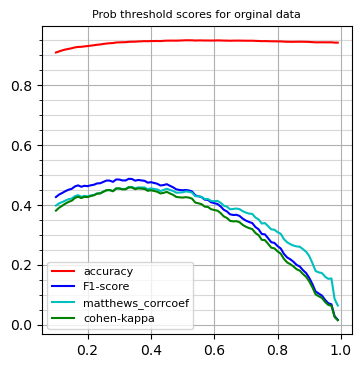

In [ ]:
# Plot the prob thresholds for various scores now:
_= plt.figure(figsize = (4,4))
_=plt.plot(np.arange(0.1, 1.0,  0.01),ac_orig,"r-", label = "accuracy")
_=plt.plot(np.arange(0.1, 1.0,  0.01),f1_orig,"b-", label = "F1-score")
_=plt.plot(np.arange(0.1, 1.0,  0.01),mc_orig,"c-", label = "matthews_corrcoef")
_=plt.plot(np.arange(0.1, 1.0,  0.01),ka_orig,"g-", label = "cohen-kappa")
_=plt.legend(fontsize = 8)
_=plt.title("Prob threshold scores for orginal data", fontsize = 8)

minor_ticks = np.arange(0, 1.0, 0.05)
_= plt.yticks(minor_ticks, minor=True)
_= plt.grid(which='minor', alpha=0.5)
_=plt.grid()

### Probability threshold graphs--Transformed data
F! score, Accuracy, Kappa and Matthews coeff<br>
Good references. [One](https://stats.stackexchange.com/a/312124) ; [Two](https://stats.stackexchange.com/a/207371) and [Three](https://stats.stackexchange.com/q/464636)

In [ ]:
# Calculate scores at diff prob thresholds:
# https://stackoverflow.com/a/76502698/3282777

f1_trans = []
ac_trans = []
ka_trans = []
mc_trans = []
p_trans_xgb = model_ht_trans.predict_proba(X_test_trans)[:,1]
for thresh in np.arange(0.1, 1.0,  0.01):
    y_pred = [1 if i > thresh else 0 for i in p_trans_xgb]
    f1_trans.append(f1_score(y_test.values,y_pred))
    ac_trans.append(accuracy_score(y_test.values,y_pred))
    ka_trans.append(cohen_kappa_score(y_test.values,y_pred))
    mc_trans.append(matthews_corrcoef(y_test.values,y_pred))


In [ ]:
# Save all above acores:
trans_scores = (p_trans_xgb, f1_trans,ac_trans,ka_trans,mc_trans)
utils.savePythonObject(trans_scores, "trans_scores.pkl", amazondata)

Object saved to: c:\amazon\allmodels\datafiles\trans_scores.pkl


In [ ]:
# Restore above scores:
p_trans_xgb, f1_trans,ac_trans,ka_trans,mc_trans = utils.restorePythonObject("trans_scores.pkl", amazondata)

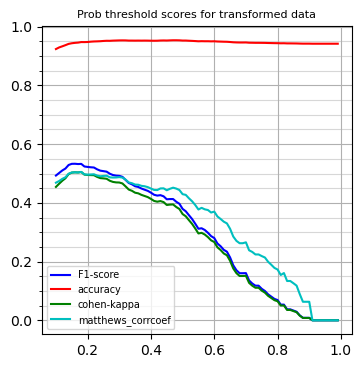

In [ ]:
# Plot scores at diff prob thresholds:

_= plt.figure(figsize = (4,4))
_=plt.plot(np.arange(0.1, 1.0,  0.01),f1_trans,"b-", label = "F1-score")
_=plt.plot(np.arange(0.1, 1.0,  0.01),ac_trans,"r-", label = "accuracy")
_=plt.plot(np.arange(0.1, 1.0,  0.01),ka_trans,"g-", label = "cohen-kappa")
_=plt.plot(np.arange(0.1, 1.0,  0.01),mc_trans,"c-", label = "matthews_corrcoef")
_=plt.legend(fontsize = 7)
_=plt.title("Prob threshold scores for transformed data", fontsize = 8)

minor_ticks = np.arange(0, 1.0, 0.05)
_= plt.yticks(minor_ticks, minor=True)
_= plt.grid(which='minor', alpha=0.5)
_=plt.grid()

## Probability threshold graphs--Orig and Transformed data
F! score, Accuracy, Kappa and Matthews coeff<br>
Good references. [One](https://stats.stackexchange.com/a/312124) ; [Two](https://stats.stackexchange.com/a/207371) and [Three](https://stats.stackexchange.com/q/464636)

In [ ]:
# https://stackoverflow.com/a/24953575/3282777
fig,ax=plt.subplots(2,2,figsize = (8,4))
minor_ticks = np.arange(0, 0.6, 0.05)

_=ax[0,0].plot(np.arange(0.1, 1.0,  0.01),f1_trans,"b-", label = "Trans data")
_=ax[0,0].plot(np.arange(0.1, 1.0,  0.01),f1_orig,"r-"  , label = "Original data")
_=ax[0,0].grid()
_=ax[0,0].legend(fontsize = 7 )

_=ax[0,1].plot(np.arange(0.1, 1.0,  0.01),ka_trans,"b-", label = "Trans data")
_=ax[0,1].plot(np.arange(0.1, 1.0,  0.01),ka_orig,"r-"  , label = "Original data")
_=ax[0,1].grid()


_=ax[1,0].plot(np.arange(0.1, 1.0,  0.01),mc_trans,"b-", label = "Trans data")
_=ax[1,0].plot(np.arange(0.1, 1.0,  0.01),mc_orig,"r-"  , label = "Original data")
_=ax[1,0].grid()

_=ax[1,1].plot(np.arange(0.1, 1.0,  0.01),ac_trans,"b-", label = "Trans data")
_=ax[1,1].plot(np.arange(0.1, 1.0,  0.01),ac_orig,"r-"  , label = "Original data")
_=ax[1,1].grid()

_=plt.suptitle("Post xgboost modeling\nBlue: Trans data,Red: Orig data")
_=plt.tight_layout()

NameError: name 'plt' is not defined

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

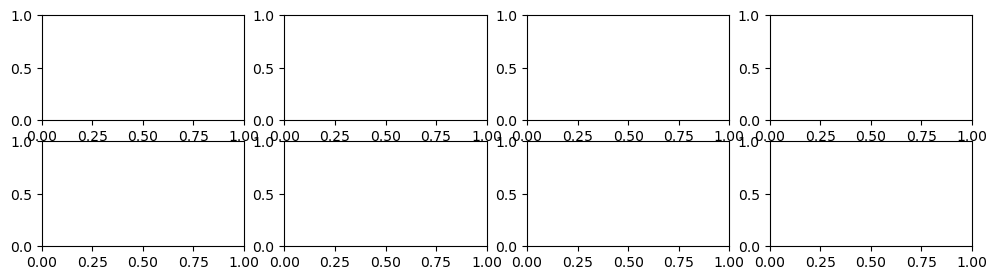

In [ ]:
# https://stackoverflow.com/a/24953575/3282777
fig,ax=plt.subplots(2,4,figsize = (12,3))
minor_ticks = np.arange(0, 0.6, 0.05)

_=ax[0].plot(np.arange(0.1, 1.0,  0.01),f1_trans,"b-.", label = "Transformed data")
_=ax[0].plot(np.arange(0.1, 1.0,  0.01),f1_orig,"r-"  , label = "Original data")

_=ax[1].plot(np.arange(0.1, 1.0,  0.01),ka_trans,"b-.", label = "Transformed data")
_=ax[1].plot(np.arange(0.1, 1.0,  0.01),ka_orig,"r-"  , label = "Original data")


_=ax[2].plot(np.arange(0.1, 1.0,  0.01),mc_trans,"b-.", label = "Transformed data")
_=ax[2].plot(np.arange(0.1, 1.0,  0.01),mc_orig,"r-"  , label = "Original data")


_=ax[3].plot(np.arange(0.1, 1.0,  0.01),ac_trans,"b-.", label = "Transformed data")
_=ax[3].plot(np.arange(0.1, 1.0,  0.01),ac_orig,"r-"  , label = "Original data")



#_=ax[0].plot(np.arange(0.1, 1.0,  0.01),mc_trans,"b-" )
_=ax[0].plot(np.arange(0.1, 1.0,  0.01),ac_trans,"b-")

_=ax[0].plot(np.arange(0.1, 1.0,  0.01),f1_orig,"r-.", label = "Original data")
_=ax[0].plot(np.arange(0.1, 1.0,  0.01),ka_orig,"r-")
#_=ax[0].plot(np.arange(0.1, 1.0,  0.01),mc_orig,"r-")
_=ax[0].plot(np.arange(0.1, 1.0,  0.01),ac_orig,"r-")

_=ax[0].legend(fontsize = 7 , loc = 'center right')

_=ax[0].set_yticks(minor_ticks, minor=True)
_=ax[0].grid(which = 'both')
_=ax[0].grid(which='minor', alpha=0.5)

_=ax[0].annotate('accuracy',xy=(0.6, 0.90), fontsize = 6)
_=ax[0].annotate('f1 score',xy=(0.2, 0.45), fontsize = 6 )
#_=ax[0].annotate('ma cor',xy=(0.15, 0.3), fontsize = 6 )
_=ax[0].annotate('cohen kappa',xy=(0.8, 0.1), fontsize = 6 )
_=ax[0].set_title("(Overlapping) Prob threshold scores for orig & transformed data", fontsize = 7)

# Prob density plots of orig and transformed data:
_=sns.kdeplot(x = p_trans_xgb, ax = ax[1], color = "blue", label = "Transformed data")
_=sns.kdeplot(x = p_orig_xgb, ax = ax[1], color = "red", label = "Original data")
_=ax[1].set_title("Prob density plots for pos class", fontsize = 7)

_=ax[1].grid()
_=ax[1].legend(fontsize = 7, loc = 'center right')

# Prob density plots of orig data--pos and neg classes:
_=sns.kdeplot(x = p_orig_xgb, ax = ax[2], label = "positive class")
_=sns.kdeplot(x = 1-p_orig_xgb, ax = ax[2], label = "Negative class")
_=ax[2].set_title("Prob density plots orig data, pos and neg classes", fontsize = 7)

_=ax[2].grid()
_=ax[2].legend(fontsize = 7 , loc = 'upper center')

_=plt.suptitle("Post xgboost modeling")
_=plt.tight_layout()

## Learning curve plots--orig and transformed data
Learning curves for both original and transformed data

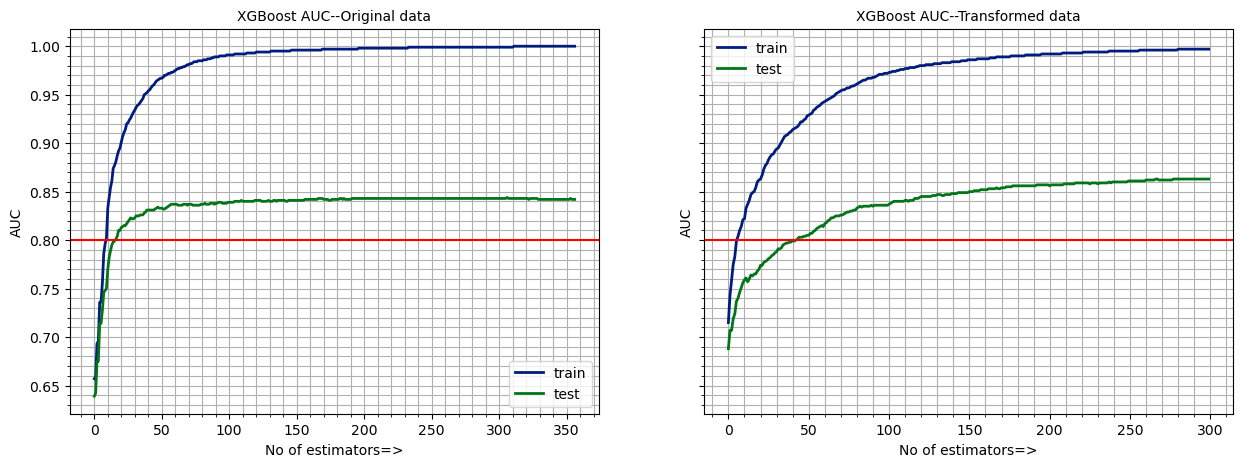

In [ ]:
plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (15,5), sharey = True);
results = [model_ht_orig.evals_result(),model_ht_trans.evals_result() ]
title = ["XGBoost AUC--Original data", 'XGBoost AUC--Transformed data']

for i in range(2):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 10);
    ax[i].axhline(y = 0.8, color = 'r', linestyle = '-')

plt.show();

## PCAs with transformed data:
This is essentially to see how data looks in 2D

In [ ]:
# 10.0 Check if any nulls in data
#       else we would impute using SimpleImputer:

X_train_trans.isnull().sum().sum()
X_test_trans.isnull().sum().sum()   # 49531


0

49531

In [ ]:
# 10.1 Impute. as test data has null values:

si = SimpleImputer(strategy = 'median')
X_train_trans_imputed = si.fit_transform(X_train_trans)
X_test_trans_imputed = si.transform(X_test_trans)

In [ ]:
# 10.1.1 Transform numpy arrays to pandas objects
cl = ["cl" + str(i)  for i in range(X_train_trans_imputed.shape[1])]
X_train_trans_imputed = pd.DataFrame(X_train_trans_imputed, columns = cl)
X_test_trans_imputed = pd.DataFrame(X_test_trans_imputed, columns = cl)

In [ ]:
# 10.1.2 Save the imputed files
X_train_trans_imputed.to_pickle(amazondata / "X_train_trans_imputed.pkl")
X_test_trans_imputed.to_pickle(amazondata / "X_test_trans_imputed.pkl")

In [ ]:
# 10.1.3 Restore imputed objects back:
X_train_trans_imputed = pd.read_pickle(amazondata / "X_train_trans_imputed.pkl")
X_test_trans_imputed = pd.read_pickle(amazondata / "X_test_trans_imputed.pkl")

In [ ]:
# 10.2 2D PCA with transformed train data.
#      Drop the initial cat_cols first:

pca = PCA(n_components= 0.95,
          whiten= True,
          random_state = None)
ss = StandardScaler()
pca_train = pca.fit_transform(ss.fit_transform(X_train_trans_imputed))
pca_test = pca.transform(ss.transform(X_test_trans_imputed))

In [ ]:
# 13.3.3 Save PCA object
utils.savePythonObject(pca,"pca.pkl", amazonestimators)

Object saved to: c:\amazon\allmodels\estimators\pca.pkl


In [ ]:
# 13.3.4 Restore PCA object
pca = utils.restorePythonObject("pca.pkl", amazonestimators)

In [ ]:
# 10.3 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(pca_train.shape[1])]
pca_train = pd.DataFrame(pca_train, columns = colnames)
pca_test = pd.DataFrame(pca_test, columns = colnames)

In [ ]:
# 10.3.1 Save PCA data:
pca_train.to_pickle(amazondata / "pca_train.pkl")
pca_test.to_pickle(amazondata / "pca_test.pkl")

In [ ]:
# 10.3.2 Read back PCA data:
pca_train = pd.read_pickle(amazondata / "pca_train.pkl")
pca_test = pd.read_pickle(amazondata / "pca_test.pkl")

# Check
pca_train.shape   # (24576, 48)
pca_test.shape    # (8193, 48)
pca_train.head(2)
pca_test.head(2)


(24576, 48)

(8193, 48)

pc0       pc1       pc2       pc3       pc4       pc5       pc6  \
0 -1.391690  0.595104  2.837418 -0.184022  1.246205 -1.173366  0.993055   
1  0.444649 -1.301146 -1.139725 -0.027379 -1.420689 -0.124003  0.863836   

        pc7       pc8       pc9  ...      pc38      pc39      pc40      pc41  \
0 -1.632617 -0.217094 -0.534031  ...  0.071305  1.642031  1.362056  0.240152   
1 -0.025052 -0.332283 -0.451414  ...  1.024935 -1.601572  0.167935  0.030990   

       pc42      pc43      pc44      pc45      pc46      pc47  
0  0.803274 -0.591311  1.140773 -0.665706  0.749327 -2.915998  
1 -0.175781 -0.310411 -0.228263 -2.425571 -0.579172  0.340205  

[2 rows x 48 columns]

pc0       pc1       pc2       pc3       pc4       pc5       pc6  \
0  0.242365 -1.333155 -0.473287  0.789214  0.055735 -0.815395  1.173847   
1 -1.242501  0.896354 -0.538149  0.327628 -0.488728 -1.057267  0.103417   

        pc7       pc8       pc9  ...      pc38      pc39      pc40      pc41  \
0 -1.194017 -0.269326 -1.274175  ... -1.400978 -0.295050  0.272993  0.634323   
1  0.360202  0.736951 -1.167013  ...  0.266549  0.498457  0.389341 -0.742530   

       pc42      pc43      pc44      pc45      pc46      pc47  
0  2.246027 -0.176949 -1.951776  1.003641 -1.300742  0.083362  
1 -0.456762 -0.818895  1.171357 -0.050710  0.059814 -0.205021  

[2 rows x 48 columns]

In [ ]:
# 10.3.3
pca.explained_variance_ratio_[:10]

array([0.29874745, 0.14072731, 0.07988451, 0.05366532, 0.05125645,
       0.04326194, 0.02698628, 0.0194776 , 0.01935495, 0.01630924],
      dtype=float32)

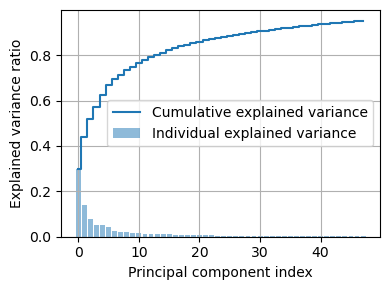

In [ ]:
# 10.3.4 Plot of explained variance and cumulative explained variance:
# Ref: https://vitalflux.com/pca-explained-variance-concept-python-example/#Sklearn_PCA_Class_for_determining_Explained_Variance

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
fig = plt.figure(figsize = (4,3))
_=plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
_=plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
_=plt.ylabel('Explained variance ratio')
_=plt.xlabel('Principal component index')
_=plt.legend(loc='best')
_=plt.grid()
_=plt.tight_layout()
_=plt.show()

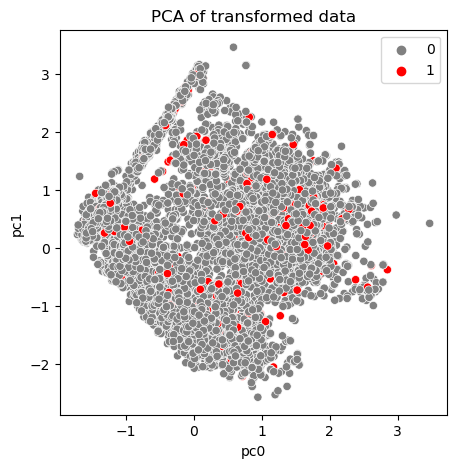

In [ ]:
# 10.4 2D PCA plot from original train data:
#      43% of variance is explained by the two components:

plt.style.use('seaborn-v0_8-dark-palette')
fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.scatterplot(data = pca_train,
                x= 'pc0',
                y = 'pc1',
                hue = y_train.values,
                palette = ["grey", "red"]
                ).set(title='PCA of transformed data') ;



## How good is  PCA?
We perform predictive analytics with the PCA

In [ ]:
# 14.1
# REf: https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
# Maximise AUC score

# Original data
tr_X =  pca_train
test_X = pca_test
ytrain = y_train
ytest = y_test



# 14.2 Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 1, 14),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 500),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
              'eval_metric': 'auc',
              'use_label_encoder': False
             }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(tr_X, ytrain)
    # Make predictions
    y_pred = optuna_model.predict_proba(test_X)[:,1]

    # Evaluate predictions
    score = roc_auc_score(ytest, y_pred)
    # Maximise score
    return score



# 14.3 Create optuna study
study = optuna.create_study(direction='maximize')

# 14.4 Begin optimization
study.optimize(objective, n_trials=500)

# Can run this function again to optimize further
#study.optimize(objective, n_trials=200)



#### Get Optuna results--Original data

In [ ]:
# 14.5 After study has finished:
print('Number of finished trials: {}'.format(len(study.trials)))

# 14.5.1 Best trial
trial = study.best_trial
trial.value   # Best trial result (f1-score)  0.455012853470

# 14.5.2 Get best parameters:
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

In [ ]:
# 18.3.1 Save estimator
utils.savePythonObject(trial.params, "pca_trials.pkl", amazondata)

Object saved to: c:\amazon\allmodels\datafiles\trans_trial.pkl


In [ ]:
# 18.3.2 Restore estimator
pca_trials = utils.restorePythonObject("pca_trials.pkl", amazondata)

#### xgboost modeling with tuned hyperparameters (PCA)

In [ ]:
# 18.4
model_ht_pca_trans = xgb.XGBClassifier(**pca_trials)
model_ht_pca_trans.fit(tr_X, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.04805392008507638, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.00564667509919346, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.012274234516939181, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=393, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# 18.5.1 Svave estimator:

utils.savePythonObject(model_ht_pca_trans, "model_ht_pca_trans.pkl", amazonestimators )

Object saved to: c:\amazon\allmodels\estimators\model_ht_trans.pkl


In [ ]:
# 18.5.2 Read back estimator:

model_ht_pca_trans = utils.restorePythonObject("model_ht_pca_trans.pkl", amazonestimators)

##### Score calculations (PCA)

In [ ]:
# 18.5.3 AUC Score:

p_ht_pca_trans_xgb = model_ht_pca_trans.predict_proba(X_test_trans)[:,1]
f"1. AUC score for hypertuned transformed data: {roc_auc_score(y_test.values, p_ht_trans_xgb  ) }"
f"2. Log loss for hypertuned transformed data: {log_loss(y_test.values,p_ht_trans_xgb  ) }"
f"3. Brier score for hypertuned transformed data: {brier_score_loss(y_test.values,p_ht_trans_xgb  ) }"
f"4. Best iteration from hypertuned transformed data: {model_ht_trans.best_iteration}"

'1. AUC score for hypertuned transformed data: 0.8774835287796074'

'2. Log loss for hypertuned transformed data: 0.14697544727797995'

'3. Brier score for hypertuned transformed data: 0.038417990414265454'

'4. Best iteration from hypertuned transformed data: 392'

### Probability threshold graphs--PCA data
F! score, Accuracy, Kappa and Matthews coeff<br>
Good references. [One](https://stats.stackexchange.com/a/312124) ; [Two](https://stats.stackexchange.com/a/207371) and [Three](https://stats.stackexchange.com/q/464636)


In [ ]:
# Evaluating scores at various prob thresholds:
# https://stackoverflow.com/a/76502698/3282777
f1_pca = []
ac_pca = []
ka_pca = []
mc_pca = []
p_pca_xgb = model_ht_pca_trans.predict_proba(pca_test)[:,1]
for thresh in np.arange(0.1, 1.0,  0.01):
    y_pred = [1 if i > thresh else 0 for i in p_orig_xgb]
    f1_orig.append(f1_score(y_test.values,y_pred))
    ac_orig.append(accuracy_score(y_test.values,y_pred))
    ka_orig.append(cohen_kappa_score(y_test.values,y_pred))
    mc_orig.append(matthews_corrcoef(y_test.values,y_pred))

In [ ]:
# Save these list of scores:
pca_scores = (p_pca_xgb, f1_pca,ac_pca,ka_pca,mc_pca)
utils.savePythonObject(pca_scores, "pca_scores.pkl", amazondata)

Object saved to: c:\amazon\allmodels\datafiles\orig_scores.pkl


In [ ]:
# Restore above lists of scores:
p_pca_xgb, f1_pca,ac_pca,ka_pca,mc_pca = utils.restorePythonObject("pca_scores.pkl", amazondata)

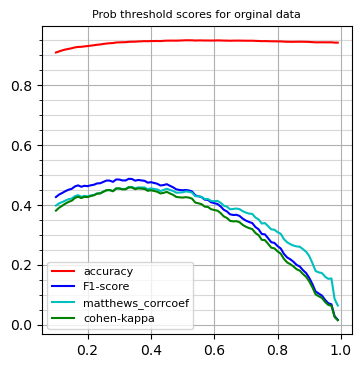

In [ ]:
# Plot the prob thresholds for various scores now:
_= plt.figure(figsize = (4,4))
_=plt.plot(np.arange(0.1, 1.0,  0.01),ac_pca,"r-", label = "accuracy")
_=plt.plot(np.arange(0.1, 1.0,  0.01),f1_pca,"b-", label = "F1-score")
_=plt.plot(np.arange(0.1, 1.0,  0.01),mc_pca,"c-", label = "matthews_corrcoef")
_=plt.plot(np.arange(0.1, 1.0,  0.01),ka_pca,"g-", label = "cohen-kappa")
_=plt.legend(fontsize = 8)
_=plt.title("Prob threshold scores for orginal data", fontsize = 8)

minor_ticks = np.arange(0, 1.0, 0.05)
_= plt.yticks(minor_ticks, minor=True)
_= plt.grid(which='minor', alpha=0.5)
_=plt.grid()

### Learning plots

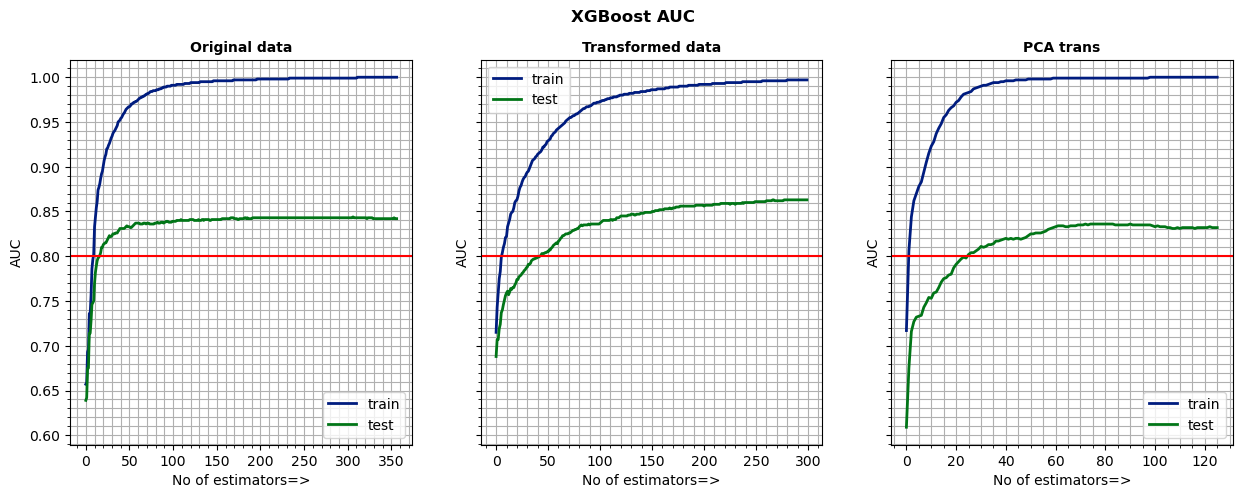

In [ ]:
# 11.1
plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,3, figsize = (15,5), sharey = True);
results = [model_ht_orig.evals_result(),model_ht_trans.evals_result(), model_ht_pca_trans.evals_result() ]
title = ["Original data", 'Transformed data', 'PCA trans']
fig.suptitle("XGBoost AUC", fontweight = "bold")
for i in range(3):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 10, fontweight = "bold");
    ax[i].axhline(y = 0.8, color = 'r', linestyle = '-')

plt.show();

## Prob calbration plots

In [ ]:
# Probability Calibration plots:
clf_list = [
    (model_ht_orig, "xgb-Orig data", X_test,y_test.values),
    (model_ht_trans, "xgb-Transformed data",X_test_trans,y_test.values),
]

fig = plt.figure(figsize=(5, 7))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name,xt,yt) in enumerate(clf_list):
    display = CalibrationDisplay.from_estimator(
        clf,
        xt,
        yt,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

_=ax_calibration_curve.grid()
_=ax_calibration_curve.set_title("Calibration plots of models on original and transformed data", fontsize = 7)
_=ax_calibration_curve.set_xlabel("Mean predicted prob, pos class:1", fontsize = 7)
_=ax_calibration_curve.set_ylabel("Fraction of positives, pos class:1", fontsize = 7)
_=plt.legend(fontsize = 6)

NameError: name 'model_ht_orig' is not defined

Probability calibration

In [ ]:
# Original data--xgboost modeling
calibrator = CalibratedClassifierCV(model_ht_orig,method = "isotonic", cv ='prefit')
_=calibrator.fit(X_test,y_test.values)
p_cal_ht_orig = calibrator.predict_proba(X_test)[:,1]

# Transformed data xgboost modeling
calibrator = CalibratedClassifierCV(model_ht_trans,method = "isotonic", cv ='prefit')
_=calibrator.fit(X_test_trans,y_test.values)
p_cal_ht_trans = calibrator.predict_proba(X_test_trans)[:,1]

Scores after calibration

In [ ]:
# Calculate brier loss for calbrated prob in each case of modeling:
f"Brier loss orig data xgboost modeling: {brier_score_loss(y_test.values,cal_preds_ht_orig)}"
f"Brier loss transformed data xgboost modeling: {brier_score_loss(y_test.values,cal_preds_ht_trans)}"
f"================"
f"Log loss orig data xgboost modeling: {log_loss(y_test.values,cal_preds_ht_orig)}"
f"Log loss transformed data xgboost modeling: {log_loss(y_test.values,cal_preds_ht_orig)}"

In [ ]:
# Probability Calibration plots:
clf_list = [
    ("xgb-Orig data", p_cal_ht_orig),
    ("xgb-Transformed data",p_cal_ht_trans),

]

fig = plt.figure(figsize=(5, 7))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (name,y_true) in enumerate(clf_list):
    display = CalibrationDisplay.from_predictions(
        y_test.values,
        y_true,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

_=ax_calibration_curve.grid()
_=ax_calibration_curve.set_title("Calibration plots of models on original and transformed data", fontsize = 7)
_=ax_calibration_curve.set_xlabel("Mean predicted prob, pos class:1", fontsize = 7)
_=ax_calibration_curve.set_ylabel("Fraction of positives, pos class:1", fontsize = 7)
_=plt.legend(fontsize = 6)

## tsne
Takes time..Does this plot show any pattern?

In [ ]:
# 12.0 Instantiate class:
tsne = TSNE(perplexity = 30)  # perplexity of 30 gives best AUC
                              # Tried 20 and 50 also

# 12.0.1 Fit and transform
ss = StandardScaler()
da = tsne.fit_transform(ss.fit_transform(train_trans.iloc[:, len(cat_cols) : ]))

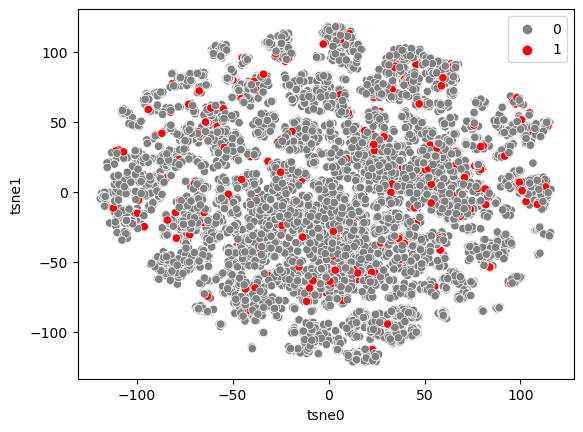

In [ ]:
# 12.1 Plot tsne output:

colnames = ["tsne" + str(i) for i in range(da.shape[1])]
da = pd.DataFrame(da, columns = colnames)
plt.figure(100);
sns.scatterplot(x= da['tsne0'], y = da['tsne1'], hue = y_train.values, palette = ["grey", "red"]);

### Learning plots

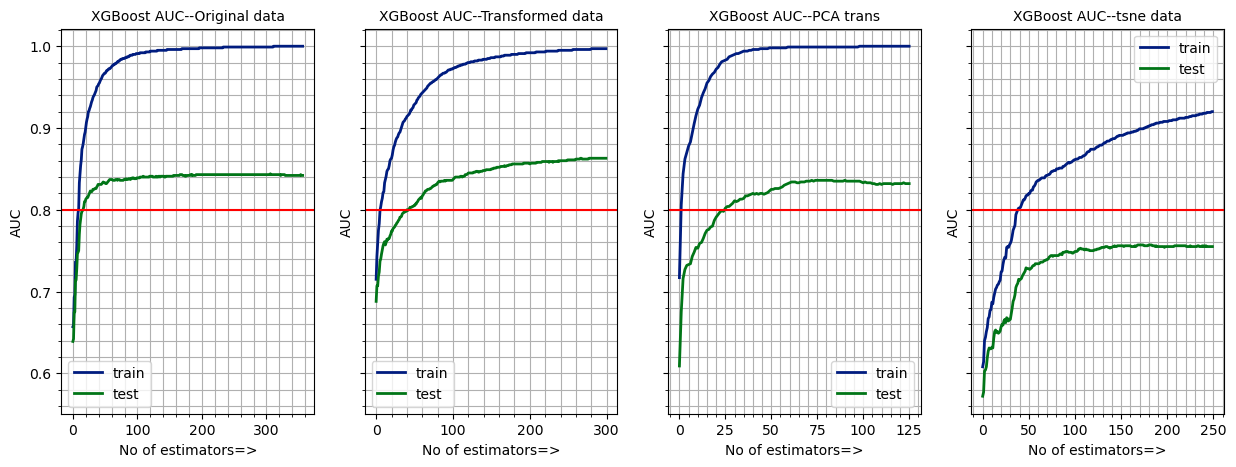

In [ ]:
# 14.0
plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (15,5), sharey = True);
results = [model_orig.evals_result(),model_trans.evals_result(), model_pca.evals_result(), model_tsne.evals_result() ]
title = ["XGBoost AUC--Original data", 'XGBoost AUC--Transformed data', 'XGBoost AUC--PCA trans', 'XGBoost AUC--tsne data' ]

for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 10);
    ax[i].axhline(y = 0.8, color = 'r', linestyle = '-')

plt.show();

## Hyperparameter tuning--original data
We use optuna to tune original data and maximize f1-score

In [ ]:
# 14.1
# REf: https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
# Maximise AUC score

# Original data
tr_X =  X_train
test_X = X_test
ytrain = y_train
ytest = y_test



# 14.2 Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 1, 14),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 500),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
              'eval_metric': 'auc',
              'use_label_encoder': False
             }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(tr_X, ytrain)
    # Make predictions
    y_pred = optuna_model.predict_proba(test_X)[:,1]

    # Evaluate predictions
    score = roc_auc_score(ytest, y_pred)
    # Maximise score
    return score



# 14.3 Create optuna study
study = optuna.create_study(direction='maximize')

# 14.4 Begin optimization
study.optimize(objective, n_trials=500)

# Can run this function again to optimize further
#study.optimize(objective, n_trials=200)



[I 2024-02-28 13:46:14,702] A new study created in memory with name: no-name-159f1cc1-3f0b-4ad0-b74d-886e5b7cc128
[I 2024-02-28 13:46:15,468] Trial 0 finished with value: 0.7238355900804798 and parameters: {'max_depth': 3, 'learning_rate': 0.27998232461603834, 'n_estimators': 291, 'min_child_weight': 4, 'gamma': 2.1277994768687894e-08, 'subsample': 0.050898498972826285, 'colsample_bytree': 0.3270134571038139, 'reg_alpha': 0.00045171028991503834, 'reg_lambda': 0.008512109001291875}. Best is trial 0 with value: 0.7238355900804798.
[I 2024-02-28 13:46:16,811] Trial 1 finished with value: 0.813912516815595 and parameters: {'max_depth': 6, 'learning_rate': 0.12807782032305137, 'n_estimators': 313, 'min_child_weight': 1, 'gamma': 1.8689301885679182e-07, 'subsample': 0.7193067885743037, 'colsample_bytree': 0.018383107438987762, 'reg_alpha': 0.0010376520843945723, 'reg_lambda': 1.3602841122297478e-06}. Best is trial 1 with value: 0.813912516815595.
[I 2024-02-28 13:46:17,338] Trial 2 finished 

[I 2024-02-28 13:46:43,112] Trial 20 finished with value: 0.8282897480762851 and parameters: {'max_depth': 13, 'learning_rate': 0.1544031534116641, 'n_estimators': 157, 'min_child_weight': 6, 'gamma': 0.004381360315597816, 'subsample': 0.5435937696755441, 'colsample_bytree': 0.22744255742899888, 'reg_alpha': 0.18281207556667484, 'reg_lambda': 5.415616118087831e-06}. Best is trial 18 with value: 0.8352026590095238.
[I 2024-02-28 13:46:44,469] Trial 21 finished with value: 0.8256767371650753 and parameters: {'max_depth': 13, 'learning_rate': 0.15299916286017484, 'n_estimators': 149, 'min_child_weight': 6, 'gamma': 0.004041793050125739, 'subsample': 0.5778636555356212, 'colsample_bytree': 0.2393124222250456, 'reg_alpha': 0.11562534811710293, 'reg_lambda': 5.688568142803055e-06}. Best is trial 18 with value: 0.8352026590095238.
[I 2024-02-28 13:46:45,846] Trial 22 finished with value: 0.8304013659100812 and parameters: {'max_depth': 13, 'learning_rate': 0.13409578600346034, 'n_estimators':

[I 2024-02-28 13:47:21,967] Trial 40 finished with value: 0.8482242567657318 and parameters: {'max_depth': 12, 'learning_rate': 0.06539940215837639, 'n_estimators': 378, 'min_child_weight': 1, 'gamma': 0.749197146533877, 'subsample': 0.3162621195500847, 'colsample_bytree': 0.42817194243903556, 'reg_alpha': 0.0019015147948159053, 'reg_lambda': 0.013020562909674068}. Best is trial 39 with value: 0.8520074581707804.
[I 2024-02-28 13:47:25,507] Trial 41 finished with value: 0.8489969132006453 and parameters: {'max_depth': 12, 'learning_rate': 0.07150572185640168, 'n_estimators': 383, 'min_child_weight': 1, 'gamma': 0.4300664957689588, 'subsample': 0.3843491026388035, 'colsample_bytree': 0.4251879332583875, 'reg_alpha': 0.0006809662279112522, 'reg_lambda': 0.008299032248247915}. Best is trial 39 with value: 0.8520074581707804.
[I 2024-02-28 13:47:28,984] Trial 42 finished with value: 0.8474024039536395 and parameters: {'max_depth': 12, 'learning_rate': 0.06722414543745489, 'n_estimators': 3

[I 2024-02-28 13:48:24,325] Trial 60 finished with value: 0.8482636138674747 and parameters: {'max_depth': 12, 'learning_rate': 0.04672752216459099, 'n_estimators': 495, 'min_child_weight': 1, 'gamma': 0.08890694990416294, 'subsample': 0.284369014573527, 'colsample_bytree': 0.4519373032079545, 'reg_alpha': 0.0010103177073639323, 'reg_lambda': 0.0041430459287496}. Best is trial 39 with value: 0.8520074581707804.
[I 2024-02-28 13:48:28,583] Trial 61 finished with value: 0.8458920751742508 and parameters: {'max_depth': 12, 'learning_rate': 0.047240167255411566, 'n_estimators': 495, 'min_child_weight': 1, 'gamma': 0.09008999202213862, 'subsample': 0.278014033131706, 'colsample_bytree': 0.45013885453936503, 'reg_alpha': 0.0007800320641993385, 'reg_lambda': 0.004510818587386914}. Best is trial 39 with value: 0.8520074581707804.
[I 2024-02-28 13:48:32,353] Trial 62 finished with value: 0.841065910573012 and parameters: {'max_depth': 13, 'learning_rate': 0.07569696615210092, 'n_estimators': 41

[I 2024-02-28 13:49:49,359] Trial 80 finished with value: 0.8390110052295748 and parameters: {'max_depth': 14, 'learning_rate': 0.08130734785682275, 'n_estimators': 437, 'min_child_weight': 1, 'gamma': 0.06442953013270317, 'subsample': 0.7784629021027049, 'colsample_bytree': 0.9968033430205948, 'reg_alpha': 0.0020979246092420398, 'reg_lambda': 0.04870021480170547}. Best is trial 75 with value: 0.8525262066368099.
[I 2024-02-28 13:49:53,626] Trial 81 finished with value: 0.8491684172377547 and parameters: {'max_depth': 14, 'learning_rate': 0.0736959308342759, 'n_estimators': 409, 'min_child_weight': 1, 'gamma': 0.6798063635482551, 'subsample': 0.42200914879228124, 'colsample_bytree': 0.40628877262698226, 'reg_alpha': 0.001417224192286924, 'reg_lambda': 0.019573894982682513}. Best is trial 75 with value: 0.8525262066368099.
[I 2024-02-28 13:49:58,142] Trial 82 finished with value: 0.8446741915258693 and parameters: {'max_depth': 13, 'learning_rate': 0.06862596209634342, 'n_estimators': 4

[I 2024-02-28 13:51:11,416] Trial 100 finished with value: 0.8467385261749325 and parameters: {'max_depth': 14, 'learning_rate': 0.045387712751054944, 'n_estimators': 346, 'min_child_weight': 4, 'gamma': 0.12967173661900436, 'subsample': 0.7028279470540538, 'colsample_bytree': 0.45371868513002567, 'reg_alpha': 0.0008668178628102271, 'reg_lambda': 0.06908484898326143}. Best is trial 75 with value: 0.8525262066368099.
[I 2024-02-28 13:51:15,420] Trial 101 finished with value: 0.8510790132081341 and parameters: {'max_depth': 14, 'learning_rate': 0.0755458069283262, 'n_estimators': 364, 'min_child_weight': 2, 'gamma': 0.21358680482267817, 'subsample': 0.8683481516279713, 'colsample_bytree': 0.402039400243051, 'reg_alpha': 0.0014159395064415863, 'reg_lambda': 0.02293265027469872}. Best is trial 75 with value: 0.8525262066368099.
[I 2024-02-28 13:51:19,388] Trial 102 finished with value: 0.8464356951420764 and parameters: {'max_depth': 14, 'learning_rate': 0.05822987933171215, 'n_estimators'

[I 2024-02-28 13:52:13,760] Trial 120 finished with value: 0.8326153395397297 and parameters: {'max_depth': 14, 'learning_rate': 0.0477740738758303, 'n_estimators': 329, 'min_child_weight': 7, 'gamma': 0.0755912405275135, 'subsample': 0.598964404597336, 'colsample_bytree': 0.36145485647672493, 'reg_alpha': 0.0014100189413615144, 'reg_lambda': 0.03816124328507677}. Best is trial 105 with value: 0.854397855475256.
[I 2024-02-28 13:52:16,381] Trial 121 finished with value: 0.8515611377044862 and parameters: {'max_depth': 13, 'learning_rate': 0.04616124204165396, 'n_estimators': 271, 'min_child_weight': 2, 'gamma': 0.014924566608109726, 'subsample': 0.9292291845703569, 'colsample_bytree': 0.3229587333195508, 'reg_alpha': 0.0020218807823680967, 'reg_lambda': 0.02923326840689097}. Best is trial 105 with value: 0.854397855475256.
[I 2024-02-28 13:52:19,443] Trial 122 finished with value: 0.8475786909718634 and parameters: {'max_depth': 13, 'learning_rate': 0.055546120478402995, 'n_estimators'

[I 2024-02-28 13:53:11,268] Trial 140 finished with value: 0.8509982491555989 and parameters: {'max_depth': 13, 'learning_rate': 0.04568687082476722, 'n_estimators': 244, 'min_child_weight': 1, 'gamma': 0.08976453656322206, 'subsample': 0.4706685111561098, 'colsample_bytree': 0.4513683163682096, 'reg_alpha': 8.139643989649097e-05, 'reg_lambda': 0.5490705286834153}. Best is trial 105 with value: 0.854397855475256.
[I 2024-02-28 13:53:13,953] Trial 141 finished with value: 0.8532313547097059 and parameters: {'max_depth': 13, 'learning_rate': 0.04229147923837579, 'n_estimators': 238, 'min_child_weight': 1, 'gamma': 0.12611280959871443, 'subsample': 0.6601604225921051, 'colsample_bytree': 0.43675554131540284, 'reg_alpha': 4.1922879338235876e-05, 'reg_lambda': 0.2088649688747568}. Best is trial 105 with value: 0.854397855475256.
[I 2024-02-28 13:53:16,261] Trial 142 finished with value: 0.8491014555021502 and parameters: {'max_depth': 12, 'learning_rate': 0.038035913735474575, 'n_estimators

[I 2024-02-28 13:54:02,322] Trial 160 finished with value: 0.8260757744466364 and parameters: {'max_depth': 14, 'learning_rate': 0.05260916307015489, 'n_estimators': 238, 'min_child_weight': 1, 'gamma': 0.1107589923293266, 'subsample': 0.5417130603596546, 'colsample_bytree': 0.10393347724617621, 'reg_alpha': 3.3221424644618655e-05, 'reg_lambda': 0.32683753343783056}. Best is trial 105 with value: 0.854397855475256.
[I 2024-02-28 13:54:05,164] Trial 161 finished with value: 0.8516874084059116 and parameters: {'max_depth': 13, 'learning_rate': 0.037721838866019784, 'n_estimators': 250, 'min_child_weight': 1, 'gamma': 0.03340418516579816, 'subsample': 0.6737616517747343, 'colsample_bytree': 0.3764883984536651, 'reg_alpha': 0.00010507293966524037, 'reg_lambda': 0.1379314023166386}. Best is trial 105 with value: 0.854397855475256.
[I 2024-02-28 13:54:07,746] Trial 162 finished with value: 0.8551874573289756 and parameters: {'max_depth': 13, 'learning_rate': 0.045550488056642024, 'n_estimato

[I 2024-02-28 13:54:49,003] Trial 180 finished with value: 0.8206647195833833 and parameters: {'max_depth': 14, 'learning_rate': 0.033082163205152434, 'n_estimators': 203, 'min_child_weight': 1, 'gamma': 0.023830236301802192, 'subsample': 0.6982580437344661, 'colsample_bytree': 0.21686537328928265, 'reg_alpha': 6.188269441080291e-06, 'reg_lambda': 0.11835721511101358}. Best is trial 173 with value: 0.8563124144871305.
[I 2024-02-28 13:54:51,054] Trial 181 finished with value: 0.8552790172531697 and parameters: {'max_depth': 14, 'learning_rate': 0.03143780606661829, 'n_estimators': 177, 'min_child_weight': 1, 'gamma': 0.03480129540251211, 'subsample': 0.8057326426111223, 'colsample_bytree': 0.3052480227020964, 'reg_alpha': 1.3766236473775674e-05, 'reg_lambda': 0.05821914945507521}. Best is trial 173 with value: 0.8563124144871305.
[I 2024-02-28 13:54:53,045] Trial 182 finished with value: 0.8549847955863198 and parameters: {'max_depth': 14, 'learning_rate': 0.03113764779900932, 'n_estim

[I 2024-02-28 13:55:29,593] Trial 200 finished with value: 0.8513905902635996 and parameters: {'max_depth': 14, 'learning_rate': 0.04016317130589089, 'n_estimators': 188, 'min_child_weight': 1, 'gamma': 0.09031072213864075, 'subsample': 0.8688341296695674, 'colsample_bytree': 0.31432987607209417, 'reg_alpha': 1.0621262379406381e-05, 'reg_lambda': 0.0706464804089778}. Best is trial 173 with value: 0.8563124144871305.
[I 2024-02-28 13:55:32,044] Trial 201 finished with value: 0.8539410124505099 and parameters: {'max_depth': 14, 'learning_rate': 0.036319323017699794, 'n_estimators': 225, 'min_child_weight': 1, 'gamma': 0.05347592425813874, 'subsample': 0.7882234396832425, 'colsample_bytree': 0.24188872120304047, 'reg_alpha': 1.7134780662378422e-05, 'reg_lambda': 0.11865185862820328}. Best is trial 173 with value: 0.8563124144871305.
[I 2024-02-28 13:55:34,424] Trial 202 finished with value: 0.8538736407450955 and parameters: {'max_depth': 14, 'learning_rate': 0.03673814269520231, 'n_estim

[I 2024-02-28 13:56:10,203] Trial 220 finished with value: 0.8526016410818175 and parameters: {'max_depth': 14, 'learning_rate': 0.02881449220055386, 'n_estimators': 189, 'min_child_weight': 1, 'gamma': 0.023412992764968683, 'subsample': 0.7169407028408994, 'colsample_bytree': 0.3314068011006398, 'reg_alpha': 5.082963969739118e-06, 'reg_lambda': 0.0008882858039324928}. Best is trial 173 with value: 0.8563124144871305.
[I 2024-02-28 13:56:11,541] Trial 221 finished with value: 0.7730587519535062 and parameters: {'max_depth': 14, 'learning_rate': 0.03374396298191982, 'n_estimators': 242, 'min_child_weight': 1, 'gamma': 0.04074048164639478, 'subsample': 0.03756529734548519, 'colsample_bytree': 0.3387472126009937, 'reg_alpha': 1.1134767909342968e-05, 'reg_lambda': 0.1852887392598668}. Best is trial 173 with value: 0.8563124144871305.
[I 2024-02-28 13:56:14,072] Trial 222 finished with value: 0.8535951345876222 and parameters: {'max_depth': 14, 'learning_rate': 0.023870138944006025, 'n_esti

[I 2024-02-28 13:56:52,400] Trial 240 finished with value: 0.8538528689413979 and parameters: {'max_depth': 14, 'learning_rate': 0.02441546690753455, 'n_estimators': 226, 'min_child_weight': 1, 'gamma': 0.00016640289854364656, 'subsample': 0.932844331094052, 'colsample_bytree': 0.3148895311279187, 'reg_alpha': 7.889738815461016e-06, 'reg_lambda': 0.004427681154089744}. Best is trial 173 with value: 0.8563124144871305.
[I 2024-02-28 13:56:54,992] Trial 241 finished with value: 0.855720964708159 and parameters: {'max_depth': 14, 'learning_rate': 0.023102853411050426, 'n_estimators': 228, 'min_child_weight': 1, 'gamma': 0.10812159316235039, 'subsample': 0.9159390499006307, 'colsample_bytree': 0.32122167621477343, 'reg_alpha': 5.920835576288053e-06, 'reg_lambda': 0.0011658855788732327}. Best is trial 173 with value: 0.8563124144871305.
[I 2024-02-28 13:56:57,466] Trial 242 finished with value: 0.854151326962949 and parameters: {'max_depth': 14, 'learning_rate': 0.02004751676622258, 'n_esti

[I 2024-02-28 13:57:40,383] Trial 260 finished with value: 0.8555117434485457 and parameters: {'max_depth': 14, 'learning_rate': 0.01512125265391944, 'n_estimators': 158, 'min_child_weight': 1, 'gamma': 0.17812857449712746, 'subsample': 0.941184218055613, 'colsample_bytree': 0.3973038892156538, 'reg_alpha': 7.085193811840187e-06, 'reg_lambda': 0.003064944983170391}. Best is trial 245 with value: 0.8593041008460137.
[I 2024-02-28 13:57:41,527] Trial 261 finished with value: 0.7958090699534219 and parameters: {'max_depth': 7, 'learning_rate': 0.015313915354197166, 'n_estimators': 154, 'min_child_weight': 1, 'gamma': 0.26789868174510306, 'subsample': 0.9987065423222876, 'colsample_bytree': 0.40227513563773254, 'reg_alpha': 5.275644290790439e-06, 'reg_lambda': 0.003191818428743355}. Best is trial 245 with value: 0.8593041008460137.
[I 2024-02-28 13:57:43,777] Trial 262 finished with value: 0.8547161287042822 and parameters: {'max_depth': 14, 'learning_rate': 0.01512005118968309, 'n_estimat

[I 2024-02-28 13:58:16,882] Trial 280 finished with value: 0.8571691147330576 and parameters: {'max_depth': 14, 'learning_rate': 0.013065264217445464, 'n_estimators': 165, 'min_child_weight': 1, 'gamma': 0.1625540317962268, 'subsample': 0.8714002163400061, 'colsample_bytree': 0.3550961059153832, 'reg_alpha': 5.773262169208267e-06, 'reg_lambda': 0.002788398114754665}. Best is trial 245 with value: 0.8593041008460137.
[I 2024-02-28 13:58:19,381] Trial 281 finished with value: 0.8562904127740033 and parameters: {'max_depth': 14, 'learning_rate': 0.014333156385041698, 'n_estimators': 166, 'min_child_weight': 1, 'gamma': 0.13797810330384164, 'subsample': 0.8754538853133219, 'colsample_bytree': 0.44574310611928236, 'reg_alpha': 6.42215876877653e-06, 'reg_lambda': 0.002685830790135895}. Best is trial 245 with value: 0.8593041008460137.
[I 2024-02-28 13:58:21,876] Trial 282 finished with value: 0.8554885118259891 and parameters: {'max_depth': 14, 'learning_rate': 0.013484565183634747, 'n_estim

[I 2024-02-28 13:58:53,323] Trial 300 finished with value: 0.8595115455697843 and parameters: {'max_depth': 14, 'learning_rate': 0.018929627692214956, 'n_estimators': 156, 'min_child_weight': 1, 'gamma': 0.12416349579220319, 'subsample': 0.9992547941744644, 'colsample_bytree': 0.4893866476476747, 'reg_alpha': 8.974695254933517e-06, 'reg_lambda': 0.004136021344429404}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 13:58:54,417] Trial 301 finished with value: 0.8228601079149864 and parameters: {'max_depth': 14, 'learning_rate': 0.015864333471307918, 'n_estimators': 105, 'min_child_weight': 2, 'gamma': 0.32753990671797145, 'subsample': 0.2485872657202314, 'colsample_bytree': 0.4654438307365416, 'reg_alpha': 3.90998528420515e-06, 'reg_lambda': 0.005049949744213812}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 13:58:56,173] Trial 302 finished with value: 0.8432951897422274 and parameters: {'max_depth': 14, 'learning_rate': 0.01881259900295419, 'n_estima

[I 2024-02-28 13:59:32,059] Trial 320 finished with value: 0.7362940259745938 and parameters: {'max_depth': 14, 'learning_rate': 0.01160659184259015, 'n_estimators': 184, 'min_child_weight': 1, 'gamma': 0.6263521899185118, 'subsample': 0.017337526203227146, 'colsample_bytree': 0.5055951674844527, 'reg_alpha': 1.9982916720360225e-06, 'reg_lambda': 0.004538288922219521}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 13:59:34,046] Trial 321 finished with value: 0.8446955099559801 and parameters: {'max_depth': 13, 'learning_rate': 0.015252208110759365, 'n_estimators': 162, 'min_child_weight': 1, 'gamma': 0.44621037475870834, 'subsample': 0.3398095748363904, 'colsample_bytree': 0.7130489641203235, 'reg_alpha': 3.0984563847821e-06, 'reg_lambda': 0.00048287421371476306}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 13:59:36,389] Trial 322 finished with value: 0.8565035970751114 and parameters: {'max_depth': 14, 'learning_rate': 0.021542356990637047, 'n_est

[I 2024-02-28 14:00:10,466] Trial 340 finished with value: 0.8443287236327917 and parameters: {'max_depth': 14, 'learning_rate': 0.02260449832341513, 'n_estimators': 132, 'min_child_weight': 6, 'gamma': 0.001685272814514986, 'subsample': 0.9929547784967587, 'colsample_bytree': 0.5831784124790786, 'reg_alpha': 9.486363970659247e-06, 'reg_lambda': 0.0006476794197689087}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 14:00:11,932] Trial 341 finished with value: 0.8159850508608547 and parameters: {'max_depth': 14, 'learning_rate': 0.01497089236271402, 'n_estimators': 164, 'min_child_weight': 1, 'gamma': 3.8040022325064717e-07, 'subsample': 0.775495366906525, 'colsample_bytree': 0.09307145104102424, 'reg_alpha': 1.66745322943083e-06, 'reg_lambda': 0.0026181955819685582}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 14:00:14,895] Trial 342 finished with value: 0.8545719559878278 and parameters: {'max_depth': 14, 'learning_rate': 0.018580535535783312, 'n_e

[I 2024-02-28 14:00:45,837] Trial 360 finished with value: 0.8296757193466939 and parameters: {'max_depth': 14, 'learning_rate': 0.01345775608750167, 'n_estimators': 195, 'min_child_weight': 9, 'gamma': 5.208932588630283e-06, 'subsample': 0.8320408900481256, 'colsample_bytree': 0.3455038346777103, 'reg_alpha': 4.676593358589131e-06, 'reg_lambda': 0.0056426079105669925}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 14:00:47,161] Trial 361 finished with value: 0.8127281140350158 and parameters: {'max_depth': 14, 'learning_rate': 0.02094006768595772, 'n_estimators': 149, 'min_child_weight': 2, 'gamma': 4.339665458382026e-06, 'subsample': 0.8110336344094946, 'colsample_bytree': 0.05834343586547182, 'reg_alpha': 2.3934754806766227e-06, 'reg_lambda': 0.001517702612668891}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 14:00:49,642] Trial 362 finished with value: 0.8458978147515884 and parameters: {'max_depth': 14, 'learning_rate': 0.01639928055176318, 'n_

[I 2024-02-28 14:01:22,389] Trial 380 finished with value: 0.8328890627160882 and parameters: {'max_depth': 14, 'learning_rate': 0.014335694920110106, 'n_estimators': 114, 'min_child_weight': 7, 'gamma': 0.0011033942419681811, 'subsample': 0.7987246311984099, 'colsample_bytree': 0.8312028672243267, 'reg_alpha': 3.005870836372143e-06, 'reg_lambda': 1.028023065802054e-05}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 14:01:23,024] Trial 381 finished with value: 0.6733109107178681 and parameters: {'max_depth': 2, 'learning_rate': 0.019201874963958594, 'n_estimators': 168, 'min_child_weight': 1, 'gamma': 0.0001600210015569661, 'subsample': 0.988836478223842, 'colsample_bytree': 0.016129721350616515, 'reg_alpha': 0.5793740219308293, 'reg_lambda': 0.0006880694549779502}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 14:01:24,822] Trial 382 finished with value: 0.843787016857412 and parameters: {'max_depth': 13, 'learning_rate': 0.012794500906576016, 'n_es

[I 2024-02-28 14:01:53,628] Trial 400 finished with value: 0.8119350957662144 and parameters: {'max_depth': 14, 'learning_rate': 0.02415766366678645, 'n_estimators': 187, 'min_child_weight': 1, 'gamma': 0.000419713878290434, 'subsample': 0.1105060331959098, 'colsample_bytree': 0.3097337333201678, 'reg_alpha': 7.558443157101224e-08, 'reg_lambda': 0.0005499914187461454}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 14:01:55,499] Trial 401 finished with value: 0.8442762474971344 and parameters: {'max_depth': 14, 'learning_rate': 0.020775362979384992, 'n_estimators': 165, 'min_child_weight': 1, 'gamma': 0.0066523622150311, 'subsample': 0.3946709249896199, 'colsample_bytree': 0.36958620193262404, 'reg_alpha': 7.356139784523015e-07, 'reg_lambda': 0.005980825900034051}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 14:01:57,297] Trial 402 finished with value: 0.8142331132068769 and parameters: {'max_depth': 14, 'learning_rate': 0.0170078157238233, 'n_estim

[I 2024-02-28 14:02:29,152] Trial 420 finished with value: 0.8544876388636075 and parameters: {'max_depth': 13, 'learning_rate': 0.0134837941166787, 'n_estimators': 194, 'min_child_weight': 1, 'gamma': 0.14808969258659105, 'subsample': 0.7754150849472266, 'colsample_bytree': 0.40364066253734354, 'reg_alpha': 1.5983681312289434e-06, 'reg_lambda': 0.0031259105702817723}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 14:02:30,108] Trial 421 finished with value: 0.7739621887577532 and parameters: {'max_depth': 14, 'learning_rate': 0.1005049418583178, 'n_estimators': 159, 'min_child_weight': 8, 'gamma': 6.259185561118034e-07, 'subsample': 0.17214051077968962, 'colsample_bytree': 0.30423823923012305, 'reg_alpha': 5.202067657360032e-06, 'reg_lambda': 0.0014594496341835631}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 14:02:32,557] Trial 422 finished with value: 0.85380913882835 and parameters: {'max_depth': 14, 'learning_rate': 0.011183253609249856, 'n_es

[I 2024-02-28 14:03:02,608] Trial 440 finished with value: 0.8549111376771548 and parameters: {'max_depth': 13, 'learning_rate': 0.014966217083360234, 'n_estimators': 182, 'min_child_weight': 1, 'gamma': 5.471471532739688e-07, 'subsample': 0.8056394727112559, 'colsample_bytree': 0.3437048936606505, 'reg_alpha': 0.0038098140783843037, 'reg_lambda': 0.014436086360551123}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 14:03:03,512] Trial 441 finished with value: 0.7907499058436004 and parameters: {'max_depth': 14, 'learning_rate': 0.02094032007226291, 'n_estimators': 123, 'min_child_weight': 2, 'gamma': 0.00010793702654328139, 'subsample': 0.6803524222700631, 'colsample_bytree': 0.1329763471051813, 'reg_alpha': 0.6256696509988714, 'reg_lambda': 0.0017970942004538982}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 14:03:05,436] Trial 442 finished with value: 0.8398917570376785 and parameters: {'max_depth': 14, 'learning_rate': 0.013271105840033232, 'n_es

[I 2024-02-28 14:03:37,376] Trial 460 finished with value: 0.848053572668242 and parameters: {'max_depth': 14, 'learning_rate': 0.01400792970785341, 'n_estimators': 189, 'min_child_weight': 1, 'gamma': 0.005626918851365062, 'subsample': 0.41910014836714393, 'colsample_bytree': 0.8575051590007878, 'reg_alpha': 8.750136745027774e-06, 'reg_lambda': 0.0007985394521659286}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 14:03:38,529] Trial 461 finished with value: 0.7987411740332775 and parameters: {'max_depth': 14, 'learning_rate': 0.012571597205710865, 'n_estimators': 172, 'min_child_weight': 1, 'gamma': 1.2385065096503477e-06, 'subsample': 0.06636456532980331, 'colsample_bytree': 0.2895189445093891, 'reg_alpha': 0.009786480744091108, 'reg_lambda': 0.0023357852687170464}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 14:03:39,405] Trial 462 finished with value: 0.7651664231445997 and parameters: {'max_depth': 14, 'learning_rate': 0.02160161769542751, 'n_

[I 2024-02-28 14:04:10,705] Trial 480 finished with value: 0.8513069564223957 and parameters: {'max_depth': 14, 'learning_rate': 0.07228173619020972, 'n_estimators': 143, 'min_child_weight': 1, 'gamma': 0.24438741414174422, 'subsample': 0.839152360742593, 'colsample_bytree': 0.3143393507973589, 'reg_alpha': 7.685207246791805e-06, 'reg_lambda': 0.0026467212293650546}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 14:04:13,699] Trial 481 finished with value: 0.852494365648247 and parameters: {'max_depth': 14, 'learning_rate': 0.011335981810328917, 'n_estimators': 185, 'min_child_weight': 1, 'gamma': 3.1461519501840256e-06, 'subsample': 0.9163417301287191, 'colsample_bytree': 0.6777227934909488, 'reg_alpha': 0.12699239690704794, 'reg_lambda': 0.005019234313425952}. Best is trial 300 with value: 0.8595115455697843.
[I 2024-02-28 14:04:14,964] Trial 482 finished with value: 0.7997220951315811 and parameters: {'max_depth': 14, 'learning_rate': 0.016831946776254093, 'n_estim

In [ ]:
# 14.4.1 Yet again with 300 more trials:
study.optimize(objective, n_trials=500)

In [ ]:
# 14.5 After study has finished:
print('Number of finished trials: {}'.format(len(study.trials)))

# 14.5.1 Best trial
trial = study.best_trial
trial.value   # Best trial result (f1-score)  0.455012853470

# 14.5.2 Get best parameters:
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 500


0.8595115455697843

    max_depth: 14
    learning_rate: 0.018929627692214956
    n_estimators: 156
    min_child_weight: 1
    gamma: 0.12416349579220319
    subsample: 0.9992547941744644
    colsample_bytree: 0.4893866476476747
    reg_alpha: 8.974695254933517e-06
    reg_lambda: 0.004136021344429404


In [ ]:
# 14.5.3 Save these trial parameters:
utils.savePythonObject(trial.params,"trial1.pkl" ,amazondata)

Object saved to: c:\amazon\allmodels\datafiles\trial1.pkl


In [ ]:
# 14.5.4 Restore the trials parameters:
trial1 = utils.restorePythonObject("trial1.pkl", amazondata)

In [ ]:
# 15.0 Using the best parameters in our estimator:
model_ht_orig = xgb.XGBClassifier(**trial1)
model_ht_orig.fit(tr_X, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4893866476476747, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.12416349579220319, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.018929627692214956, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=156, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# 15.0.1 Save estimator:
utils.savePythonObject(model_ht_orig, "model_ht_orig.pkl", amazonestimators )

Object saved to: c:\amazon\allmodels\estimators\model_ht_orig.pkl


In [ ]:
# 15.0.2 Read back estimator:
model_ht_orig = utils.restorePythonObject("model_ht_orig.pkl", amazonestimators)

In [ ]:
# 15.1 Make predictions and assessments:

y_pred_op = model_ht_orig.predict(X_test)

f"We do get good f1-score"
print(classification_report(y_test, y_pred_op))


'We do get good f1-score'

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7719
           1       0.61      0.35      0.45       474

    accuracy                           0.95      8193
   macro avg       0.79      0.67      0.71      8193
weighted avg       0.94      0.95      0.94      8193



In [ ]:
# 15.1.1 AUC score:
p_ht_orig_xgb = model_orig.predict_proba(X_test)[:,1]

f"1. AUC from orig train/test data: {roc_auc_score(y_test.values, p_ht_orig_xgb  ) }"
f"2. Log loss orig train/test data {log_loss(y_test.values,p_ht_orig_xgb  ) }"
f"3. Brier score orig train/test data {brier_score_loss(y_test.values,p_ht_orig_xgb  ) }"
f"4. Best iteration from orig train/test data: {model_ht_orig.best_iteration}"

'1. AUC from orig train/test data: 0.843582305265707'

'2. Log loss orig train/test data 0.16355034430681406'

'3. Brier score orig train/test data 0.04116931771010595'

'4. Best iteration from orig train/test data: 155'

## Hyperparameter tuning--transformed data

In [ ]:
# 16.0
# Train/test data

tr_X =  X_train_trans
test_X = X_test_trans
ytrain = y_train
ytest = y_test



In [ ]:
# 17.0 Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 1, 14),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 500),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
              'eval_metric': 'auc',
              'use_label_encoder': False
    }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(tr_X, ytrain)
    # Make predictions
    y_pred = optuna_model.predict_proba(test_X)[:,1]

    # Evaluate predictions
    score = roc_auc_score(ytest, y_pred)
    # Maximise score
    return score



# 17.1 Create optuna study
study = optuna.create_study(direction='maximize')

# 17.2 Begin optimization
#      We use less trials for quick results:

study.optimize(objective, n_trials=500)


[I 2024-03-03 16:36:17,702] A new study created in memory with name: no-name-9c496728-f62d-4bf0-9f69-80de74b077b7


57724

[I 2024-03-03 16:36:20,103] Trial 0 finished with value: 0.7759598349844183 and parameters: {'max_depth': 5, 'learning_rate': 0.012368174879813036, 'n_estimators': 186, 'min_child_weight': 8, 'gamma': 1.2445650296952406e-07, 'subsample': 0.1952396484385644, 'colsample_bytree': 0.26492309943326187, 'reg_alpha': 1.7420848571230164e-08, 'reg_lambda': 2.833400775837928e-07}. Best is trial 0 with value: 0.7759598349844183.
[I 2024-03-03 16:36:28,174] Trial 1 finished with value: 0.7579793790651923 and parameters: {'max_depth': 8, 'learning_rate': 0.6436526571937663, 'n_estimators': 345, 'min_child_weight': 4, 'gamma': 3.507739063806497e-07, 'subsample': 0.2605066715815478, 'colsample_bytree': 0.7501067614968461, 'reg_alpha': 5.884113222598388e-05, 'reg_lambda': 1.3917214831334238e-06}. Best is trial 0 with value: 0.7759598349844183.
[I 2024-03-03 16:36:29,640] Trial 2 finished with value: 0.8063556799677273 and parameters: {'max_depth': 4, 'learning_rate': 0.17508088986332607, 'n_estimators

### Optuna results

In [ ]:
# 18.0 After study has finished:
print('Number of finished trials: {}'.format(len(study.trials)))

# 18.1 Best trial
trial = study.best_trial
trial.value   # Best trial,  0.5036144578313/0.51157125456

# 18.2 Get best parameters:
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


# 18.3 Use these parameters in our estimator:
best_params = trial.params

Number of finished trials: 500


0.8774835287796074

    max_depth: 14
    learning_rate: 0.012274234516939181
    n_estimators: 393
    min_child_weight: 1
    gamma: 0.00564667509919346
    subsample: 0.9978904797084862
    colsample_bytree: 0.04805392008507638
    reg_alpha: 0.0004803540902260294
    reg_lambda: 3.19718764607381e-06


In [ ]:
# 18.3.1 Save estimator
utils.savePythonObject(trial.params, "trans_trial.pkl", amazondata)

Object saved to: c:\amazon\allmodels\datafiles\trans_trial.pkl


In [ ]:
# 18.3.2 Restore estimator
trans_trials = utils.restorePythonObject("trans_trial.pkl", amazondata)

### xgboost modeling with tuned hyperparameters

In [ ]:
# 18.4
model_ht_trans = xgb.XGBClassifier(**trans_trials)
model_ht_trans.fit(tr_X, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.04805392008507638, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.00564667509919346, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.012274234516939181, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=393, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# 18.5.1 Svave estimator:

utils.savePythonObject(model_ht_trans, "model_ht_trans.pkl", amazonestimators )

Object saved to: c:\amazon\allmodels\estimators\model_ht_trans.pkl


In [ ]:
# 18.5.2 Read back estimator:

model_ht_trans = utils.restorePythonObject("model_ht_trans.pkl", amazonestimators)

In [ ]:
# 18.5.3 AUC Score:

p_ht_trans_xgb = model_ht_trans.predict_proba(X_test_trans)[:,1]
f"1. AUC score for hypertuned transformed data: {roc_auc_score(y_test.values, p_ht_trans_xgb  ) }"
f"2. Log loss for hypertuned transformed data: {log_loss(y_test.values,p_ht_trans_xgb  ) }"
f"3. Brier score for hypertuned transformed data: {brier_score_loss(y_test.values,p_ht_trans_xgb  ) }"
f"4. Best iteration from hypertuned transformed data: {model_ht_trans.best_iteration}"

'1. AUC score for hypertuned transformed data: 0.8774835287796074'

'2. Log loss for hypertuned transformed data: 0.14697544727797995'

'3. Brier score for hypertuned transformed data: 0.038417990414265454'

'4. Best iteration from hypertuned transformed data: 392'

## Hyperparameter tuning--transformed data + SMOTE

### Generate synthetic data with SMOTE:

In [ ]:
# 16.0
# Train/test data
# Filter out initial cat_cols
# Keep only their numeric
# transformations

tr_X =  X_train_trans
test_X = X_test_trans
ytrain = y_train
ytest = y_test

# 16.1 Apply SMOTE
sm = SMOTE(random_state=rng)
X_res, y_res = sm.fit_resample(tr_X, ytrain)
X_res.shape  # (46306, 274)

(46306, 274)

### Train/test data after SMOTE

In [ ]:
# 16.2
tr_X = X_res
test_X = X_test_trans
ytrain = y_res
ytest = y_test


### Apply optuna for hyperparameter tuning


In [ ]:
# 17.0 Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 1, 14),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 500),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
              'eval_metric': 'auc',
              'use_label_encoder': False
    }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(tr_X, ytrain)
    # Make predictions
    y_pred = optuna_model.predict_proba(test_X)[:,1]

    # Evaluate predictions
    score = roc_auc_score(ytest, y_pred)
    # Maximise score
    return score



# 17.1 Create optuna study
study = optuna.create_study(direction='maximize')

# 17.2 Begin optimization
#      We use less trials for quick results:

study.optimize(objective, n_trials=500)


[I 2024-03-03 06:30:49,437] A new study created in memory with name: no-name-756221c6-3646-4869-afe4-5e050e3673c9
[I 2024-03-03 06:30:50,691] Trial 0 finished with value: 0.6763795347443947 and parameters: {'max_depth': 6, 'learning_rate': 0.01509613853917559, 'n_estimators': 68, 'min_child_weight': 9, 'gamma': 4.465485630179252e-06, 'subsample': 0.01756780699048821, 'colsample_bytree': 0.07646092815030292, 'reg_alpha': 0.012521450941199998, 'reg_lambda': 0.1459897070947096}. Best is trial 0 with value: 0.6763795347443947.
[I 2024-03-03 06:30:54,546] Trial 1 finished with value: 0.8292274856879539 and parameters: {'max_depth': 9, 'learning_rate': 0.1024464598697462, 'n_estimators': 118, 'min_child_weight': 5, 'gamma': 0.011798002041157444, 'subsample': 0.28888675897326477, 'colsample_bytree': 0.2260014834857381, 'reg_alpha': 3.426845930671305e-06, 'reg_lambda': 0.0002021991354187641}. Best is trial 1 with value: 0.8292274856879539.
[I 2024-03-03 06:31:04,508] Trial 2 finished with valu

[I 2024-03-03 06:34:21,622] Trial 20 finished with value: 0.8349449246557483 and parameters: {'max_depth': 8, 'learning_rate': 0.03295023126706175, 'n_estimators': 368, 'min_child_weight': 2, 'gamma': 1.4828513629865857e-05, 'subsample': 0.2224186945573804, 'colsample_bytree': 0.07615359253474338, 'reg_alpha': 0.2613286735454606, 'reg_lambda': 0.0008120778550130457}. Best is trial 13 with value: 0.8684406880277336.
[I 2024-03-03 06:34:35,699] Trial 21 finished with value: 0.866250082677245 and parameters: {'max_depth': 12, 'learning_rate': 0.03984170451480454, 'n_estimators': 435, 'min_child_weight': 3, 'gamma': 6.156204978500264e-08, 'subsample': 0.9935283343670452, 'colsample_bytree': 0.042563883785344335, 'reg_alpha': 0.9084362314140028, 'reg_lambda': 0.010329979503499571}. Best is trial 13 with value: 0.8684406880277336.
[I 2024-03-03 06:34:50,257] Trial 22 finished with value: 0.8582584045177579 and parameters: {'max_depth': 13, 'learning_rate': 0.019609180007029915, 'n_estimators

[I 2024-03-03 06:38:20,893] Trial 40 finished with value: 0.8316064038377546 and parameters: {'max_depth': 10, 'learning_rate': 0.10103405689163975, 'n_estimators': 56, 'min_child_weight': 4, 'gamma': 3.811108874114048e-07, 'subsample': 0.8094814169642232, 'colsample_bytree': 0.08298409679359826, 'reg_alpha': 0.04016821522601839, 'reg_lambda': 0.0006391881458359057}. Best is trial 13 with value: 0.8684406880277336.
[I 2024-03-03 06:38:39,326] Trial 41 finished with value: 0.8630226636777135 and parameters: {'max_depth': 13, 'learning_rate': 0.029977025031474074, 'n_estimators': 461, 'min_child_weight': 3, 'gamma': 3.5438063287514666e-08, 'subsample': 0.6284736865056705, 'colsample_bytree': 0.11066694966098592, 'reg_alpha': 0.01666533203596839, 'reg_lambda': 0.07164112356878936}. Best is trial 13 with value: 0.8684406880277336.
[I 2024-03-03 06:39:05,201] Trial 42 finished with value: 0.8658934089426988 and parameters: {'max_depth': 13, 'learning_rate': 0.027257488738461934, 'n_estimato

[I 2024-03-03 06:44:18,034] Trial 60 finished with value: 0.8677743504301677 and parameters: {'max_depth': 13, 'learning_rate': 0.039151724849731, 'n_estimators': 379, 'min_child_weight': 3, 'gamma': 6.502944070658672e-07, 'subsample': 0.9900798724271956, 'colsample_bytree': 0.08928688597804454, 'reg_alpha': 0.985545351681056, 'reg_lambda': 0.007369341224058722}. Best is trial 13 with value: 0.8684406880277336.
[I 2024-03-03 06:44:31,960] Trial 61 finished with value: 0.8683141440131015 and parameters: {'max_depth': 13, 'learning_rate': 0.040226930951906284, 'n_estimators': 395, 'min_child_weight': 3, 'gamma': 9.319473549705707e-08, 'subsample': 0.9991104608430927, 'colsample_bytree': 0.05872707578531962, 'reg_alpha': 0.9151693385290873, 'reg_lambda': 0.007874626560900395}. Best is trial 13 with value: 0.8684406880277336.
[I 2024-03-03 06:44:45,424] Trial 62 finished with value: 0.8653279239183493 and parameters: {'max_depth': 13, 'learning_rate': 0.03721311806302176, 'n_estimators': 4

[I 2024-03-03 06:48:34,102] Trial 80 finished with value: 0.8672616148546821 and parameters: {'max_depth': 14, 'learning_rate': 0.0757932881124939, 'n_estimators': 199, 'min_child_weight': 1, 'gamma': 5.5922603433391647e-08, 'subsample': 0.5206307687911534, 'colsample_bytree': 0.08875310734240949, 'reg_alpha': 0.04885686897928074, 'reg_lambda': 0.0001861488668190756}. Best is trial 74 with value: 0.8730809996485193.
[I 2024-03-03 06:48:43,718] Trial 81 finished with value: 0.8600759373413076 and parameters: {'max_depth': 13, 'learning_rate': 0.030732702946794862, 'n_estimators': 260, 'min_child_weight': 2, 'gamma': 3.131313472024347e-08, 'subsample': 0.8963460571651186, 'colsample_bytree': 0.04698296661751396, 'reg_alpha': 0.3172861020418878, 'reg_lambda': 0.0005674773506268421}. Best is trial 74 with value: 0.8730809996485193.
[I 2024-03-03 06:48:54,967] Trial 82 finished with value: 0.8730782665164537 and parameters: {'max_depth': 14, 'learning_rate': 0.0425949677494047, 'n_estimator

[I 2024-03-03 06:52:31,832] Trial 100 finished with value: 0.8700726411840366 and parameters: {'max_depth': 14, 'learning_rate': 0.0708142423508441, 'n_estimators': 299, 'min_child_weight': 1, 'gamma': 5.143383367953122e-08, 'subsample': 0.8592499355997363, 'colsample_bytree': 0.06422250782033119, 'reg_alpha': 0.07594369809267788, 'reg_lambda': 0.0006525263110992003}. Best is trial 93 with value: 0.8745027749489862.
[I 2024-03-03 06:52:42,938] Trial 101 finished with value: 0.8703604399905325 and parameters: {'max_depth': 14, 'learning_rate': 0.07185220193005369, 'n_estimators': 282, 'min_child_weight': 1, 'gamma': 5.71953143481814e-08, 'subsample': 0.8272386802958601, 'colsample_bytree': 0.0675668534328931, 'reg_alpha': 0.06320334989946275, 'reg_lambda': 0.0007471141325886526}. Best is trial 93 with value: 0.8745027749489862.
[I 2024-03-03 06:52:53,941] Trial 102 finished with value: 0.8678668669505843 and parameters: {'max_depth': 14, 'learning_rate': 0.07924386389679107, 'n_estimato

[I 2024-03-03 06:55:47,945] Trial 120 finished with value: 0.8654473617896111 and parameters: {'max_depth': 12, 'learning_rate': 0.09570182965122725, 'n_estimators': 169, 'min_child_weight': 2, 'gamma': 1.5864514045632882e-07, 'subsample': 0.7605600978986612, 'colsample_bytree': 0.12526251225184626, 'reg_alpha': 0.973680501927441, 'reg_lambda': 4.623000859004375e-05}. Best is trial 119 with value: 0.8761054835921883.
[I 2024-03-03 06:55:57,593] Trial 121 finished with value: 0.8680472536669067 and parameters: {'max_depth': 13, 'learning_rate': 0.08429911623215677, 'n_estimators': 232, 'min_child_weight': 1, 'gamma': 7.883415532844785e-08, 'subsample': 0.9184960689811947, 'colsample_bytree': 0.09162634760625747, 'reg_alpha': 0.43225556821144534, 'reg_lambda': 2.614369530582077e-05}. Best is trial 119 with value: 0.8761054835921883.
[I 2024-03-03 06:56:05,118] Trial 122 finished with value: 0.8702669668738928 and parameters: {'max_depth': 13, 'learning_rate': 0.10908338397049401, 'n_esti

[I 2024-03-03 06:58:26,442] Trial 140 finished with value: 0.864641497800102 and parameters: {'max_depth': 13, 'learning_rate': 0.05724875112885627, 'n_estimators': 186, 'min_child_weight': 2, 'gamma': 6.323516352208945e-08, 'subsample': 0.8372445503197976, 'colsample_bytree': 0.05585185629972579, 'reg_alpha': 0.24456988941164792, 'reg_lambda': 2.1312189431408746e-05}. Best is trial 119 with value: 0.8761054835921883.
[I 2024-03-03 06:58:35,706] Trial 141 finished with value: 0.8720333901278177 and parameters: {'max_depth': 14, 'learning_rate': 0.06477753717144186, 'n_estimators': 219, 'min_child_weight': 1, 'gamma': 8.837758042669873e-08, 'subsample': 0.9156994948401204, 'colsample_bytree': 0.07638874880490631, 'reg_alpha': 0.5191969775893013, 'reg_lambda': 5.2286274638695446e-05}. Best is trial 119 with value: 0.8761054835921883.
[I 2024-03-03 06:58:44,486] Trial 142 finished with value: 0.8694751785145207 and parameters: {'max_depth': 14, 'learning_rate': 0.052862705204962994, 'n_es

[I 2024-03-03 07:01:27,756] Trial 160 finished with value: 0.8632925604691803 and parameters: {'max_depth': 13, 'learning_rate': 0.05799159203164523, 'n_estimators': 283, 'min_child_weight': 2, 'gamma': 2.2148672959290472e-08, 'subsample': 0.6713459622342636, 'colsample_bytree': 0.11493475276794364, 'reg_alpha': 0.17803647383455393, 'reg_lambda': 0.0003882683435125921}. Best is trial 119 with value: 0.8761054835921883.
[I 2024-03-03 07:01:38,651] Trial 161 finished with value: 0.870660537891323 and parameters: {'max_depth': 13, 'learning_rate': 0.06424853041645279, 'n_estimators': 259, 'min_child_weight': 1, 'gamma': 3.0992658517453766e-08, 'subsample': 0.9209081215885386, 'colsample_bytree': 0.09619180759507089, 'reg_alpha': 0.31256669404342113, 'reg_lambda': 0.00029103874452114355}. Best is trial 119 with value: 0.8761054835921883.
[I 2024-03-03 07:01:49,862] Trial 162 finished with value: 0.857533851207197 and parameters: {'max_depth': 14, 'learning_rate': 0.07002589331668357, 'n_es

[I 2024-03-03 07:04:44,685] Trial 180 finished with value: 0.8675693655252561 and parameters: {'max_depth': 14, 'learning_rate': 0.06178159525329272, 'n_estimators': 204, 'min_child_weight': 1, 'gamma': 4.9356726217445416e-08, 'subsample': 0.7078764337361594, 'colsample_bytree': 0.0714832084095526, 'reg_alpha': 0.2824184348401209, 'reg_lambda': 0.00017562949089244346}. Best is trial 119 with value: 0.8761054835921883.
[I 2024-03-03 07:04:53,759] Trial 181 finished with value: 0.8715534521371178 and parameters: {'max_depth': 14, 'learning_rate': 0.0688082769250275, 'n_estimators': 214, 'min_child_weight': 1, 'gamma': 1.0603401326900482e-07, 'subsample': 0.9917473013278125, 'colsample_bytree': 0.07120274954193997, 'reg_alpha': 0.5145997816664606, 'reg_lambda': 8.030652792936488e-05}. Best is trial 119 with value: 0.8761054835921883.
[I 2024-03-03 07:05:02,179] Trial 182 finished with value: 0.8657258679470844 and parameters: {'max_depth': 14, 'learning_rate': 0.07602765967479945, 'n_esti

[I 2024-03-03 07:07:49,683] Trial 200 finished with value: 0.8641461176132323 and parameters: {'max_depth': 14, 'learning_rate': 0.03967906961024284, 'n_estimators': 199, 'min_child_weight': 1, 'gamma': 1.477438934791606e-08, 'subsample': 0.8679101498191564, 'colsample_bytree': 0.05379770008872097, 'reg_alpha': 0.06321713614338204, 'reg_lambda': 0.004605266931103514}. Best is trial 119 with value: 0.8761054835921883.
[I 2024-03-03 07:08:00,527] Trial 201 finished with value: 0.8730741668183555 and parameters: {'max_depth': 13, 'learning_rate': 0.05947203830919156, 'n_estimators': 269, 'min_child_weight': 1, 'gamma': 5.65637210882746e-08, 'subsample': 0.9965402499148529, 'colsample_bytree': 0.07644410938495746, 'reg_alpha': 0.5674818288389755, 'reg_lambda': 0.0014967464726374073}. Best is trial 119 with value: 0.8761054835921883.
[I 2024-03-03 07:08:12,133] Trial 202 finished with value: 0.8705561322464215 and parameters: {'max_depth': 14, 'learning_rate': 0.07308862300704586, 'n_estima

[I 2024-03-03 07:12:15,157] Trial 220 finished with value: 0.8661798411831619 and parameters: {'max_depth': 14, 'learning_rate': 0.10126545278573565, 'n_estimators': 279, 'min_child_weight': 2, 'gamma': 1.7384595658753025e-07, 'subsample': 0.4284603803329499, 'colsample_bytree': 0.0892488566663562, 'reg_alpha': 0.9198930433712507, 'reg_lambda': 0.0004287359020804365}. Best is trial 119 with value: 0.8761054835921883.
[I 2024-03-03 07:12:26,192] Trial 221 finished with value: 0.8710757006520706 and parameters: {'max_depth': 14, 'learning_rate': 0.12681030507862426, 'n_estimators': 295, 'min_child_weight': 1, 'gamma': 7.219551029344208e-06, 'subsample': 0.9962814965933642, 'colsample_bytree': 0.07021068854506919, 'reg_alpha': 0.6184520951229152, 'reg_lambda': 0.00048762960775403666}. Best is trial 119 with value: 0.8761054835921883.
[I 2024-03-03 07:12:35,932] Trial 222 finished with value: 0.8694937638125662 and parameters: {'max_depth': 14, 'learning_rate': 0.11533175940702854, 'n_esti

[I 2024-03-03 07:15:48,997] Trial 240 finished with value: 0.8678557977657191 and parameters: {'max_depth': 14, 'learning_rate': 0.09793631870989694, 'n_estimators': 295, 'min_child_weight': 1, 'gamma': 9.536332480475762e-07, 'subsample': 0.7976616790725202, 'colsample_bytree': 0.07542290646026072, 'reg_alpha': 0.6259460241064964, 'reg_lambda': 0.0005623677265925486}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:15:59,732] Trial 241 finished with value: 0.869879682060213 and parameters: {'max_depth': 14, 'learning_rate': 0.1299855719192025, 'n_estimators': 291, 'min_child_weight': 1, 'gamma': 5.124620801387696e-07, 'subsample': 0.9946929732274229, 'colsample_bytree': 0.06867147453496021, 'reg_alpha': 0.32711322736498016, 'reg_lambda': 0.0015468638057552172}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:16:10,799] Trial 242 finished with value: 0.8763465458403643 and parameters: {'max_depth': 14, 'learning_rate': 0.11892569284440156, 'n_estima

[I 2024-03-03 07:19:22,451] Trial 260 finished with value: 0.8666786377851134 and parameters: {'max_depth': 14, 'learning_rate': 0.13107990109162238, 'n_estimators': 299, 'min_child_weight': 1, 'gamma': 5.80929687331569e-07, 'subsample': 0.7247337294160245, 'colsample_bytree': 0.06522746864575767, 'reg_alpha': 0.4939200228954905, 'reg_lambda': 0.00409252938667929}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:19:34,412] Trial 261 finished with value: 0.874603354208996 and parameters: {'max_depth': 14, 'learning_rate': 0.11147290345509177, 'n_estimators': 319, 'min_child_weight': 1, 'gamma': 9.066953033442157e-07, 'subsample': 0.9070144913298868, 'colsample_bytree': 0.07337688848016022, 'reg_alpha': 0.6676535401491807, 'reg_lambda': 0.0004299542623302976}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:20:03,683] Trial 262 finished with value: 0.8314578581099955 and parameters: {'max_depth': 14, 'learning_rate': 0.11141381660066249, 'n_estimator

[I 2024-03-03 07:23:02,629] Trial 280 finished with value: 0.864240137356285 and parameters: {'max_depth': 14, 'learning_rate': 0.10575563613840187, 'n_estimators': 303, 'min_child_weight': 1, 'gamma': 4.777553220117515e-07, 'subsample': 0.6459315661236431, 'colsample_bytree': 0.06515361728152416, 'reg_alpha': 0.020859673366916926, 'reg_lambda': 0.00020606169763090365}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:23:10,607] Trial 281 finished with value: 0.8723471536889356 and parameters: {'max_depth': 14, 'learning_rate': 0.08660820265590934, 'n_estimators': 184, 'min_child_weight': 1, 'gamma': 8.929572543035965e-07, 'subsample': 0.842193984706529, 'colsample_bytree': 0.08623754939805285, 'reg_alpha': 0.7126664749237798, 'reg_lambda': 0.006619374578694235}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:23:19,893] Trial 282 finished with value: 0.863659346792369 and parameters: {'max_depth': 14, 'learning_rate': 0.10003435534243596, 'n_estima

[I 2024-03-03 07:26:43,349] Trial 300 finished with value: 0.8560382813409622 and parameters: {'max_depth': 14, 'learning_rate': 0.11871547900527153, 'n_estimators': 51, 'min_child_weight': 1, 'gamma': 2.466986748072581e-07, 'subsample': 0.8239966569350232, 'colsample_bytree': 0.040911752429604153, 'reg_alpha': 0.5508114370703755, 'reg_lambda': 0.04832905903457386}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:26:55,543] Trial 301 finished with value: 0.8714230817375942 and parameters: {'max_depth': 14, 'learning_rate': 0.1441937355270338, 'n_estimators': 296, 'min_child_weight': 1, 'gamma': 3.74989666623249e-07, 'subsample': 0.9029698078285585, 'colsample_bytree': 0.1105554882284518, 'reg_alpha': 0.3590492335779981, 'reg_lambda': 0.023359118621018752}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:27:05,967] Trial 302 finished with value: 0.8653763003559084 and parameters: {'max_depth': 14, 'learning_rate': 0.0874982926912783, 'n_estimators':

[I 2024-03-03 07:29:50,944] Trial 320 finished with value: 0.6653359046639806 and parameters: {'max_depth': 2, 'learning_rate': 0.022984077260507243, 'n_estimators': 342, 'min_child_weight': 1, 'gamma': 5.448839253263322e-07, 'subsample': 0.17978828921591422, 'colsample_bytree': 0.19345418402531664, 'reg_alpha': 0.36208424760144026, 'reg_lambda': 0.47002216663769747}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:29:54,896] Trial 321 finished with value: 0.8557526690401185 and parameters: {'max_depth': 14, 'learning_rate': 0.07640449265032213, 'n_estimators': 106, 'min_child_weight': 1, 'gamma': 1.5823505781311686e-07, 'subsample': 0.45719769455350817, 'colsample_bytree': 0.04284995541278202, 'reg_alpha': 0.0014657519671971977, 'reg_lambda': 0.01791646625974688}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:30:06,991] Trial 322 finished with value: 0.8648471659880299 and parameters: {'max_depth': 14, 'learning_rate': 0.17656727520122967, 'n_es

[I 2024-03-03 07:33:09,173] Trial 340 finished with value: 0.6907399572428821 and parameters: {'max_depth': 14, 'learning_rate': 0.9398865727170456, 'n_estimators': 322, 'min_child_weight': 1, 'gamma': 8.811744192635917e-06, 'subsample': 0.1046801027254243, 'colsample_bytree': 0.015839107281358355, 'reg_alpha': 0.001259800696673557, 'reg_lambda': 1.16082914014301e-05}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:33:17,017] Trial 341 finished with value: 0.8341909901754835 and parameters: {'max_depth': 14, 'learning_rate': 0.09007197175114821, 'n_estimators': 333, 'min_child_weight': 1, 'gamma': 2.4742463995528987e-07, 'subsample': 0.05548805846346053, 'colsample_bytree': 0.07374109098622349, 'reg_alpha': 0.00016663894730763068, 'reg_lambda': 0.030884760143601832}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:33:24,043] Trial 342 finished with value: 0.8446419405674966 and parameters: {'max_depth': 13, 'learning_rate': 0.101980672285826, 'n_e

[I 2024-03-03 07:36:08,117] Trial 360 finished with value: 0.8698553571848302 and parameters: {'max_depth': 14, 'learning_rate': 0.1457719306003835, 'n_estimators': 215, 'min_child_weight': 1, 'gamma': 1.8986655212098312e-07, 'subsample': 0.7395181024795445, 'colsample_bytree': 0.027421672133200157, 'reg_alpha': 0.5340434650462283, 'reg_lambda': 0.0022032271501042327}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:36:12,599] Trial 361 finished with value: 0.7143482053981545 and parameters: {'max_depth': 4, 'learning_rate': 0.015319137834087683, 'n_estimators': 240, 'min_child_weight': 1, 'gamma': 1.0612205973206155e-06, 'subsample': 0.99697455040556, 'colsample_bytree': 0.0589842509991482, 'reg_alpha': 0.041392419803963, 'reg_lambda': 0.09995856242607636}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:36:24,792] Trial 362 finished with value: 0.8648411530974859 and parameters: {'max_depth': 14, 'learning_rate': 0.09107867580100266, 'n_estimator

[I 2024-03-03 07:39:11,651] Trial 380 finished with value: 0.8665985570155947 and parameters: {'max_depth': 14, 'learning_rate': 0.0599649245640512, 'n_estimators': 253, 'min_child_weight': 1, 'gamma': 2.0152836831151462e-07, 'subsample': 0.634327037393527, 'colsample_bytree': 0.08653442861798069, 'reg_alpha': 0.7337215024971857, 'reg_lambda': 0.6798858828142073}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:39:20,980] Trial 381 finished with value: 0.8579345283679978 and parameters: {'max_depth': 14, 'learning_rate': 0.10183938866951624, 'n_estimators': 312, 'min_child_weight': 1, 'gamma': 7.684281868462237e-08, 'subsample': 0.2460364761102931, 'colsample_bytree': 0.07888570557782697, 'reg_alpha': 0.0003633638006041862, 'reg_lambda': 0.9605630403513921}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:39:31,222] Trial 382 finished with value: 0.8602900782386385 and parameters: {'max_depth': 14, 'learning_rate': 0.09051675339419527, 'n_estimator

[I 2024-03-03 07:43:11,325] Trial 400 finished with value: 0.863752546595802 and parameters: {'max_depth': 14, 'learning_rate': 0.024293237172551708, 'n_estimators': 289, 'min_child_weight': 1, 'gamma': 3.5943015002269333e-07, 'subsample': 0.6097625142813823, 'colsample_bytree': 0.2932766382070241, 'reg_alpha': 0.9982889775115138, 'reg_lambda': 0.0003034427784543525}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:43:22,042] Trial 401 finished with value: 0.862873571323541 and parameters: {'max_depth': 11, 'learning_rate': 0.04902712143717414, 'n_estimators': 366, 'min_child_weight': 1, 'gamma': 1.6542595420329024e-07, 'subsample': 0.46159135620416375, 'colsample_bytree': 0.06102962563630606, 'reg_alpha': 6.212215976968004e-05, 'reg_lambda': 7.560126249029162e-05}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:43:32,515] Trial 402 finished with value: 0.8720609947616791 and parameters: {'max_depth': 14, 'learning_rate': 0.08360829269459173, 'n_e

[I 2024-03-03 07:46:27,795] Trial 420 finished with value: 0.8242880327626007 and parameters: {'max_depth': 14, 'learning_rate': 0.14811259353163586, 'n_estimators': 288, 'min_child_weight': 1, 'gamma': 5.990751036264395e-08, 'subsample': 0.07049896922796647, 'colsample_bytree': 0.11963105632474254, 'reg_alpha': 0.34521372934957256, 'reg_lambda': 0.003849097270317357}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:46:35,242] Trial 421 finished with value: 0.8651289519039818 and parameters: {'max_depth': 14, 'learning_rate': 0.13084066509325107, 'n_estimators': 144, 'min_child_weight': 1, 'gamma': 0.035599605149000756, 'subsample': 0.913964049444791, 'colsample_bytree': 0.1245661750143498, 'reg_alpha': 0.01636170318095618, 'reg_lambda': 0.09742967941538493}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:46:46,388] Trial 422 finished with value: 0.8482663469995404 and parameters: {'max_depth': 14, 'learning_rate': 0.014471230339482532, 'n_estimat

[I 2024-03-03 07:49:59,612] Trial 440 finished with value: 0.8264723519093388 and parameters: {'max_depth': 14, 'learning_rate': 0.15571438880724436, 'n_estimators': 290, 'min_child_weight': 1, 'gamma': 8.354550831218088e-08, 'subsample': 0.15273091864005867, 'colsample_bytree': 0.2068696872861367, 'reg_alpha': 0.004712174223123006, 'reg_lambda': 0.0009638021305351362}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:50:15,658] Trial 441 finished with value: 0.8668573846221964 and parameters: {'max_depth': 14, 'learning_rate': 0.07034328047506536, 'n_estimators': 318, 'min_child_weight': 1, 'gamma': 3.0869152196285343e-07, 'subsample': 0.9983730823128517, 'colsample_bytree': 0.13255742004123067, 'reg_alpha': 0.2701945004501639, 'reg_lambda': 0.002865784345878255}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:50:25,880] Trial 442 finished with value: 0.8655173299704877 and parameters: {'max_depth': 14, 'learning_rate': 0.10453611108684525, 'n_est

[I 2024-03-03 07:54:30,464] Trial 460 finished with value: 0.8530900517819202 and parameters: {'max_depth': 13, 'learning_rate': 0.10543618146677962, 'n_estimators': 306, 'min_child_weight': 1, 'gamma': 1.4543471978522405e-05, 'subsample': 0.9247665992716854, 'colsample_bytree': 0.013964767102279061, 'reg_alpha': 0.01250316691803132, 'reg_lambda': 0.00042066583425136273}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:54:43,744] Trial 461 finished with value: 0.8683838388807714 and parameters: {'max_depth': 14, 'learning_rate': 0.05922818936057871, 'n_estimators': 289, 'min_child_weight': 1, 'gamma': 6.493809111134514e-08, 'subsample': 0.8360823864526065, 'colsample_bytree': 0.10422212705884737, 'reg_alpha': 0.00022226053293095442, 'reg_lambda': 0.05807083807800133}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:54:52,410] Trial 462 finished with value: 0.861199664590033 and parameters: {'max_depth': 14, 'learning_rate': 0.0861694672980237, 'n_e

[I 2024-03-03 07:57:45,120] Trial 480 finished with value: 0.8556482633952169 and parameters: {'max_depth': 10, 'learning_rate': 0.06953746016464446, 'n_estimators': 308, 'min_child_weight': 1, 'gamma': 5.254661402538413e-08, 'subsample': 0.9997201503111524, 'colsample_bytree': 0.05038693398159812, 'reg_alpha': 2.76493579899258e-06, 'reg_lambda': 2.343638022980265e-06}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:57:51,022] Trial 481 finished with value: 0.7857105569412535 and parameters: {'max_depth': 14, 'learning_rate': 0.17230331181478858, 'n_estimators': 262, 'min_child_weight': 1, 'gamma': 1.2101169390940871e-05, 'subsample': 0.02378378400102798, 'colsample_bytree': 0.09241603759518512, 'reg_alpha': 0.0025471665574525893, 'reg_lambda': 0.0013338898135607747}. Best is trial 231 with value: 0.8778675338348084.
[I 2024-03-03 07:57:59,052] Trial 482 finished with value: 0.8663501153108418 and parameters: {'max_depth': 14, 'learning_rate': 0.228375073724464, 'n_

### Get optuna results

In [ ]:
# 18.0 After study has finished:
print('Number of finished trials: {}'.format(len(study.trials)))

# 18.1 Best trial
trial = study.best_trial
trial.value   # Best trial,  0.5036144578313/0.51157125456

# 18.2 Get best parameters:
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


# 18.3 Use these parameters in our estimator:
best_params = trial.params




Number of finished trials: 500


0.8778675338348084

    max_depth: 14
    learning_rate: 0.10934557065769376
    n_estimators: 303
    min_child_weight: 1
    gamma: 2.3141402569223648e-07
    subsample: 0.9964027265411038
    colsample_bytree: 0.08856225516291813
    reg_alpha: 0.7073695614394673
    reg_lambda: 0.001489111003827905


In [ ]:
# 18.3.1 Save estimator
utils.savePythonObject(trial.params, "smote_trial.pkl", amazondata)

Object saved to: c:\amazon\allmodels\datafiles\smote_trial.pkl


In [ ]:
# 18.3.2 Restore estimator
smote_trials = utils.restorePythonObject("smote_trial.pkl", amazondata)

### xgboost modeling with tuned hyperparameters--I

In [ ]:
# 18.4
model_ht_smote_trans = xgb.XGBClassifier(**smote_trials)
model_ht_smote_trans.fit(tr_X, ytrain)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.08856225516291813, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.3141402569223648e-07, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.10934557065769376, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=303, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# 18.5 Make predictions and assessments:
y_pred = model_ht_smote_trans.predict(X_test_trans)
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7719
           1       0.62      0.34      0.44       474

    accuracy                           0.95      8193
   macro avg       0.79      0.66      0.71      8193
weighted avg       0.94      0.95      0.94      8193



In [ ]:
# 18.5.1 Svave estimator:

utils.savePythonObject(model_ht_trans, "model_ht_smote_trans.pkl", amazonestimators )

Object saved to: c:\amazon\allmodels\estimators\model_ht_trans.pkl


In [ ]:
# 18.5.2 Read back estimator:

model_ht_trans = utils.restorePythonObject("model_ht_smote_trans.pkl", amazonestimators)

In [ ]:
# 18.5.3 AUC Score:

p_ht_trans_xgb = model_ht_smote_trans.predict_proba(X_test_trans)[:,1]
f"1. AUC score for hypertuned SMOTE transformed data: {roc_auc_score(y_test.values, p_ht_trans_xgb  ) }"
f"2. Log loss for hypertuned SMOTE transformed data: {log_loss(y_test.values,p_ht_trans_xgb  ) }"
f"3. Brier score for hypertuned SMOTE transformed data: {brier_score_loss(y_test.values,p_ht_trans_xgb  ) }"
f"4. Best iteration from hypertuned SMOTE transformed data: {model_ht_trans.best_iteration}"

'1. AUC score for hypertuned SMOTE transformed data: 0.8778675338348084'

'2. Log loss for hypertuned SMOTE transformed data: 0.17176966459303591'

'3. Brier score for hypertuned SMOTE transformed data: 0.0412867399807498'

'4. Best iteration from hypertuned SMOTE transformed data: 155'

## Hyperparameter tuning--transformed data + `EditedNearestNeighbours`

In [ ]:
# 19.1 Call the class
from imblearn.under_sampling import EditedNearestNeighbours

In [ ]:
# 19.2 Undersample `adata; cleanup decision boundary:
X_test_trans_imputed.shape  # (8193, 274)
X_test_trans.shape          # (8193, 283)

# 19.2.1
enn = EditedNearestNeighbours()
X_res_en, y_res_en = enn.fit_resample(X_train_trans_imputed, y_train)
X_res_en.shape  # (22240, 274)

(8193, 274)

(8193, 274)

(22517, 274)

In [ ]:
# 19.3:

tr_X = X_res_en
test_X = X_test_trans_imputed
ytrain = y_res_en
ytest = y_test


In [ ]:
# 19.4 Optuna, define objective function:

def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 1, 14),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 500),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
              'eval_metric': 'auc',
              'use_label_encoder': False
    }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(tr_X, ytrain)
    # Make predictions
    y_pred = optuna_model.predict_proba(test_X)[:,1]

    # Evaluate predictions
    aucscore = roc_auc_score(ytest, y_pred)
    # Maximise auc-score
    return aucscore



# 19.4.1 Create optuna study
study = optuna.create_study(direction='maximize')

# 19.4.2 Begin optimization
#      We use less trials for quick results:

study.optimize(objective, n_trials=500)


[I 2024-03-03 10:23:13,999] A new study created in memory with name: no-name-a9c95068-eeaa-4159-b042-ed1868cb1a9b
[I 2024-03-03 10:23:18,727] Trial 0 finished with value: 0.8408232084455968 and parameters: {'max_depth': 14, 'learning_rate': 0.1263694827704105, 'n_estimators': 500, 'min_child_weight': 1, 'gamma': 7.366046313434867e-05, 'subsample': 0.1764906519592468, 'colsample_bytree': 0.02168684614734432, 'reg_alpha': 7.779601947667593e-05, 'reg_lambda': 4.5668746440931056e-08}. Best is trial 0 with value: 0.8408232084455968.
[I 2024-03-03 10:23:21,796] Trial 1 finished with value: 0.7830923530791192 and parameters: {'max_depth': 14, 'learning_rate': 0.26063963691474434, 'n_estimators': 361, 'min_child_weight': 9, 'gamma': 1.3852539694298534e-05, 'subsample': 0.09976993777822211, 'colsample_bytree': 0.19959358585642425, 'reg_alpha': 0.05706481080673419, 'reg_lambda': 0.024695005950604372}. Best is trial 0 with value: 0.8408232084455968.
[I 2024-03-03 10:23:25,628] Trial 2 finished wi

[I 2024-03-03 10:24:46,762] Trial 20 finished with value: 0.8457401130314097 and parameters: {'max_depth': 14, 'learning_rate': 0.08003701602667909, 'n_estimators': 51, 'min_child_weight': 7, 'gamma': 0.00033993278389200354, 'subsample': 0.5418382588149238, 'colsample_bytree': 0.07987754500305655, 'reg_alpha': 8.60833465078286e-07, 'reg_lambda': 0.0016884326505150879}. Best is trial 19 with value: 0.8589024670889902.
[I 2024-03-03 10:24:50,573] Trial 21 finished with value: 0.8563053083437603 and parameters: {'max_depth': 13, 'learning_rate': 0.08153415261735404, 'n_estimators': 218, 'min_child_weight': 6, 'gamma': 0.0005225699343623022, 'subsample': 0.47668372402847586, 'colsample_bytree': 0.11070503655196338, 'reg_alpha': 1.607792908386856e-07, 'reg_lambda': 0.9807248967003327}. Best is trial 19 with value: 0.8589024670889902.
[I 2024-03-03 10:24:53,790] Trial 22 finished with value: 0.8408864804529128 and parameters: {'max_depth': 13, 'learning_rate': 0.15130751561119976, 'n_estimat

[I 2024-03-03 10:25:54,864] Trial 40 finished with value: 0.8608819379874199 and parameters: {'max_depth': 6, 'learning_rate': 0.05575678916658397, 'n_estimators': 486, 'min_child_weight': 1, 'gamma': 9.18127390710021e-06, 'subsample': 0.6127342625969039, 'colsample_bytree': 0.06343870044096064, 'reg_alpha': 2.419736925765101e-06, 'reg_lambda': 0.06788606873615045}. Best is trial 40 with value: 0.8608819379874199.
[I 2024-03-03 10:25:59,796] Trial 41 finished with value: 0.8551497401064718 and parameters: {'max_depth': 6, 'learning_rate': 0.038121611633756984, 'n_estimators': 489, 'min_child_weight': 1, 'gamma': 8.535037813593332e-06, 'subsample': 0.6935348199184236, 'colsample_bytree': 0.06005242701339566, 'reg_alpha': 1.5188197485788551e-06, 'reg_lambda': 0.058055265727165094}. Best is trial 40 with value: 0.8608819379874199.
[I 2024-03-03 10:26:04,416] Trial 42 finished with value: 0.8553593713358949 and parameters: {'max_depth': 6, 'learning_rate': 0.058141492931884906, 'n_estimato

[I 2024-03-03 10:27:33,697] Trial 60 finished with value: 0.8622556101635342 and parameters: {'max_depth': 8, 'learning_rate': 0.043489329339844576, 'n_estimators': 402, 'min_child_weight': 2, 'gamma': 3.124659647192995e-05, 'subsample': 0.48736983570249565, 'colsample_bytree': 0.053553283136558265, 'reg_alpha': 6.481645187716693e-06, 'reg_lambda': 0.5031088271201901}. Best is trial 52 with value: 0.8653243708466642.
[I 2024-03-03 10:27:39,501] Trial 61 finished with value: 0.8647318278148665 and parameters: {'max_depth': 9, 'learning_rate': 0.045938224253609744, 'n_estimators': 478, 'min_child_weight': 2, 'gamma': 3.718178418526975e-05, 'subsample': 0.47716334983891046, 'colsample_bytree': 0.04873821699397338, 'reg_alpha': 5.678828142046399e-06, 'reg_lambda': 0.5890168722885127}. Best is trial 52 with value: 0.8653243708466642.
[I 2024-03-03 10:27:44,991] Trial 62 finished with value: 0.8649135810972214 and parameters: {'max_depth': 8, 'learning_rate': 0.04991301031417914, 'n_estimato

[I 2024-03-03 10:29:27,918] Trial 80 finished with value: 0.860439717219224 and parameters: {'max_depth': 10, 'learning_rate': 0.03346134179602333, 'n_estimators': 433, 'min_child_weight': 1, 'gamma': 0.0005484904371104773, 'subsample': 0.2477267284563944, 'colsample_bytree': 0.04486341516545649, 'reg_alpha': 0.00012542896280923614, 'reg_lambda': 0.004014506142243669}. Best is trial 52 with value: 0.8653243708466642.
[I 2024-03-03 10:29:33,613] Trial 81 finished with value: 0.8631556305526995 and parameters: {'max_depth': 10, 'learning_rate': 0.03816292897260531, 'n_estimators': 452, 'min_child_weight': 1, 'gamma': 0.00015579024202135082, 'subsample': 0.39829843635710405, 'colsample_bytree': 0.05578112226282154, 'reg_alpha': 1.1786986222155462e-05, 'reg_lambda': 0.17240166952920846}. Best is trial 52 with value: 0.8653243708466642.
[I 2024-03-03 10:29:39,678] Trial 82 finished with value: 0.8667983489695819 and parameters: {'max_depth': 11, 'learning_rate': 0.0421539862184603, 'n_estim

[I 2024-03-03 10:31:41,903] Trial 100 finished with value: 0.8653030524165534 and parameters: {'max_depth': 12, 'learning_rate': 0.08677282263657458, 'n_estimators': 445, 'min_child_weight': 4, 'gamma': 0.0015837485577886684, 'subsample': 0.9270988223403165, 'colsample_bytree': 0.10585741057108837, 'reg_alpha': 2.1268256967043456e-05, 'reg_lambda': 0.2738895543877277}. Best is trial 85 with value: 0.869055916055675.
[I 2024-03-03 10:31:47,709] Trial 101 finished with value: 0.8648665712256949 and parameters: {'max_depth': 12, 'learning_rate': 0.07901741746478594, 'n_estimators': 396, 'min_child_weight': 4, 'gamma': 0.001419375940444556, 'subsample': 0.829685792537499, 'colsample_bytree': 0.10704960642429397, 'reg_alpha': 4.7247904582894616e-05, 'reg_lambda': 0.26564863236262115}. Best is trial 85 with value: 0.869055916055675.
[I 2024-03-03 10:31:54,372] Trial 102 finished with value: 0.8669956811047101 and parameters: {'max_depth': 13, 'learning_rate': 0.09651218742675459, 'n_estimato

[I 2024-03-03 10:33:37,002] Trial 120 finished with value: 0.8689549268258551 and parameters: {'max_depth': 12, 'learning_rate': 0.062069368802207446, 'n_estimators': 258, 'min_child_weight': 4, 'gamma': 0.010280740449096762, 'subsample': 0.7859292093170434, 'colsample_bytree': 0.14840637243563212, 'reg_alpha': 8.174805406336357e-05, 'reg_lambda': 0.16841670423529842}. Best is trial 85 with value: 0.869055916055675.
[I 2024-03-03 10:33:41,850] Trial 121 finished with value: 0.8638449264596154 and parameters: {'max_depth': 12, 'learning_rate': 0.06064999528187066, 'n_estimators': 265, 'min_child_weight': 3, 'gamma': 0.01247876100446673, 'subsample': 0.7836654455984581, 'colsample_bytree': 0.15653781778180315, 'reg_alpha': 8.125912390282385e-05, 'reg_lambda': 0.16799637456416122}. Best is trial 85 with value: 0.869055916055675.
[I 2024-03-03 10:33:46,495] Trial 122 finished with value: 0.8665187495592825 and parameters: {'max_depth': 12, 'learning_rate': 0.05371472803738485, 'n_estimator

[I 2024-03-03 10:35:03,955] Trial 140 finished with value: 0.8687194674984134 and parameters: {'max_depth': 14, 'learning_rate': 0.042426552358013125, 'n_estimators': 201, 'min_child_weight': 3, 'gamma': 0.006898957304293061, 'subsample': 0.7929640971509212, 'colsample_bytree': 0.07280722901639737, 'reg_alpha': 1.9600010019268217e-05, 'reg_lambda': 0.019263244739490194}. Best is trial 85 with value: 0.869055916055675.
[I 2024-03-03 10:35:07,352] Trial 141 finished with value: 0.8667901495733854 and parameters: {'max_depth': 14, 'learning_rate': 0.0418841785966981, 'n_estimators': 196, 'min_child_weight': 3, 'gamma': 0.010417912429486299, 'subsample': 0.8208418295219545, 'colsample_bytree': 0.0713282190028567, 'reg_alpha': 1.7734584490508907e-05, 'reg_lambda': 0.02119596921238963}. Best is trial 85 with value: 0.869055916055675.
[I 2024-03-03 10:35:10,728] Trial 142 finished with value: 0.8645205567062041 and parameters: {'max_depth': 14, 'learning_rate': 0.05001128148036339, 'n_estimat

[I 2024-03-03 10:36:08,110] Trial 160 finished with value: 0.8702188637495402 and parameters: {'max_depth': 14, 'learning_rate': 0.035345790144634175, 'n_estimators': 238, 'min_child_weight': 2, 'gamma': 0.0012408896492766962, 'subsample': 0.8781994282290958, 'colsample_bytree': 0.07552238542503595, 'reg_alpha': 8.09602052446919e-06, 'reg_lambda': 0.05496479408523736}. Best is trial 160 with value: 0.8702188637495402.
[I 2024-03-03 10:36:15,076] Trial 161 finished with value: 0.8684628263974641 and parameters: {'max_depth': 14, 'learning_rate': 0.03691582045643561, 'n_estimators': 427, 'min_child_weight': 2, 'gamma': 0.000660040868002696, 'subsample': 0.891856167817136, 'colsample_bytree': 0.0771011772075873, 'reg_alpha': 9.680507528492784e-06, 'reg_lambda': 0.04670825607394859}. Best is trial 160 with value: 0.8702188637495402.
[I 2024-03-03 10:36:22,185] Trial 162 finished with value: 0.8704060832960261 and parameters: {'max_depth': 14, 'learning_rate': 0.03330955532328704, 'n_estima

[I 2024-03-03 10:38:16,237] Trial 180 finished with value: 0.8726789559216861 and parameters: {'max_depth': 14, 'learning_rate': 0.031158145675923735, 'n_estimators': 404, 'min_child_weight': 2, 'gamma': 0.0003772922158396449, 'subsample': 0.8282410346283745, 'colsample_bytree': 0.05966695276617516, 'reg_alpha': 2.9960317643356137e-06, 'reg_lambda': 0.018094150237228775}. Best is trial 180 with value: 0.8726789559216861.
[I 2024-03-03 10:38:22,184] Trial 181 finished with value: 0.8695415936237123 and parameters: {'max_depth': 14, 'learning_rate': 0.030878929901691873, 'n_estimators': 389, 'min_child_weight': 2, 'gamma': 0.00028412580535372136, 'subsample': 0.8284080471786925, 'colsample_bytree': 0.05764589758588978, 'reg_alpha': 2.7898580070264088e-06, 'reg_lambda': 0.016105205306280117}. Best is trial 180 with value: 0.8726789559216861.
[I 2024-03-03 10:38:28,173] Trial 182 finished with value: 0.870184972911928 and parameters: {'max_depth': 14, 'learning_rate': 0.030607369012246838,

[I 2024-03-03 10:40:12,615] Trial 200 finished with value: 0.8659542211311559 and parameters: {'max_depth': 13, 'learning_rate': 0.026461316497587057, 'n_estimators': 412, 'min_child_weight': 2, 'gamma': 0.00047392201768675543, 'subsample': 0.6983733908091552, 'colsample_bytree': 0.06615466894359912, 'reg_alpha': 1.918579895247653e-06, 'reg_lambda': 0.03642440616710213}. Best is trial 180 with value: 0.8726789559216861.
[I 2024-03-03 10:40:19,088] Trial 201 finished with value: 0.8651237589530574 and parameters: {'max_depth': 14, 'learning_rate': 0.029988332130431346, 'n_estimators': 387, 'min_child_weight': 2, 'gamma': 0.0010814494640064363, 'subsample': 0.7874399179907946, 'colsample_bytree': 0.0717212546885379, 'reg_alpha': 3.742282880785029e-06, 'reg_lambda': 0.017581548728240474}. Best is trial 180 with value: 0.8726789559216861.
[I 2024-03-03 10:40:25,186] Trial 202 finished with value: 0.8705752641708798 and parameters: {'max_depth': 14, 'learning_rate': 0.03195337358156868, 'n_

[I 2024-03-03 10:42:13,552] Trial 220 finished with value: 0.868194842798443 and parameters: {'max_depth': 14, 'learning_rate': 0.033511608836854924, 'n_estimators': 420, 'min_child_weight': 2, 'gamma': 0.00016241800654568796, 'subsample': 0.663611082595686, 'colsample_bytree': 0.053520779006430194, 'reg_alpha': 4.1636621545645165e-07, 'reg_lambda': 0.0005831054309276568}. Best is trial 180 with value: 0.8726789559216861.
[I 2024-03-03 10:42:20,215] Trial 221 finished with value: 0.8677109417662482 and parameters: {'max_depth': 14, 'learning_rate': 0.02970920042848436, 'n_estimators': 412, 'min_child_weight': 2, 'gamma': 8.836685007219868e-05, 'subsample': 0.8618851459940144, 'colsample_bytree': 0.06289838370053372, 'reg_alpha': 1.4110009949675684e-06, 'reg_lambda': 0.0028831629928033954}. Best is trial 180 with value: 0.8726789559216861.
[I 2024-03-03 10:42:26,304] Trial 222 finished with value: 0.8701385096668149 and parameters: {'max_depth': 14, 'learning_rate': 0.03274473085047407,

[I 2024-03-03 10:44:08,900] Trial 240 finished with value: 0.8675313749895457 and parameters: {'max_depth': 14, 'learning_rate': 0.03512687170182256, 'n_estimators': 424, 'min_child_weight': 2, 'gamma': 0.0012878828442763645, 'subsample': 0.7254471402404935, 'colsample_bytree': 0.04287875663474594, 'reg_alpha': 9.048378174903551e-08, 'reg_lambda': 0.0015207899706723253}. Best is trial 180 with value: 0.8726789559216861.
[I 2024-03-03 10:44:14,967] Trial 241 finished with value: 0.8702778994021548 and parameters: {'max_depth': 14, 'learning_rate': 0.031123784762512565, 'n_estimators': 415, 'min_child_weight': 2, 'gamma': 0.0008599046162273215, 'subsample': 0.8142615802430941, 'colsample_bytree': 0.03664431308632874, 'reg_alpha': 1.3828110364956206e-07, 'reg_lambda': 0.004371038539893055}. Best is trial 180 with value: 0.8726789559216861.
[I 2024-03-03 10:44:20,310] Trial 242 finished with value: 0.8603558100648135 and parameters: {'max_depth': 14, 'learning_rate': 0.028248524022564295, 

[I 2024-03-03 10:46:01,894] Trial 260 finished with value: 0.8651013472701202 and parameters: {'max_depth': 14, 'learning_rate': 0.03326963861538998, 'n_estimators': 391, 'min_child_weight': 2, 'gamma': 0.00061301432662317, 'subsample': 0.2742117158062559, 'colsample_bytree': 0.04620145791059668, 'reg_alpha': 5.635243528449264e-07, 'reg_lambda': 0.000870285177036654}. Best is trial 180 with value: 0.8726789559216861.
[I 2024-03-03 10:46:08,214] Trial 261 finished with value: 0.8681586287985752 and parameters: {'max_depth': 14, 'learning_rate': 0.04141465155323106, 'n_estimators': 401, 'min_child_weight': 2, 'gamma': 0.0004219243575104153, 'subsample': 0.934371957916488, 'colsample_bytree': 0.0655747933563905, 'reg_alpha': 1.8868324386337433e-06, 'reg_lambda': 0.0017147812191976787}. Best is trial 180 with value: 0.8726789559216861.
[I 2024-03-03 10:46:14,546] Trial 262 finished with value: 0.8714706382355336 and parameters: {'max_depth': 14, 'learning_rate': 0.026931415314919778, 'n_es

[I 2024-03-03 10:48:08,597] Trial 280 finished with value: 0.8665307753403707 and parameters: {'max_depth': 14, 'learning_rate': 0.02907779437350983, 'n_estimators': 421, 'min_child_weight': 1, 'gamma': 0.00018572028170039945, 'subsample': 0.5261427131517705, 'colsample_bytree': 0.0746957417617795, 'reg_alpha': 1.5854480511951412e-06, 'reg_lambda': 0.0008566500415207801}. Best is trial 180 with value: 0.8726789559216861.
[I 2024-03-03 10:48:15,653] Trial 281 finished with value: 0.8668592978146423 and parameters: {'max_depth': 14, 'learning_rate': 0.04080652068250151, 'n_estimators': 428, 'min_child_weight': 1, 'gamma': 0.00015615918638567163, 'subsample': 0.4756865094929949, 'colsample_bytree': 0.07084975408282623, 'reg_alpha': 9.048429338744611e-07, 'reg_lambda': 0.0005257993587220643}. Best is trial 180 with value: 0.8726789559216861.
[I 2024-03-03 10:48:19,386] Trial 282 finished with value: 0.8174948330138303 and parameters: {'max_depth': 4, 'learning_rate': 0.018153908786356254, 

[I 2024-03-03 10:50:12,484] Trial 300 finished with value: 0.8662200182245245 and parameters: {'max_depth': 14, 'learning_rate': 0.028679076364550117, 'n_estimators': 368, 'min_child_weight': 1, 'gamma': 0.0001459542647439963, 'subsample': 0.41913495053899535, 'colsample_bytree': 0.06382560715872801, 'reg_alpha': 3.243594835778746e-08, 'reg_lambda': 0.00042014485388233486}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 10:50:19,280] Trial 301 finished with value: 0.869296978303851 and parameters: {'max_depth': 13, 'learning_rate': 0.026687553448063974, 'n_estimators': 378, 'min_child_weight': 1, 'gamma': 0.00012215841587011493, 'subsample': 0.5035890558476748, 'colsample_bytree': 0.08778279644467012, 'reg_alpha': 0.2921684917400473, 'reg_lambda': 0.0004314998066142539}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 10:50:26,095] Trial 302 finished with value: 0.8704741382844566 and parameters: {'max_depth': 14, 'learning_rate': 0.029333266979188026, 

[I 2024-03-03 10:52:33,301] Trial 320 finished with value: 0.8701404228592606 and parameters: {'max_depth': 14, 'learning_rate': 0.011228199566134656, 'n_estimators': 408, 'min_child_weight': 1, 'gamma': 2.4997323548837175e-05, 'subsample': 0.6886426174051653, 'colsample_bytree': 0.07001009522047544, 'reg_alpha': 0.3601408033873673, 'reg_lambda': 0.0004962039998968139}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 10:52:39,531] Trial 321 finished with value: 0.8665525037402911 and parameters: {'max_depth': 13, 'learning_rate': 0.01632841051187838, 'n_estimators': 389, 'min_child_weight': 1, 'gamma': 1.2749969242182475e-05, 'subsample': 0.5400943364771535, 'colsample_bytree': 0.06150104527958568, 'reg_alpha': 0.05888283444761738, 'reg_lambda': 0.00023711397811908391}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 10:52:45,154] Trial 322 finished with value: 0.8661413040210386 and parameters: {'max_depth': 14, 'learning_rate': 0.02284419318885943, 'n_

[I 2024-03-03 10:55:15,987] Trial 340 finished with value: 0.8668415324562166 and parameters: {'max_depth': 14, 'learning_rate': 0.01988054939554598, 'n_estimators': 352, 'min_child_weight': 1, 'gamma': 7.931989033468515e-05, 'subsample': 0.5903047353557108, 'colsample_bytree': 0.07256117840552781, 'reg_alpha': 0.3693290587287027, 'reg_lambda': 4.535416326639667e-05}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 10:55:20,569] Trial 341 finished with value: 0.855029755608797 and parameters: {'max_depth': 13, 'learning_rate': 0.01280341725471698, 'n_estimators': 355, 'min_child_weight': 1, 'gamma': 0.09569043388371734, 'subsample': 0.14583757513213325, 'colsample_bytree': 0.05438664806304284, 'reg_alpha': 0.13076997771801194, 'reg_lambda': 0.00011175781483513457}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 10:55:27,172] Trial 342 finished with value: 0.8665075437178139 and parameters: {'max_depth': 14, 'learning_rate': 0.015849914377558103, 'n_esti

[I 2024-03-03 10:57:28,140] Trial 360 finished with value: 0.8730164977317738 and parameters: {'max_depth': 13, 'learning_rate': 0.020967205690308098, 'n_estimators': 359, 'min_child_weight': 1, 'gamma': 0.02907732484518335, 'subsample': 0.6318343226266733, 'colsample_bytree': 0.19028835764221025, 'reg_alpha': 0.47749951691918474, 'reg_lambda': 0.0004192793492375746}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 10:57:36,375] Trial 361 finished with value: 0.8695241015784931 and parameters: {'max_depth': 13, 'learning_rate': 0.021461296694106218, 'n_estimators': 359, 'min_child_weight': 1, 'gamma': 0.01413141880327555, 'subsample': 0.6162261680716714, 'colsample_bytree': 0.168228455234962, 'reg_alpha': 0.4551281275433113, 'reg_lambda': 0.0005854034479711735}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 10:57:51,796] Trial 362 finished with value: 0.8670227391121583 and parameters: {'max_depth': 13, 'learning_rate': 0.02464238384106067, 'n_estimato

[I 2024-03-03 10:59:57,596] Trial 380 finished with value: 0.870069361425558 and parameters: {'max_depth': 14, 'learning_rate': 0.030592871730910957, 'n_estimators': 365, 'min_child_weight': 1, 'gamma': 0.002656526572180933, 'subsample': 0.7977851972161509, 'colsample_bytree': 0.06784037398666302, 'reg_alpha': 0.01856021988020157, 'reg_lambda': 0.0009582823090785985}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 11:00:02,807] Trial 381 finished with value: 0.8616666202034216 and parameters: {'max_depth': 14, 'learning_rate': 0.15071054117422214, 'n_estimators': 400, 'min_child_weight': 1, 'gamma': 2.42244424749339e-05, 'subsample': 0.6512738429290321, 'colsample_bytree': 0.026704217765064965, 'reg_alpha': 0.7082377090239254, 'reg_lambda': 0.07695677579289943}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 11:00:08,998] Trial 382 finished with value: 0.8705810037482173 and parameters: {'max_depth': 13, 'learning_rate': 0.02368576298715625, 'n_estimat

[I 2024-03-03 11:02:36,984] Trial 400 finished with value: 0.8603743953628589 and parameters: {'max_depth': 13, 'learning_rate': 0.023055705938652936, 'n_estimators': 381, 'min_child_weight': 1, 'gamma': 5.994215164383738e-08, 'subsample': 0.2188435292330882, 'colsample_bytree': 0.2355925695694097, 'reg_alpha': 0.1288390046223864, 'reg_lambda': 0.00037096928982097263}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 11:02:40,515] Trial 401 finished with value: 0.74778138004584 and parameters: {'max_depth': 2, 'learning_rate': 0.021311701378028264, 'n_estimators': 350, 'min_child_weight': 1, 'gamma': 2.238898132944664e-08, 'subsample': 0.7586295566358386, 'colsample_bytree': 0.3791018740041111, 'reg_alpha': 0.6681736827806559, 'reg_lambda': 0.00018173494994586895}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 11:02:45,335] Trial 402 finished with value: 0.8654522814273291 and parameters: {'max_depth': 13, 'learning_rate': 0.2732888011564756, 'n_estimat

[I 2024-03-03 11:04:54,421] Trial 420 finished with value: 0.8709753947052672 and parameters: {'max_depth': 14, 'learning_rate': 0.020205636289686406, 'n_estimators': 409, 'min_child_weight': 1, 'gamma': 2.4766691545684875e-06, 'subsample': 0.624499955871943, 'colsample_bytree': 0.06402852965378028, 'reg_alpha': 0.39498976558032434, 'reg_lambda': 0.001982183707581373}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 11:05:03,194] Trial 421 finished with value: 0.8692737466812944 and parameters: {'max_depth': 13, 'learning_rate': 0.020260230559634374, 'n_estimators': 406, 'min_child_weight': 1, 'gamma': 4.576378798494966e-06, 'subsample': 0.687643074800047, 'colsample_bytree': 0.1367662051852905, 'reg_alpha': 0.34288308538677803, 'reg_lambda': 0.0018004721214800092}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 11:05:07,417] Trial 422 finished with value: 0.8343943352011558 and parameters: {'max_depth': 14, 'learning_rate': 0.01831711317786987, 'n_esti

[I 2024-03-03 11:06:59,835] Trial 440 finished with value: 0.7663312840309106 and parameters: {'max_depth': 14, 'learning_rate': 0.09031949200713323, 'n_estimators': 386, 'min_child_weight': 1, 'gamma': 1.0459210171412158e-06, 'subsample': 0.030878723041688497, 'colsample_bytree': 0.05618483412286216, 'reg_alpha': 0.4911475270312403, 'reg_lambda': 0.0002977238370371933}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 11:07:03,921] Trial 441 finished with value: 0.7891347614495001 and parameters: {'max_depth': 13, 'learning_rate': 0.02133999551940229, 'n_estimators': 397, 'min_child_weight': 1, 'gamma': 1.4191296647433848e-06, 'subsample': 0.025224444243599164, 'colsample_bytree': 0.06965024396098245, 'reg_alpha': 2.1376903879545413e-08, 'reg_lambda': 2.4896062561348193e-08}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 11:07:09,293] Trial 442 finished with value: 0.8637962767088498 and parameters: {'max_depth': 14, 'learning_rate': 0.0257540084931426

[I 2024-03-03 11:09:05,017] Trial 460 finished with value: 0.8685483734311139 and parameters: {'max_depth': 13, 'learning_rate': 0.022926921581870863, 'n_estimators': 377, 'min_child_weight': 1, 'gamma': 3.5094124059558766e-07, 'subsample': 0.9985149556699369, 'colsample_bytree': 0.17898142461017846, 'reg_alpha': 0.16482122831144125, 'reg_lambda': 0.0005592770455963049}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 11:09:19,407] Trial 461 finished with value: 0.8691116719498111 and parameters: {'max_depth': 14, 'learning_rate': 0.02876517097679134, 'n_estimators': 393, 'min_child_weight': 1, 'gamma': 2.8304269596363366e-07, 'subsample': 0.6703316302932945, 'colsample_bytree': 0.3979225810819569, 'reg_alpha': 1.28785127912124e-05, 'reg_lambda': 0.000738221242454279}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 11:09:23,976] Trial 462 finished with value: 0.7711920227527779 and parameters: {'max_depth': 14, 'learning_rate': 0.5235929683025179, 'n_es

[I 2024-03-03 11:11:11,801] Trial 480 finished with value: 0.8545479044256514 and parameters: {'max_depth': 10, 'learning_rate': 0.19454362226404293, 'n_estimators': 401, 'min_child_weight': 1, 'gamma': 5.1771143486598264e-05, 'subsample': 0.7044329741580441, 'colsample_bytree': 0.10904943875986552, 'reg_alpha': 0.05728451321142345, 'reg_lambda': 0.0003255265697078089}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 11:11:20,638] Trial 481 finished with value: 0.8655055775026061 and parameters: {'max_depth': 14, 'learning_rate': 0.10585864403241632, 'n_estimators': 411, 'min_child_weight': 1, 'gamma': 5.715600367948327e-07, 'subsample': 0.6613290688363522, 'colsample_bytree': 0.19582009840448855, 'reg_alpha': 6.410676354644371e-05, 'reg_lambda': 4.999032215244461e-05}. Best is trial 295 with value: 0.8731017714522169.
[I 2024-03-03 11:11:28,760] Trial 482 finished with value: 0.8708399680114223 and parameters: {'max_depth': 14, 'learning_rate': 0.02636213210284149, 'n_

In [ ]:
# 19.4.2 Begin optimization
#      We use less trials for quick results:

study.optimize(objective, n_trials=200)

In [ ]:
# 19.5 After study has finished:
print('Number of finished trials: {}'.format(len(study.trials)))

# 19.6 Best trial
trial = study.best_trial
trial.value   # Best trial,  0.5036144578313

# 19.7 Get best parameters:
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


# 19.8 Use these parameters in our estimator:
best_params = trial.params

Number of finished trials: 500


0.8731017714522169

    max_depth: 14
    learning_rate: 0.02948189612708602
    n_estimators: 410
    min_child_weight: 1
    gamma: 0.00012629401150321946
    subsample: 0.7704608183555812
    colsample_bytree: 0.06338461683036149
    reg_alpha: 0.0859052260323904
    reg_lambda: 0.00040788075820126176


In [ ]:
"""
0.49941383352872215

    max_depth: 13
    learning_rate: 0.07450996296087128
    n_estimators: 376
    min_child_weight: 1
    gamma: 0.010211382137077611
    subsample: 0.7889050489434143
    colsample_bytree: 0.02268140120639837
    reg_alpha: 6.117243656949783e-06
    reg_lambda: 0.02037354930320704

"""

In [ ]:
# 19.8.1 Save the trials parameters:

utils.savePythonObject(trial.params ,  "trial_enn.pkl", amazondata)

Object saved to: c:\amazon\allmodels\datafiles\trial_enn.pkl


In [ ]:
# Restore the trials parameters:
trial_enn = utils.restorePythonObject("trial_enn.pkl", amazondata)

In [ ]:
## # 19.9 USe best parameters to prepare a model:

model_ht_en = xgb.XGBClassifier(**trial_enn)
model_ht_en.fit(tr_X, ytrain)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.06338461683036149, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.00012629401150321946, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02948189612708602, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=410, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# 19.9.1 AUC Score:

p_ht_en_trans_xgb = model_ht_en.predict_proba(X_test_trans_imputed)[:,1]
f"1. AUC score for hypertuned EditedNearestNeighbours transformed data: {roc_auc_score(y_test.values, p_ht_en_trans_xgb  ) }"
f"2. Log loss for hypertuned EditedNearestNeighbours transformed data: {log_loss(y_test.values,p_ht_en_trans_xgb  ) }"
f"3. Brier score for hypertuned EditedNearestNeighbours transformed data: {brier_score_loss(y_test.values,p_ht_en_trans_xgb  ) }"
f"4. Best iteration for hypertuned EditedNearestNeighbours transformed data: {model_ht_en.best_iteration}"


'1. AUC score for hypertuned EditedNearestNeighbours transformed data: 0.8731017714522169'

'2. Log loss for hypertuned EditedNearestNeighbours transformed data: 0.16826335294984682'

'3. Brier score for hypertuned EditedNearestNeighbours transformed data: 0.043738619567936204'

'4. Best iteration for hypertuned EditedNearestNeighbours transformed data: 409'

In [ ]:
# 19.9.2 Make predictions and assessments:

y_pred = model_ht_en.predict(X_test_trans_imputed)
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      7719
           1       0.53      0.43      0.48       474

    accuracy                           0.94      8193
   macro avg       0.75      0.71      0.72      8193
weighted avg       0.94      0.94      0.94      8193



In [ ]:
# 19.9.3 Svave estimator:

utils.savePythonObject(model_ht_en, "model_ht_en.pkl", amazonestimators )

Object saved to: c:\amazon\allmodels\estimators\model_ht_en.pkl


In [ ]:
# 19.9.4 Read back estimator:

model_ht_en = utils.restorePythonObject("model_ht_en.pkl", amazonestimators)

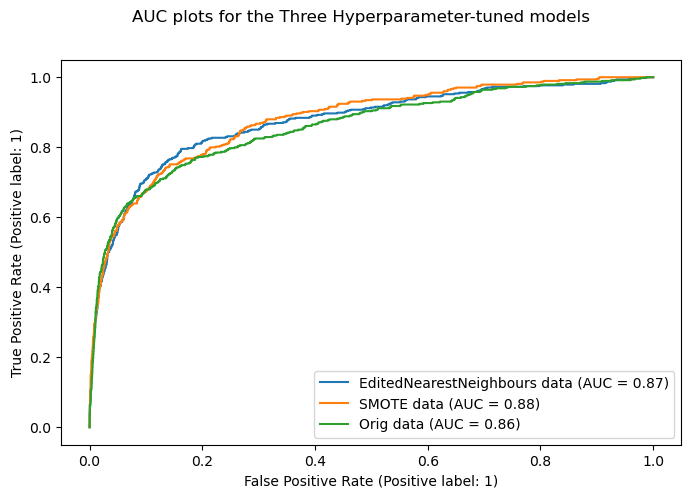

In [ ]:
# 19.9.5 Draw three AUC plots:

fig, ax = plt.subplots(1,1, figsize = (8,5), sharey = True, sharex = True);
fig.suptitle("AUC plots for the Three Hyperparameter-tuned models")
RocCurveDisplay.from_estimator(model_ht_en,
                               X_test_trans_imputed,
                               y_test,
                               ax = ax,
                               name = "EditedNearestNeighbours data"
                              );

RocCurveDisplay.from_estimator(model_ht_trans,
                               X_test_trans,
                               y_test,
                               ax = ax,
                               name = "SMOTE data"
                              );

RocCurveDisplay.from_estimator(model_ht_orig,
                               X_test,
                               y_test,
                               ax = ax,
                               name = "Orig data"
                              );

In [ ]:
## USELESS MAY BE DELETED
# 19.9.6 A comparative table

re1 = []
re2 = []
re3 = []
re4 = []
re5 = []
table = [re1,re2,re3,re4,re5]
re1.append("Modeling Original data")
re2.append("Modeling hypertuned--Original data")
re3.append("Modeling Transformed data")
re4.append("SMOTE transformed hypertuned data")
re5.append("EditedNearestNeighbours transformed hypertuned data")


# AUC first
re1.append(model_orig.best_score)
re2.append(roc_auc_score(y_test.values, model_ht_orig.predict_proba(X_test)[:,1]) )
re3.append(model_trans.best_score)
re4.append(roc_auc_score(y_test.values, model_ht_trans.predict_proba(test_trans.iloc[:,len(cat_cols):])[:,1] ))
re5.append(roc_auc_score(y_test.values, model_ht_en.predict_proba(test_trans_imputed)[:,1] ))

# f1-score next
re1.append(f1_score(y_test.values, model_orig.predict(X_test)))
re2.append(f1_score(y_test.values, model_ht_orig.predict(X_test)) )
re3.append(f1_score(y_test.values, model_trans.predict(test_trans.iloc[:,len(cat_cols):])))
re4.append(f1_score(y_test.values, model_ht_trans.predict(test_trans.iloc[:,len(cat_cols):])))
re5.append(f1_score(y_test.values, model_ht_en.predict(test_trans_imputed) ))

# Print table now
print(tabulate(table, headers= ['Modeling','AUC score', 'f1 score']))


Modeling                                               AUC score    f1 score
---------------------------------------------------  -----------  ----------
Modeling Original data                                  0.843582    0.378378
Modeling hypertuned--Original data                      0.827214    0.449198
Modeling Transformed data                               0.86349     0.319605
SMOTE transformed hypertuned data                       0.853955    0.501193
EditedNearestNeighbours transformed hypertuned data     0.867281    0.499414


## Distribution of transformed features:
Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

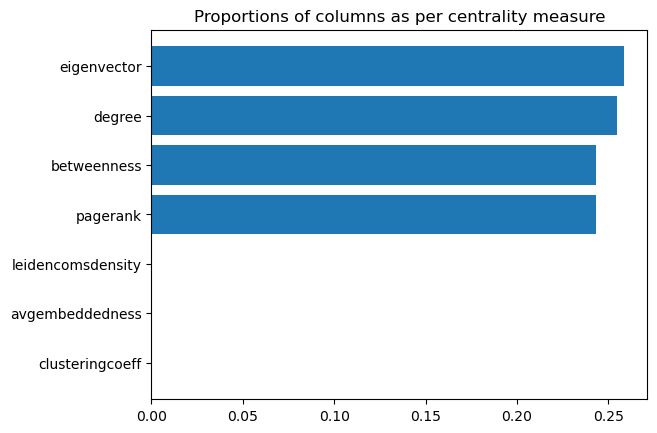

In [ ]:
# 20.0 Our list of columns

colList = X_train_trans.columns

# 20.0.1 Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
utils.plotSeries(f, "Proportions of columns as per centrality measure")

### Proportions of columns by centrality whose impt is > 0

In [ ]:
# 20.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'


'Columns whose impt is >0: 235'

'Columns whose impt is 0: 39'

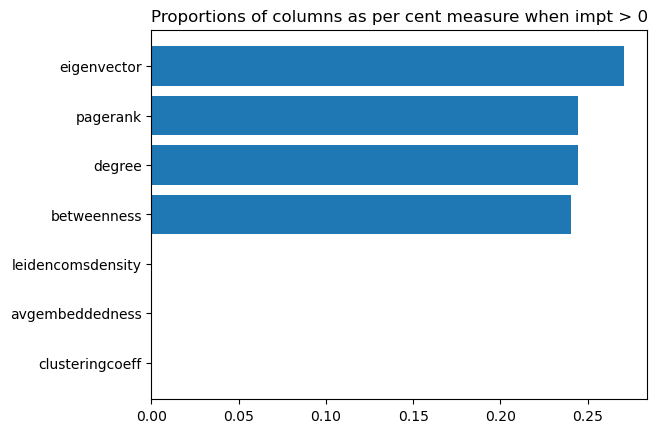

In [ ]:
# 20.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")

### Proportions of columns by summed-up importance score of each centrality measure

In [ ]:
# 20.3 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)



Order of feature importance is by 'gain'


In [ ]:
# 20.4 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 20.4.1 Score of top-five columns:
score[:5]

deg_rolerollupOne_ck_roledeptname    0.011473
pr_rolefamily_ck_rolerolluptwo       0.008963
pr_roledeptname_ck_rolerolluptwo     0.007898
bet_mgrid_ck_rolefamilydesc          0.007549
eig_roletitle_ck_rolerolluptwo       0.007252
Name: imp, dtype: float32

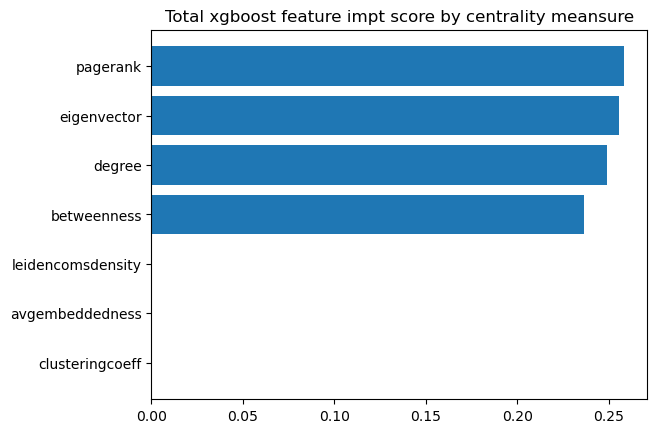

In [ ]:
# 20.5 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Derive unit-vectors per level per cat column

In [ ]:
##*****************************
## Embedding Projector
## related data
##*****************************

In [ ]:
# 21.0

X_train = pd.read_pickle(amazondata / "X_train.pkl")
X_test = pd.read_pickle(amazondata / "X_test.pkl")
y_train = pd.read_pickle(amazondata / "y_train.pkl")
y_test = pd.read_pickle(amazondata / "y_test.pkl")

train_trans = pd.read_pickle(amazondata / "train_trans.pkl")
test_trans = pd.read_pickle(amazondata / "test_trans.pkl")
ct = utils.restorePythonObject("transformer.pkl", amazondata)

In [ ]:
# 21.0.1
train_trans = train_trans.reset_index(drop = True)
test_trans = test_trans.reset_index(drop = True)

# 21.0.2 Reset index
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)


In [ ]:
# 21.1 Check for nulls:
train_trans.isnull().sum().sum()
test_trans.isnull().sum().sum()   # 16884/16000/55032

0

55032

In [ ]:
# 21.2 Impute test_trans
si = SimpleImputer(strategy = 'median')
si.fit(train_trans)
test_trans[:] = si.transform(test_trans)
# Check
test_trans.isnull().sum().sum()

SimpleImputer(strategy='median')

0

In [ ]:
# 21.3 Get target data col. Needed for generation of meta-data file:

test_trans['target'] = y_test
train_trans['target'] =  y_train

In [ ]:
# 21.4 Derive unit vectors:

p = Path(amazonunitvecs)
p.mkdir(parents=True, exist_ok=True)

vec_tr,_ = ct.vectorsToTSV(train_trans,
                           take_mean = False,
                           filepath = amazonunitvecs,   # Folder where csv files will be saved
                           saveVectorsToDisk = True
                           )

print("\n----test data---\n")

# 21.5 Unit vectors from test data. But not being saved to file:
vec_te,_ = ct.vectorsToTSV(test_trans,
                           take_mean = False,
                           filepath = amazonunitvecs,
                           impute = True,
                           saveVectorsToDisk = False
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for resource
Checked for mgrid
Checked for rolerollupOne
Checked for rolerolluptwo
Checked for roledeptname
Checked for roletitle
Checked for rolefamilydesc
Checked for rolefamily
Checked for rolecode
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: 'c:\amazon\allmodels\unitvectors'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature

----test data---

Checking if vectors exist for all cat cols...
May take time...
Checked for resource
Checked for mgrid
Checked for rolerollupOne
Checked for rolerolluptwo
Checked for roledeptname
Checked for roletitle
Checked for rolefamilydesc
Checked for rolefamily
Checked for rolecode


## Save unit-vectors files
Also save output dictionaries for later use

In [ ]:
# 21.6 Save dict:

utils.savePythonObject(vec_tr, "vec_tr.pkl", amazonunitvecs)
utils.savePythonObject(vec_te, "vec_te.pkl",amazonunitvecs)

Object saved to: c:\amazon\allmodels\unitvectors\vec_tr.pkl
Object saved to: c:\amazon\allmodels\unitvectors\vec_te.pkl


## Restore unit-vectors files

In [ ]:
# 21.7 Restore back:

vec_tr = utils.restorePythonObject( "vec_tr.pkl", amazonunitvecs)
vec_te = utils.restorePythonObject("vec_te.pkl",amazonunitvecs)

## Using unit vectors to transform train/test data

In [ ]:
# 22.0 USe unit vectors to transform train/test data:

cctr,ccte, vtr,vte = utils.pcaAndConcat(vec_tr, vec_te, n_components = 4)


Performing PCA for resource for train data
Performing PCA for resource for test data
Performing PCA for mgrid for train data
Performing PCA for mgrid for test data
Performing PCA for rolerollupOne for train data
Performing PCA for rolerollupOne for test data
Performing PCA for rolerolluptwo for train data
Performing PCA for rolerolluptwo for test data
Performing PCA for roledeptname for train data
Performing PCA for roledeptname for test data
Performing PCA for roletitle for train data
Performing PCA for roletitle for test data
Performing PCA for rolefamilydesc for train data
Performing PCA for rolefamilydesc for test data
Performing PCA for rolefamily for train data
Performing PCA for rolefamily for test data
Performing PCA for rolecode for train data
Performing PCA for rolecode for test data
Concatenating train data
Concatenating test data
Done......


In [ ]:
# 22.1

cctr.head(3)
ccte.head(3)

pcresource0  pcresource1  pcresource2  pcresource3  pcmgrid0  pcmgrid1  \
0    10.322662    -4.911528     2.692930    -2.786986 -1.688675  1.429940   
1    -4.559244    -0.070399     4.637089    -1.497379 -0.932447 -3.156298   
2    -2.428415    -0.299946    -2.090976    -0.831050 -0.517803 -0.623395   

   pcmgrid2  pcmgrid3  pcrolerollupOne0  pcrolerollupOne1  ...  \
0  1.696472 -0.149993         -3.084553          0.050155  ...   
1 -0.218511 -0.263696         -3.084566          0.050110  ...   
2 -1.619204 -0.794850         -3.084566          0.050129  ...   

   pcrolefamilydesc2  pcrolefamilydesc3  pcrolefamily0  pcrolefamily1  \
0          -0.252628           0.408301      -3.215069      -0.022879   
1          -0.247262          -0.620581       3.631488       3.896162   
2           0.480857          -0.460450       3.329176       3.093020   

   pcrolefamily2  pcrolefamily3  pcrolecode0  pcrolecode1  pcrolecode2  \
0      -0.445510      -0.229582    -3.017766    -1.216147    -0.125501   
1       1.764257      -0.270828     2.736449    -0.813268    -0.162035   
2      -0.123730      -1.467042     0.951072    -1.122176     0.000814   

   pcrolecode3  
0    -0.146602  
1    -0.851565  
2    -0.681264  

[3 rows x 36 columns]

pcresource0  pcresource1  pcresource2  pcresource3  pcmgrid0  pcmgrid1  \
0    -2.079090    -0.792969    -1.831032     0.261098 -1.713954 -2.724822   
1    -2.861647    -0.879076    -2.263344    -0.856989 -1.387103  1.316911   
2    -2.079090    -0.792969    -1.831032     0.261098 -1.663436  0.957320   

   pcmgrid2  pcmgrid3  pcrolerollupOne0  pcrolerollupOne1  ...  \
0 -1.145435  1.891090         -3.084565           0.05013  ...   
1  1.687785 -0.960507         -3.084565           0.05013  ...   
2  2.123962 -0.329963         -3.084565           0.05013  ...   

   pcrolefamilydesc2  pcrolefamilydesc3  pcrolefamily0  pcrolefamily1  \
0           0.815562          -0.596747       5.616850       3.863565   
1          -0.252623           0.408311      -3.215089      -0.022905   
2           0.309789          -0.555556      -3.215089      -0.022905   

   pcrolefamily2  pcrolefamily3  pcrolecode0  pcrolecode1  pcrolecode2  \
0       0.346608      -0.096761     2.387999    -1.893768     0.275207   
1      -0.445494      -0.229664    -3.017781    -1.216144    -0.125501   
2      -0.445494      -0.229664    -2.854048    -0.677453    -0.411242   

   pcrolecode3  
0    -0.896113  
1    -0.146623  
2    -0.168725  

[3 rows x 36 columns]

In [ ]:
# 22.2

cctr.shape   #  (24576, 36)
ccte.shape   #  (8193, 36)

(24576, 36)

(8193, 36)

In [ ]:
# 22.4 No target here

print(list(cctr.columns[:10]))
print(list(cctr.columns[10:20]))
print(list(cctr.columns[20:30]))
print(list(cctr.columns[30:]))


['pcresource0', 'pcresource1', 'pcresource2', 'pcresource3', 'pcmgrid0', 'pcmgrid1', 'pcmgrid2', 'pcmgrid3', 'pcrolerollupOne0', 'pcrolerollupOne1']
['pcrolerollupOne2', 'pcrolerollupOne3', 'pcrolerolluptwo0', 'pcrolerolluptwo1', 'pcrolerolluptwo2', 'pcrolerolluptwo3', 'pcroledeptname0', 'pcroledeptname1', 'pcroledeptname2', 'pcroledeptname3']
['pcroletitle0', 'pcroletitle1', 'pcroletitle2', 'pcroletitle3', 'pcrolefamilydesc0', 'pcrolefamilydesc1', 'pcrolefamilydesc2', 'pcrolefamilydesc3', 'pcrolefamily0', 'pcrolefamily1']
['pcrolefamily2', 'pcrolefamily3', 'pcrolecode0', 'pcrolecode1', 'pcrolecode2', 'pcrolecode3']


### Save unitvectors transformed train/test

In [ ]:
# 22.5 Save cctr/ccte

cctr.to_pickle(amazondata / "cctr.pkl")
ccte.to_pickle(amazondata / "ccte.pkl")

### Readback unitvectors transformed train/test

In [ ]:
# 22.6 Read back cctr/ccte
cctr = pd.read_pickle(amazondata / "cctr.pkl")
ccte = pd.read_pickle(amazondata / "ccte.pkl")
y_train = pd.read_pickle(amazondata / "y_train.pkl")
y_test = pd.read_pickle(amazondata / "y_test.pkl")

# 22.6.1 Check
cctr.head(2)
ccte.head(2)
cctr.shape # (24576, 32)
ccte.shape # (8193, 32)

pcresource0  pcresource1  pcresource2  pcresource3  pcmgrid0  pcmgrid1  \
0    10.322662    -4.911528     2.692930    -2.786986 -1.688675  1.429940   
1    -4.559244    -0.070399     4.637089    -1.497379 -0.932447 -3.156298   

   pcmgrid2  pcmgrid3  pcrolerollupOne0  pcrolerollupOne1  ...  \
0  1.696472 -0.149993         -3.084553          0.050155  ...   
1 -0.218511 -0.263696         -3.084566          0.050110  ...   

   pcrolefamilydesc2  pcrolefamilydesc3  pcrolefamily0  pcrolefamily1  \
0          -0.252628           0.408301      -3.215069      -0.022879   
1          -0.247262          -0.620581       3.631488       3.896162   

   pcrolefamily2  pcrolefamily3  pcrolecode0  pcrolecode1  pcrolecode2  \
0      -0.445510      -0.229582    -3.017766    -1.216147    -0.125501   
1       1.764257      -0.270828     2.736449    -0.813268    -0.162035   

   pcrolecode3  
0    -0.146602  
1    -0.851565  

[2 rows x 36 columns]

pcresource0  pcresource1  pcresource2  pcresource3  pcmgrid0  pcmgrid1  \
0    -2.079090    -0.792969    -1.831032     0.261098 -1.713954 -2.724822   
1    -2.861647    -0.879076    -2.263344    -0.856989 -1.387103  1.316911   

   pcmgrid2  pcmgrid3  pcrolerollupOne0  pcrolerollupOne1  ...  \
0 -1.145435  1.891090         -3.084565           0.05013  ...   
1  1.687785 -0.960507         -3.084565           0.05013  ...   

   pcrolefamilydesc2  pcrolefamilydesc3  pcrolefamily0  pcrolefamily1  \
0           0.815562          -0.596747       5.616850       3.863565   
1          -0.252623           0.408311      -3.215089      -0.022905   

   pcrolefamily2  pcrolefamily3  pcrolecode0  pcrolecode1  pcrolecode2  \
0       0.346608      -0.096761     2.387999    -1.893768     0.275207   
1      -0.445494      -0.229664    -3.017781    -1.216144    -0.125501   

   pcrolecode3  
0    -0.896113  
1    -0.146623  

[2 rows x 36 columns]

(24576, 36)

(8193, 36)

## xgboost modeling of unitvectors data

In [ ]:
# 22.7 Perform xgboost modeling using the above train/test data:

model_vec = xgb.XGBClassifier( n_estimators= 250,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = rng,
                              reg_lambda = 1.5,
                           )


tr_X =    cctr
test_X =  ccte
ytrain =  y_train
ytest = y_test


model_vec.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[10:51:32] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[10:51:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.72073	validation_1-auc:0.66677
[10:51:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.73004	validation_1-auc:0.68181
[10:51:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.75680	validation_1-auc:0.70524
[10:51:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 348 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.79537	validati

[10:51:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 698 extra nodes, 0 pruned nodes, max_depth=13
[36]	validation_0-auc:0.97624	validation_1-auc:0.84640
[10:51:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 766 extra nodes, 0 pruned nodes, max_depth=13
[37]	validation_0-auc:0.97804	validation_1-auc:0.84686
[10:51:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 732 extra nodes, 0 pruned nodes, max_depth=13
[38]	validation_0-auc:0.97954	validation_1-auc:0.84745
[10:51:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 596 extra nodes, 0 pruned nodes, max_depth=13
[39]	validation_0-auc:0.98028	validation_1-auc:0.84877
[10:51:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.99415	validation_1-auc:0.85889
[10:51:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=13
[73]	validation_0-auc:0.99430	validation_1-auc:0.85879
[10:51:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 620 extra nodes, 0 pruned nodes, max_depth=13
[74]	validation_0-auc:0.99448	validation_1-auc:0.85907
[10:51:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 440 extra nodes, 0 pruned nodes, max_depth=13
[75]	validation_0-auc:0.99464	validation_1-auc:0.85877
[10:51:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=13
[76]	validation_0-auc:0.99472	validation_1-auc:0.85859
[10:51:34] INFO: C:\Users\dev-admin\croot2\xg

[10:51:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=13
[110]	validation_0-auc:0.99731	validation_1-auc:0.86188
[10:51:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=13
[111]	validation_0-auc:0.99740	validation_1-auc:0.86179
[10:51:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=13
[112]	validation_0-auc:0.99743	validation_1-auc:0.86173
[10:51:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=13
[113]	validation_0-auc:0.99751	validation_1-auc:0.86176
[10:51:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[146]	validation_0-auc:0.99868	validation_1-auc:0.86301
[10:51:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=13
[147]	validation_0-auc:0.99870	validation_1-auc:0.86304
[10:51:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=13
[148]	validation_0-auc:0.99872	validation_1-auc:0.86319
[10:51:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=13
[149]	validation_0-auc:0.99873	validation_1-auc:0.86302
[10:51:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=13
[150]	validation_0-auc:0.99874	validation_1-auc:0.86313
[10:51:35] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.99932	validation_1-auc:0.86397
[10:51:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=13
[184]	validation_0-auc:0.99933	validation_1-auc:0.86369
[10:51:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=13
[185]	validation_0-auc:0.99934	validation_1-auc:0.86372
[10:51:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=13
[186]	validation_0-auc:0.99935	validation_1-auc:0.86372
[10:51:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=13
[187]	validation_0-auc:0.99935	validation_1-auc:0.86382
[10:51:36] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 22.7.1 Save estimator: model_vec
utils.savePythonObject(model_vec, "model_vec.pkl", amazonestimators )

Object saved to: c:\amazon\allmodels\estimators\model_vec.pkl


In [ ]:
# 22.7.2 Read back saved estimator:
model_vec = utils.restorePythonObject("model_vec.pkl", amazonestimators )

In [ ]:
# 22.7.5 Best scores:

model_vec.best_score   # 0.84985279350/0.85893922771/0.856534481/0.8641616964660056
print("\n")
model_vec.best_iteration  # 70/71/74/84/142


0.8641616964660056

142

#### Classification report

In [ ]:
# 23.0 Classification report:

pred_vec = model_vec.predict(test_X)
print(classification_report(ytest,pred_vec))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7719
           1       0.68      0.22      0.33       474

    accuracy                           0.95      8193
   macro avg       0.82      0.60      0.65      8193
weighted avg       0.94      0.95      0.94      8193



#### Learning curve

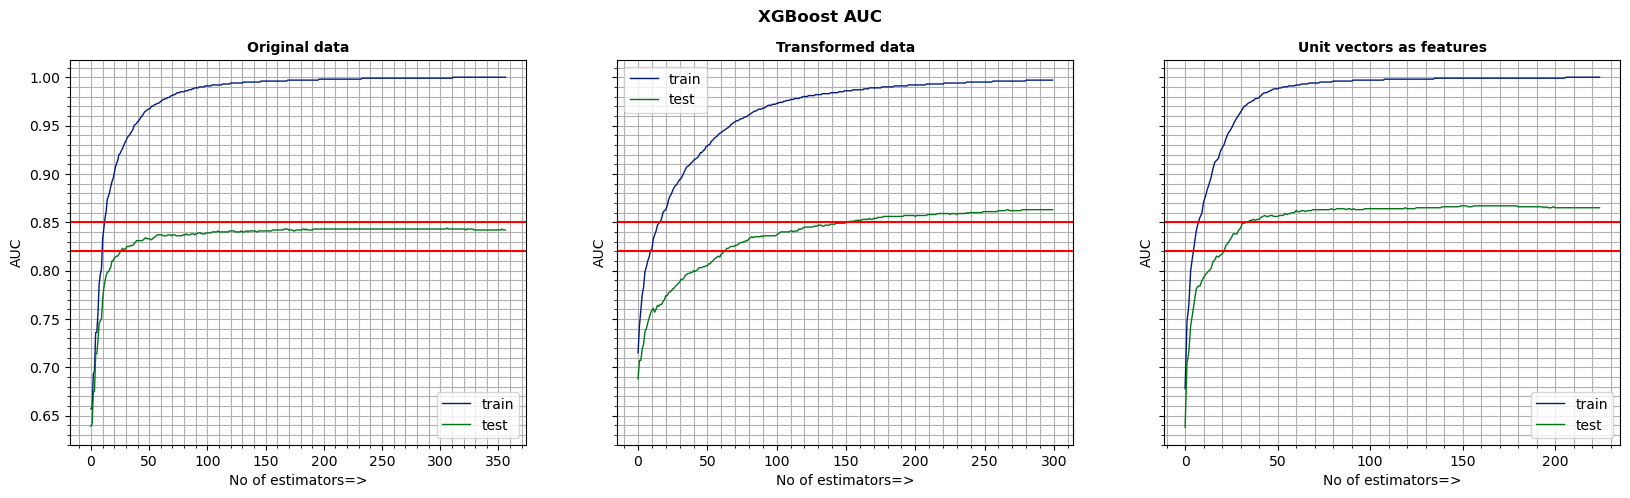

In [ ]:
# 23.1
plt.style.use("default")
plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515

fig, ax = plt.subplots(1,3, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(),model_trans.evals_result(),   model_vec.evals_result() ]
title = ["Original data", 'Transformed data', 'Unit vectors as features']
fig.suptitle("XGBoost AUC", fontweight = "bold")
for i in range(3):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 10, fontweight = "bold");
    ax[i].axhline(y = 0.82, color = 'r', linestyle = '-')
    ax[i].axhline(y = 0.85, color = 'r', linestyle = '-')

plt.show();

In [ ]:
# 24.0 A comparative table

re1 = []
re2 = []
re3 = []
re4 = []
re5 = []
re6 = []
table = [re1,re2,re3,re4,re5,re6]
re1.append("Modeling Original data")
re2.append("Modeling hypertuned--Original data")
re3.append("Modeling Transformed data")
re4.append("SMOTE transformed hypertuned data")
re5.append("EditedNearestNeighbours transformed hypertuned data")
re6.append("Modeling unitvectors data")


# AUC first
re1.append(model_orig.best_score)
re2.append(roc_auc_score(y_test.values, model_ht_orig.predict_proba(X_test)[:,1]) )
re3.append(model_trans.best_score)
re4.append(roc_auc_score(y_test.values, model_ht_trans.predict_proba(test_trans.iloc[:,len(cat_cols):])[:,1] ))
re5.append(roc_auc_score(y_test.values, model_ht_en.predict_proba(test_trans_imputed)[:,1] ))
re6.append(roc_auc_score(y_test.values, model_vec.predict_proba(ccte)[:,1]))

# f1-score next
re1.append(f1_score(y_test.values, model_orig.predict(X_test)))
re2.append(f1_score(y_test.values, model_ht_orig.predict(X_test)) )
re3.append(f1_score(y_test.values, model_trans.predict(test_trans.iloc[:,len(cat_cols):])))
re4.append(f1_score(y_test.values, model_ht_trans.predict(test_trans.iloc[:,len(cat_cols):])))
re5.append(f1_score(y_test.values, model_ht_en.predict(test_trans_imputed) ))
re6.append(f1_score(y_test.values, model_vec.predict(ccte)))

# Print table now
print(tabulate(table, headers= ['Modeling','AUC score', 'f1 score']))


### Experimenting only with pc0 of unitvectors
We take Ist principal component of each set of unitvectors and perform modeling with them.

In [ ]:
# 24.1 Columns containing only Ist PCs:
cols = [i for i in cctr.columns if '0' in i]
print(cols)
len(cols)  # 9

['pcresource0', 'pcmgrid0', 'pcrolerollupOne0', 'pcrolerolluptwo0', 'pcroledeptname0', 'pcroletitle0', 'pcrolefamilydesc0', 'pcrolefamily0', 'pcrolecode0']


9

In [ ]:
# 24.2 How good are pc0's of respective unit vectors and which one is most important?
#      Time features are not included.S

model_vec_pc0 = xgb.XGBClassifier( n_estimators= 500,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 10,
                              subsample = 0.9,
                              random_state = rng,
                              reg_lambda = 1.5,
                           )


tr_X =    cctr[cols]
test_X =  ccte[cols]
ytrain =  y_train
ytest = y_test


model_vec_pc0.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[11:06:32] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[11:06:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.67782	validation_1-auc:0.64697
[11:06:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.71255	validation_1-auc:0.68067
[11:06:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.71474	validation_1-auc:0.67983
[11:06:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.73845	validati

[11:06:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 438 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.93261	validation_1-auc:0.81899
[11:06:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.93385	validation_1-auc:0.81861
[11:06:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 346 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.93493	validation_1-auc:0.81906
[11:06:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.93564	validation_1-auc:0.82012
[11:06:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[11:06:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.96387	validation_1-auc:0.83973
[11:06:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.96458	validation_1-auc:0.83960
[11:06:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.96467	validation_1-auc:0.83913
[11:06:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.96565	validation_1-auc:0.84017
[11:06:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[11:06:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.97812	validation_1-auc:0.84586
[11:06:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.97833	validation_1-auc:0.84595
[11:06:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.97853	validation_1-auc:0.84569
[11:06:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.97872	validation_1-auc:0.84551
[11:06:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[146]	validation_0-auc:0.98502	validation_1-auc:0.84643
[11:06:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.98524	validation_1-auc:0.84664
[11:06:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.98536	validation_1-auc:0.84646
[11:06:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.98553	validation_1-auc:0.84677
[11:06:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.98572	validation_1-auc:0.84668
[11:06:34] INFO: C:\Users\dev-admin\croo

[11:06:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.98967	validation_1-auc:0.84747
[11:06:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.98971	validation_1-auc:0.84758
[11:06:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.98980	validation_1-auc:0.84742
[11:06:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.98989	validation_1-auc:0.84747
[11:06:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[220]	validation_0-auc:0.99215	validation_1-auc:0.84849
[11:06:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.99222	validation_1-auc:0.84858
[11:06:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.99227	validation_1-auc:0.84855
[11:06:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=10
[223]	validation_0-auc:0.99239	validation_1-auc:0.84863
[11:06:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=10
[224]	validation_0-auc:0.99252	validation_1-auc:0.84863
[11:06:35] INFO: C:\Users\dev-admin\croo

[257]	validation_0-auc:0.99428	validation_1-auc:0.84865
[11:06:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=10
[258]	validation_0-auc:0.99431	validation_1-auc:0.84865
[11:06:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=10
[259]	validation_0-auc:0.99436	validation_1-auc:0.84850
[11:06:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=10
[260]	validation_0-auc:0.99439	validation_1-auc:0.84850
[11:06:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=10
[261]	validation_0-auc:0.99443	validation_1-auc:0.84861
[11:06:36] INFO: C:\Users\dev-admin\croo

[294]	validation_0-auc:0.99561	validation_1-auc:0.84946
[11:06:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=10
[295]	validation_0-auc:0.99563	validation_1-auc:0.84928
[11:06:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=10
[296]	validation_0-auc:0.99565	validation_1-auc:0.84933
[11:06:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=10
[297]	validation_0-auc:0.99567	validation_1-auc:0.84938
[11:06:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=10
[298]	validation_0-auc:0.99569	validation_1-auc:0.84922
[11:06:36] INFO: C:\Users\dev-admin\croo

[331]	validation_0-auc:0.99657	validation_1-auc:0.85009
[11:06:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=10
[332]	validation_0-auc:0.99660	validation_1-auc:0.85026
[11:06:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=10
[333]	validation_0-auc:0.99660	validation_1-auc:0.85021
[11:06:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=10
[334]	validation_0-auc:0.99662	validation_1-auc:0.85015
[11:06:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=10
[335]	validation_0-auc:0.99665	validation_1-auc:0.85001
[11:06:37] INFO: C:\Users\dev-admin\croo

[368]	validation_0-auc:0.99730	validation_1-auc:0.85012
[11:06:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 296 extra nodes, 0 pruned nodes, max_depth=10
[369]	validation_0-auc:0.99732	validation_1-auc:0.85020
[11:06:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=10
[370]	validation_0-auc:0.99734	validation_1-auc:0.85030
[11:06:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=10
[371]	validation_0-auc:0.99735	validation_1-auc:0.85036
[11:06:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=10
[372]	validation_0-auc:0.99735	validation_1-auc:0.85035
[11:06:37] INFO: C:\Users\dev-admin\croot

[405]	validation_0-auc:0.99786	validation_1-auc:0.85030
[11:06:38] ======== Monitor (0): Learner ========
[11:06:38] Configure: 0.00042s, 1 calls @ 420us

[11:06:38] EvalOneIter: 1.57801s, 406 calls @ 1578008us

[11:06:38] GetGradient: 0.031959s, 406 calls @ 31959us

[11:06:38] PredictRaw: 0.001195s, 406 calls @ 1195us

[11:06:38] UpdateOneIter: 3.6049s, 406 calls @ 3604896us

[11:06:38] ======== Monitor (0): GBTree ========
[11:06:38] BoostNewTrees: 3.5653s, 406 calls @ 3565304us

[11:06:38] CommitModel: 0.000214s, 406 calls @ 214us

[11:06:38] ======== Monitor (0): TreePruner ========
[11:06:38] PrunerUpdate: 0.067997s, 406 calls @ 67997us



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 24.3. Save model:

utils.savePythonObject(model_vec_pc0, "model_vec_pc0.pkl", amazonestimators )

Object saved to: c:\amazon\allmodels\estimators\model_vec_pc0.pkl


In [ ]:
# 24.4 Restore model:

model_vec_pc0 = utils.restorePythonObject("model_vec_pc0.pkl", amazonestimators )

In [ ]:
# 24.5 Best scores:

model_vec_pc0.best_score   # 0.8544611274825722
print("\n")
model_vec_pc0.best_iteration  # 258

0.8505517920327014

355

In [ ]:
# 24.6 Classification report:

pred_vec = model_vec_pc0.predict(test_X)
uvec_cl=classification_report(ytest,pred_vec)
print(uvec_cl)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7719
           1       0.69      0.25      0.37       474

    accuracy                           0.95      8193
   macro avg       0.82      0.62      0.67      8193
weighted avg       0.94      0.95      0.94      8193



In [ ]:
# 25.0 A comparative table

re1 = []
re2 = []
re3 = []
re4 = []
re5 = []
re6 = []
re7 = []
cols = ['pcresource0', 'pcmgrid0', 'pcrolerollupOne0', 'pcrolerolluptwo0', 'pcroledeptname0', 'pcroletitle0', 'pcrolefamilydesc0', 'pcrolefamily0', 'pcrolecode0']
table = [re1,re2,re3,re4,re5,re6,re7]

str1 = "Modeling Original data"
str2 = "Modeling hypertuned--Original data"
str3 = "Modeling Transformed data"
str4 = "SMOTE transformed hypertuned data"
str5 = "EditedNearestNeighbours transformed hypertuned data"
str6 = "Modeling unitvectors data"
str7 = "Modeling unitvectors data--Only pc0s"

re1.append(str1)
re2.append(str2)
re3.append(str3)
re4.append(str4)
re5.append(str5)
re6.append(str6)
re7.append(str7)


# AUC first
s1 = model_orig.best_score
s2= roc_auc_score(y_test.values, model_ht_orig.predict_proba(X_test)[:,1])
s3 = model_trans.best_score
s4 = roc_auc_score(y_test.values, model_ht_trans.predict_proba(test_trans.iloc[:,len(cat_cols):])[:,1] )
s5 = roc_auc_score(y_test.values, model_ht_en.predict_proba(test_trans_imputed)[:,1] )
s6 = roc_auc_score(y_test.values, model_vec.predict_proba(ccte)[:,1])
s7 = roc_auc_score(y_test.values, model_vec_pc0.predict_proba(ccte[cols])[:,1])

re1.append(s1)
re2.append(s2 )
re3.append(s3)
re4.append(s4)
re5.append(s5)
re6.append(s6)
re7.append(s7)

# f1-score next
f1 = f1_score(y_test.values, model_orig.predict(X_test))
f2 = f1_score(y_test.values, model_ht_orig.predict(X_test))
f3 = f1_score(y_test.values, model_trans.predict(test_trans.iloc[:,len(cat_cols):]))
f4 = f1_score(y_test.values, model_ht_trans.predict(test_trans.iloc[:,len(cat_cols):]))
f5 = f1_score(y_test.values, model_ht_en.predict(test_trans_imputed) )
f6 = f1_score(y_test.values, model_vec.predict(ccte))
f7 = f1_score(y_test.values, model_vec_pc0.predict(ccte[cols]))

re1.append(f1)
re2.append(f2)
re3.append(f3)
re4.append(f4)
re5.append(f5)
re6.append(f6)
re7.append(f7)

# Print table now
print(tabulate(table, headers= ['Modeling','AUC score', 'f1 score']))


Modeling                                               AUC score    f1 score
---------------------------------------------------  -----------  ----------
Modeling Original data                                  0.843582    0.378378
Modeling hypertuned--Original data                      0.827214    0.449198
Modeling Transformed data                               0.86349     0.328947
SMOTE transformed hypertuned data                       0.849569    0.509756
EditedNearestNeighbours transformed hypertuned data     0.867281    0.499414
Modeling unitvectors data                               0.864162    0.327448
Modeling unitvectors data--Only pc0s                    0.850552    0.368421


In [ ]:
out = pd.DataFrame({"AUC score": [s1,s2,s3,s4,s5,s6,s7] ,
                   "f1 score" : [f1,f2,f3,f4,f5,f6,f7]},
                   index = [str1,str2,str3,str4,str5,str6,str7])
out

AUC score  f1 score
Modeling Original data                               0.843582  0.378378
Modeling hypertuned--Original data                   0.827214  0.449198
Modeling Transformed data                            0.863490  0.328947
SMOTE transformed hypertuned data                    0.849569  0.509756
EditedNearestNeighbours transformed hypertuned ...   0.867281  0.499414
Modeling unitvectors data                            0.864162  0.327448
Modeling unitvectors data--Only pc0s                 0.850552  0.368421

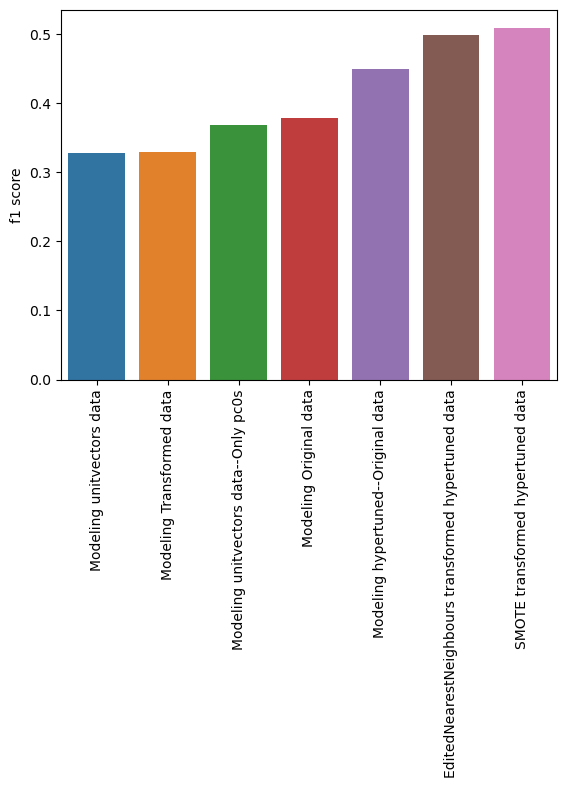

In [ ]:
# 25.0.1 And here is a quick comparison of f1-scores

out = out.sort_values('f1 score')
_=sns.barplot(x = out.index, y="f1 score", data=out)
_=plt.xticks(rotation=90)

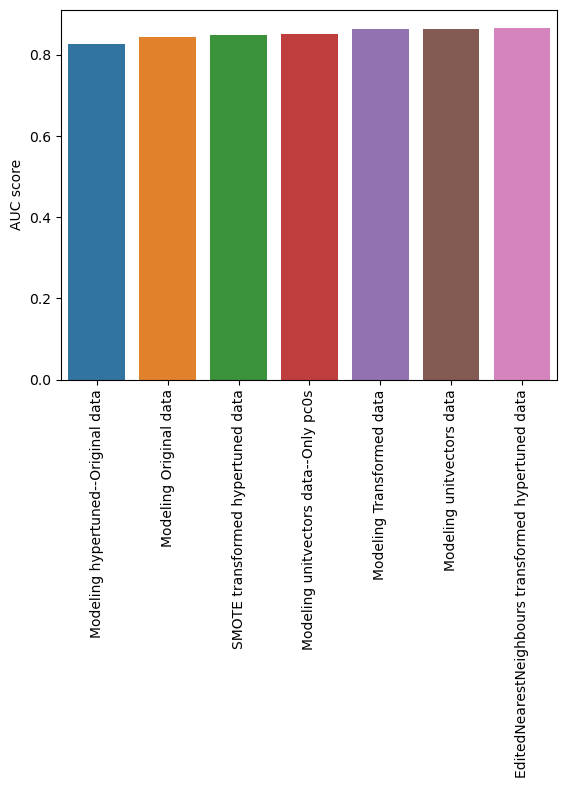

In [ ]:
# 25.0.2 And here is a quick comparison of AUC scores
#        Differences here are not much:

out = out.sort_values('AUC score')
_=sns.barplot(x = out.index, y="AUC score", data=out)
_=plt.xticks(rotation=90)

### Similarity in feature importance
There is a good degree of similarity in feature importance from that obtained by unitvectors approach and that by using original data.

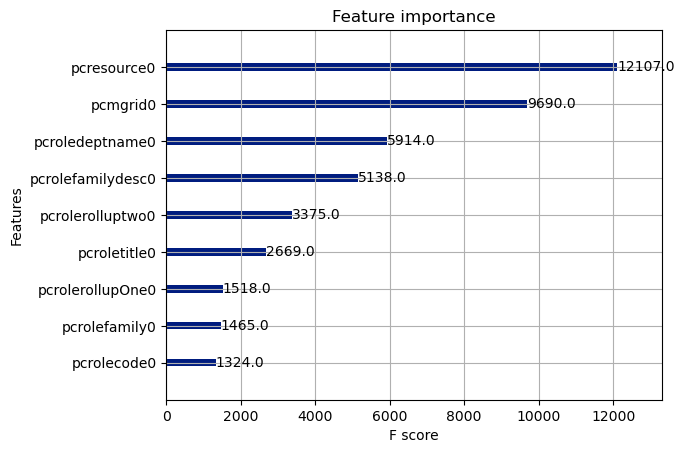

In [ ]:
# 25.1 Which PC0 columns have high xgboost impt
_=xgb.plot_importance(model_vec_pc0)

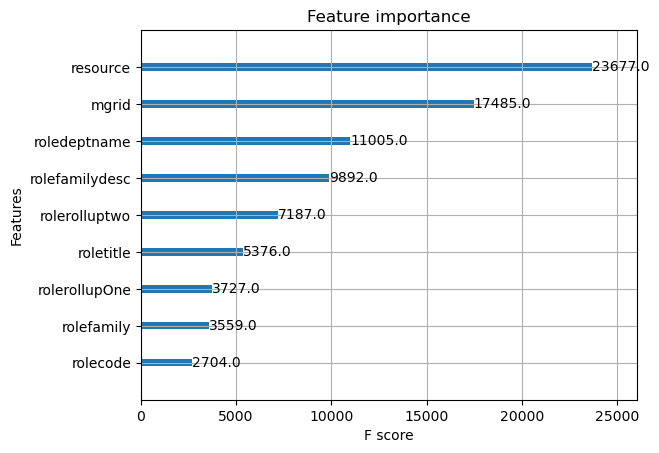

In [ ]:
# 25.1 Which cat columns have high xgboost impt
_=xgb.plot_importance(model_orig)

### Density plots of PC0s
Considering one-to-one similarity between PC0s and the cat-columns, we are encouraged to look at the density plots of PC0s and from their try to make out how importamnt each cat-column is in predictive power. We observe that standing alone none of the cat-columns is as important but together their importance in discriminating between target 0 and 1 increases.

In [ ]:
# 26.0
cctr['target']= y_train.reset_index(drop = True)
cols = ['pcresource0', 'pcmgrid0', 'pcrolerollupOne0',
        'pcrolerolluptwo0', 'pcroledeptname0', 'pcroletitle0',
        'pcrolefamilydesc0', 'pcrolefamily0', 'pcrolecode0']
print(cols)

['pcresource0', 'pcmgrid0', 'pcrolerollupOne0', 'pcrolerolluptwo0', 'pcroledeptname0', 'pcroletitle0', 'pcrolefamilydesc0', 'pcrolefamily0', 'pcrolecode0']


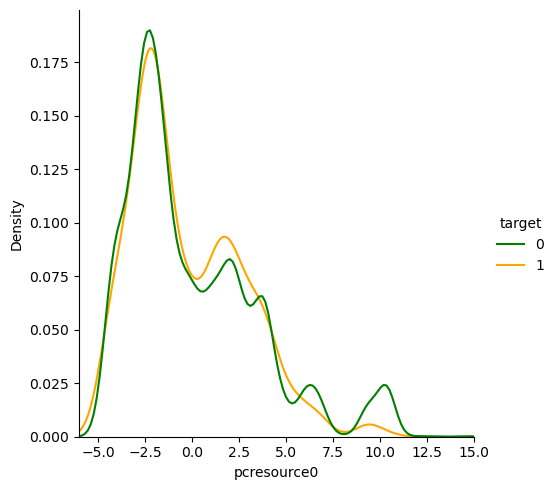

In [ ]:
# 26.1 Density plot of 'pcresource0':
_=sns.displot(cctr, x="pcresource0", hue="target", kind = "kde", palette = ["green", "orange"], common_norm = False)
_=plt.xlim(-6, 15)

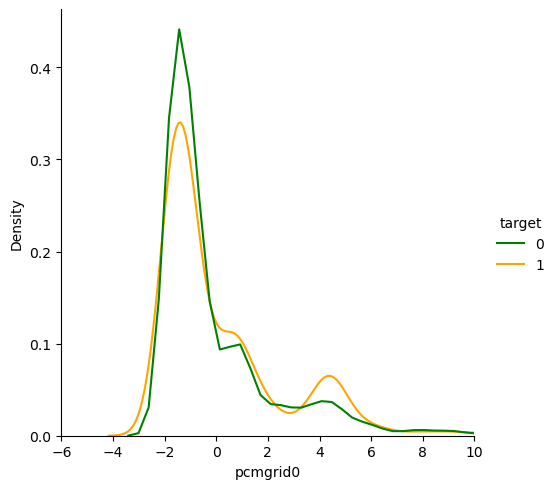

In [ ]:
# 26.2 Density plot of 'pcmgrid0':

_=sns.displot(cctr, x="pcmgrid0", hue="target", kind = "kde", common_norm = False, palette = ["green", "orange"])
_=plt.xlim(-6, 10)

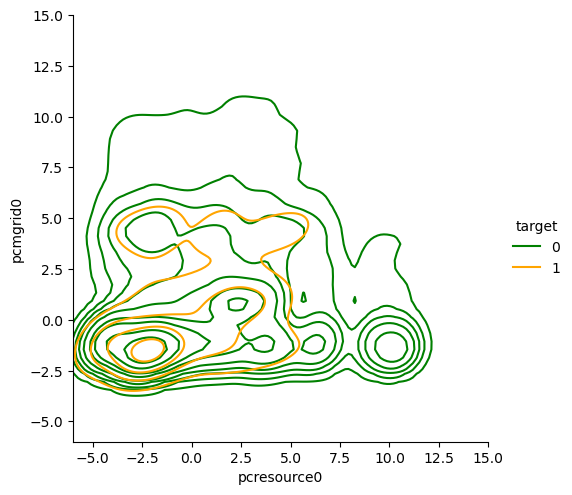

In [ ]:
# 26.3 2D Plot of pcresource0 vs pcmgrid0
_= sns.displot(data=cctr, x="pcresource0", y="pcmgrid0", hue = 'target', kind = "kde", palette = ['green', 'orange'])
_=plt.xlim(-6, 15)
_=plt.ylim(-6, 15)

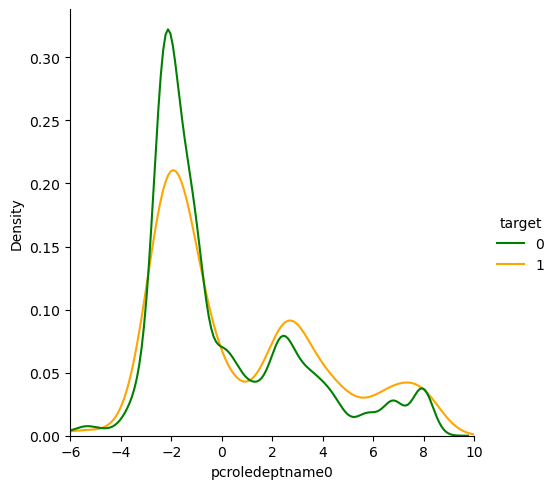

In [ ]:
# 26.4 Density plot of 'pcroledeptname0':

#_=plt.clf()
_=sns.displot(cctr, x="pcroledeptname0", hue="target", kind = "kde", common_norm = False, palette = ["green", "orange"])
_=plt.xlim(-6, 10)

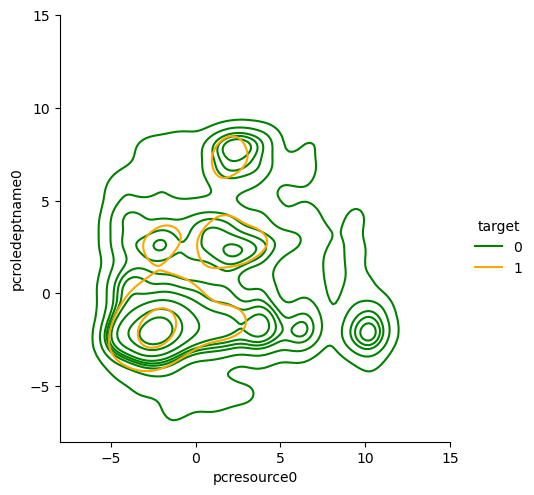

In [ ]:
# 26.5 2D plot of pcresource0 and pcroledeptname0:

_=sns.displot(data=cctr, x="pcresource0", y="pcroledeptname0", hue = 'target', kind = "kde", palette = ['green', 'orange'])
_=plt.xlim(-8, 15)
_=plt.ylim(-8, 15)

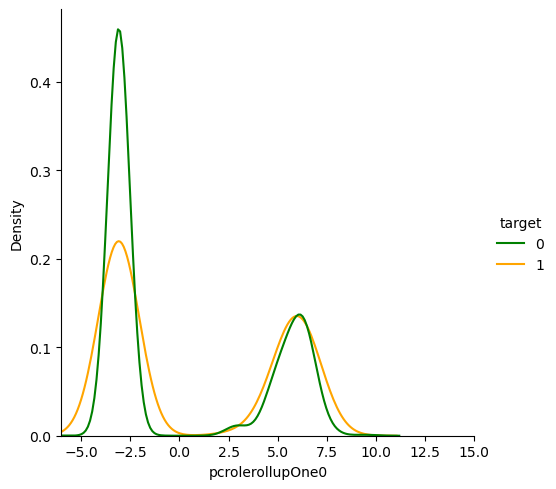

In [ ]:
# 26.6 Density plot of 'pcrolerollupOne0':

#_=plt.clf()
_=sns.displot(cctr, x="pcrolerollupOne0", hue="target", kind = "kde", common_norm = False, palette = ["green", "orange"])
_=plt.xlim(-6, 15)

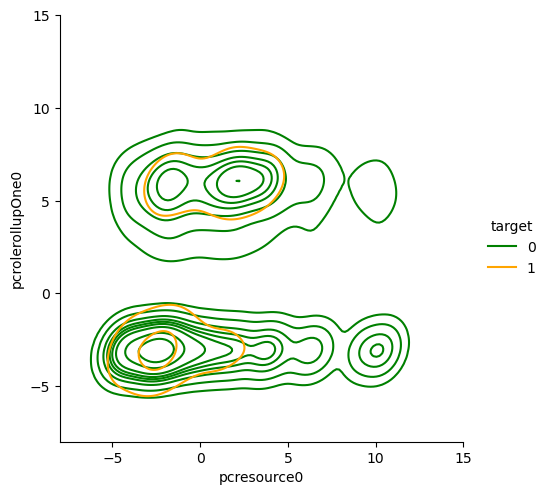

In [ ]:
# 26.7 2D density plot of pcresource0 and pcrolerollupOne0
_=sns.displot(data=cctr, x="pcresource0", y="pcrolerollupOne0", hue = 'target', kind = "kde", palette = ['green', 'orange'])
_=plt.xlim(-8, 15)
_=plt.ylim(-8, 15)

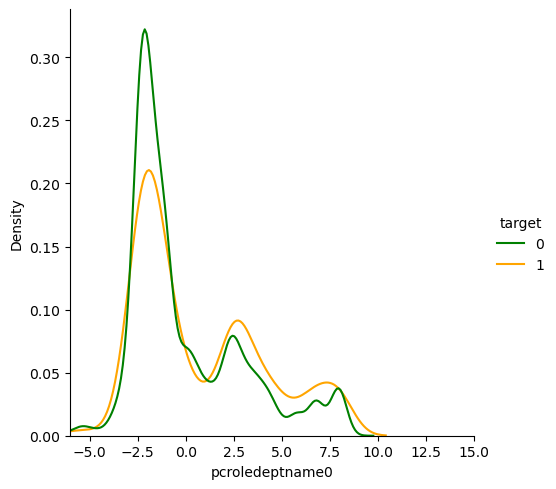

In [ ]:
# 26.8 Density plot of 'pcroledeptname0':

#_=plt.clf()
_=sns.displot(cctr, x="pcroledeptname0", hue="target", kind = "kde", common_norm = False, palette = ["green", "orange"])
_=plt.xlim(-6, 15)

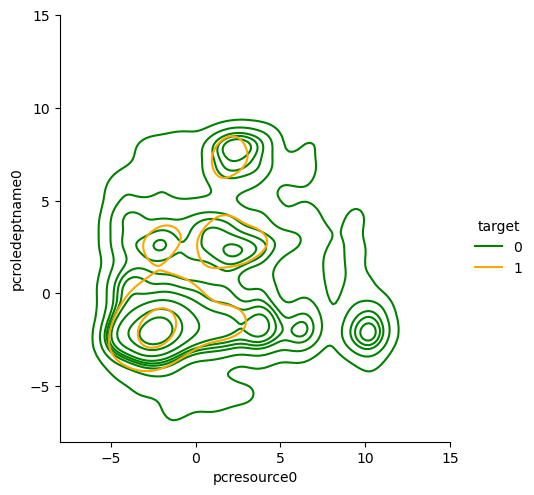

In [ ]:
# 26.9 2D density plot of pcresource0 and pcroledeptname0:
_=sns.displot(data=cctr, x="pcresource0", y="pcroledeptname0", hue = 'target', kind = "kde", palette = ['green', 'orange'])
_=plt.xlim(-8, 15)
_=plt.ylim(-8, 15)

### xgboost modeling of unitvectors with only pc0 features

In [ ]:
# 27.0 Call imblearn library:
#       We find EditedNearestNeighbours the best in this case

from imblearn.under_sampling import EditedNearestNeighbours,OneSidedSelection,AllKNN
from imblearn.combine import SMOTEENN

In [ ]:
# 27.1 Undersample/cleanup unitvectors data:

undersample = EditedNearestNeighbours()
X_res_pc0, y_res_pc0 = undersample.fit_resample(cctr[cols], y_train.values)


# 27.1.1 Data shape
X_res_pc0.shape  #  (3737267, 5)
y_res_pc0.shape  #  (3737267,)

(22077, 9)

(22077,)

In [ ]:
# 27.1.2 Save above files
X_res_pc0.to_pickle(amazondata / "X_res_pc0.pkl")
y_res_pc0 = pd.DataFrame(y_res_pc0, columns= [ 'action'])
y_res_pc0.to_pickle(amazondata / "y_res_pc0.pkl")
gc.collect()

96

In [ ]:
# 27.1.3 Read back
X_res_pc0 = pd.read_pickle(amazondata / "X_res_pc0.pkl")
y_res_pc0 = pd.read_pickle(amazondata / "y_res_pc0.pkl")
y_res_pc0.value_counts(normalize = True) # 99.75 : 0.25
y_train.value_counts(normalize = True) # 99.75:0.25

action
0         0.935544
1         0.064456
dtype: float64

0    0.942098
1    0.057902
Name: action, dtype: float64

In [ ]:
# 27.2 xgboost Modeling with undersampled data
gc.collect()
model_res_pc0 = xgb.XGBClassifier( n_estimators= 400,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 10,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_res_pc0
test_X = ccte[cols]
ytrain = y_res_pc0
ytest =  y_test


model_res_pc0.fit(tr_X, ytrain.values,
          early_stopping_rounds = 100,
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']
          )

0

[11:13:04] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[11:13:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.72669	validation_1-auc:0.68149
[11:13:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.76954	validation_1-auc:0.70471
[11:13:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.77391	validation_1-auc:0.70333
[11:13:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.79500	validati

[11:13:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.95764	validation_1-auc:0.83555
[11:13:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.95892	validation_1-auc:0.83578
[11:13:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 364 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.96077	validation_1-auc:0.83601
[11:13:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.96205	validation_1-auc:0.83598
[11:13:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.98152	validation_1-auc:0.84583
[11:13:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.98152	validation_1-auc:0.84579
[11:13:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.98170	validation_1-auc:0.84553
[11:13:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.98191	validation_1-auc:0.84534
[11:13:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.98211	validation_1-auc:0.84505
[11:13:05] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.98953	validation_1-auc:0.84813
[11:13:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.98972	validation_1-auc:0.84791
[11:13:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.99001	validation_1-auc:0.84799
[11:13:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.99014	validation_1-auc:0.84803
[11:13:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.99033	validation_1-auc:0.84843
[11:13:06] INFO: C:\Users\dev-admin\croo

[11:13:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.99461	validation_1-auc:0.85114
[11:13:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.99467	validation_1-auc:0.85145
[11:13:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.99469	validation_1-auc:0.85138
[11:13:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.99473	validation_1-auc:0.85114
[11:13:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune

[11:13:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.99690	validation_1-auc:0.85227
[11:13:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.99696	validation_1-auc:0.85247
[11:13:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.99697	validation_1-auc:0.85214
[11:13:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.99701	validation_1-auc:0.85223
[11:13:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[11:13:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.99825	validation_1-auc:0.85441
[11:13:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 188 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.99828	validation_1-auc:0.85460
[11:13:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=10
[223]	validation_0-auc:0.99830	validation_1-auc:0.85470
[11:13:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=10
[224]	validation_0-auc:0.99832	validation_1-auc:0.85472
[11:13:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[257]	validation_0-auc:0.99893	validation_1-auc:0.85461
[11:13:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=10
[258]	validation_0-auc:0.99895	validation_1-auc:0.85457
[11:13:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=10
[259]	validation_0-auc:0.99896	validation_1-auc:0.85449
[11:13:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=10
[260]	validation_0-auc:0.99899	validation_1-auc:0.85439
[11:13:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=10
[261]	validation_0-auc:0.99901	validation_1-auc:0.85436
[11:13:08] INFO: C:\Users\dev-admin\croo

[11:13:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=10
[295]	validation_0-auc:0.99941	validation_1-auc:0.85541
[11:13:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=10
[296]	validation_0-auc:0.99942	validation_1-auc:0.85541
[11:13:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=10
[297]	validation_0-auc:0.99943	validation_1-auc:0.85535
[11:13:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=10
[298]	validation_0-auc:0.99944	validation_1-auc:0.85532
[11:13:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[331]	validation_0-auc:0.99960	validation_1-auc:0.85468
[11:13:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=10
[332]	validation_0-auc:0.99960	validation_1-auc:0.85473
[11:13:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=10
[333]	validation_0-auc:0.99961	validation_1-auc:0.85484
[11:13:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=10
[334]	validation_0-auc:0.99961	validation_1-auc:0.85466
[11:13:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=10
[335]	validation_0-auc:0.99962	validation_1-auc:0.85460
[11:13:09] INFO: C:\Users\dev-admin\croot

[11:13:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=10
[369]	validation_0-auc:0.99975	validation_1-auc:0.85415
[11:13:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=10
[370]	validation_0-auc:0.99975	validation_1-auc:0.85424
[11:13:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=10
[371]	validation_0-auc:0.99976	validation_1-auc:0.85417
[11:13:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=10
[372]	validation_0-auc:0.99976	validation_1-auc:0.85419
[11:13:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 27.2.1 Save model:

utils.savePythonObject(model_res_pc0, "model_res_pc0.pkl", amazonestimators )

Object saved to: c:\amazon\allmodels\estimators\model_res_pc0.pkl


In [ ]:
# 27.2.2 Restore model:

model_res_pc0 = utils.restorePythonObject("model_res_pc0.pkl", amazonestimators )

In [ ]:
# 27.2.3 Best scores:

model_res_pc0.best_score   # 0.8507422913376659/0.8558584412510529
print("\n")
model_res_pc0.best_iteration  # 377/283

0.8558584412510529

283

In [ ]:
# 27.2.4 Classification report:
pred_vec = model_res_pc0.predict(test_X)
uvec_cl=classification_report(ytest,pred_vec)
print(uvec_cl)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7719
           1       0.52      0.38      0.44       474

    accuracy                           0.94      8193
   macro avg       0.74      0.68      0.70      8193
weighted avg       0.94      0.94      0.94      8193



In [ ]:
# 28.0 An all inclusive comparative table

re1 = []
re2 = []
re3 = []
re4 = []
re5 = []
re6 = []
re7 = []
re8 = []
cols = ['pcresource0', 'pcmgrid0', 'pcrolerollupOne0', 'pcrolerolluptwo0', 'pcroledeptname0', 'pcroletitle0', 'pcrolefamilydesc0', 'pcrolefamily0', 'pcrolecode0']
table = [re1,re2,re3,re4,re5,re6,re7,re8]

str1 = "Modeling Original data"
str2 = "Modeling hypertuned--Original data"
str3 = "Modeling Transformed data"
str4 = "SMOTE transformed hypertuned data"
str5 = "EditedNearestNeighbours transformed hypertuned data"
str6 = "Modeling unitvectors data"
str7 = "Modeling unitvectors data--Only pc0s"
str8 = "EditedNearestNeighbours transformed unitvectors data--Only pc0s"

re1.append(str1)
re2.append(str2)
re3.append(str3)
re4.append(str4)
re5.append(str5)
re6.append(str6)
re7.append(str7)
re8.append(str8 )


# AUC first
s1 = model_orig.best_score
s2=  roc_auc_score(y_test.values, model_ht_orig.predict_proba(X_test)[:,1])
s3 = model_trans.best_score
s4 = roc_auc_score(y_test.values, model_ht_trans.predict_proba(test_trans.iloc[:,len(cat_cols):])[:,1] )
s5 = roc_auc_score(y_test.values, model_ht_en.predict_proba(test_trans_imputed)[:,1] )
s6 = roc_auc_score(y_test.values, model_vec.predict_proba(ccte)[:,1])
s7 = roc_auc_score(y_test.values, model_vec_pc0.predict_proba(ccte[cols])[:,1])
s8 = roc_auc_score(y_test.values, model_res_pc0.predict_proba(ccte[cols])[:,1])

re1.append(s1)
re2.append(s2 )
re3.append(s3)
re4.append(s4)
re5.append(s5)
re6.append(s6)
re7.append(s7)
re8.append(s8)

# f1-score next
f1 = f1_score(y_test.values, model_orig.predict(X_test))
f2 = f1_score(y_test.values, model_ht_orig.predict(X_test))
f3 = f1_score(y_test.values, model_trans.predict(test_trans.iloc[:,len(cat_cols):]))
f4 = f1_score(y_test.values, model_ht_trans.predict(test_trans.iloc[:,len(cat_cols):]))
f5 = f1_score(y_test.values, model_ht_en.predict(test_trans_imputed) )
f6 = f1_score(y_test.values, model_vec.predict(ccte))
f7 = f1_score(y_test.values, model_vec_pc0.predict(ccte[cols]))
f8 = f1_score(y_test.values, model_res_pc0.predict(ccte[cols]))

re1.append(f1)
re2.append(f2)
re3.append(f3)
re4.append(f4)
re5.append(f5)
re6.append(f6)
re7.append(f7)
re8.append(f8)

# Print table now
print(tabulate(table, headers= ['Modeling','AUC score', 'f1 score']))


Modeling                                                           AUC score    f1 score
---------------------------------------------------------------  -----------  ----------
Modeling Original data                                              0.843582    0.378378
Modeling hypertuned--Original data                                  0.827214    0.449198
Modeling Transformed data                                           0.86349     0.328947
SMOTE transformed hypertuned data                                   0.849569    0.509756
EditedNearestNeighbours transformed hypertuned data                 0.867281    0.499414
Modeling unitvectors data                                           0.864162    0.327448
Modeling unitvectors data--Only pc0s                                0.850552    0.368421
EditedNearestNeighbours transformed unitvectors data--Only pc0s     0.855858    0.437956


In [ ]:
# 28.0.1
out = pd.DataFrame({"AUC score": [s1,s2,s3,s4,s5,s6,s7,s8] ,
                   "f1 score" : [f1,f2,f3,f4,f5,f6,f7,f8]},
                   index = [str1,str2,str3,str4,str5,str6,str7,str8])
out

AUC score  f1 score
Modeling Original data                               0.843582  0.378378
Modeling hypertuned--Original data                   0.827214  0.449198
Modeling Transformed data                            0.863490  0.328947
SMOTE transformed hypertuned data                    0.849569  0.509756
EditedNearestNeighbours transformed hypertuned ...   0.867281  0.499414
Modeling unitvectors data                            0.864162  0.327448
Modeling unitvectors data--Only pc0s                 0.850552  0.368421
EditedNearestNeighbours transformed unitvectors...   0.855858  0.437956

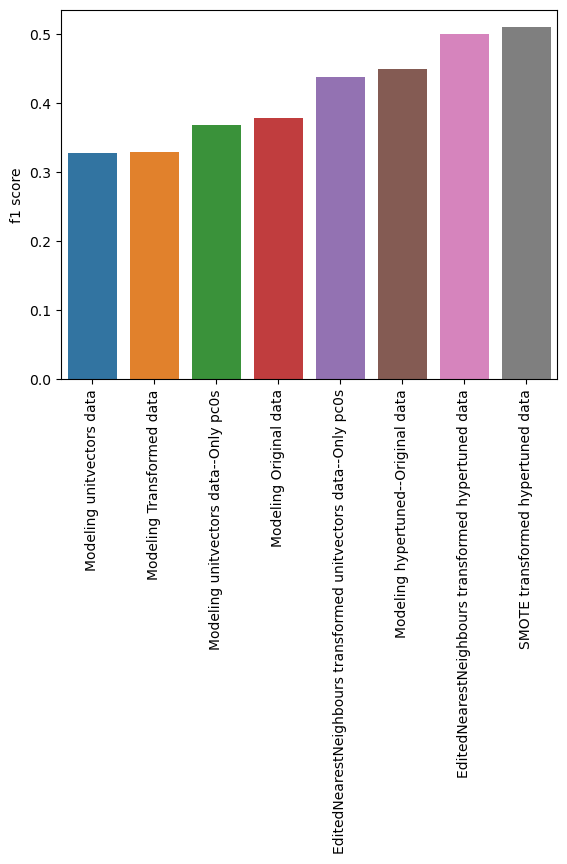

In [ ]:
# 28.0.2 And here is a quick comparison of f1-scores

out = out.sort_values('f1 score')
_=sns.barplot(x = out.index, y="f1 score", data=out)
_=plt.xticks(rotation=90)


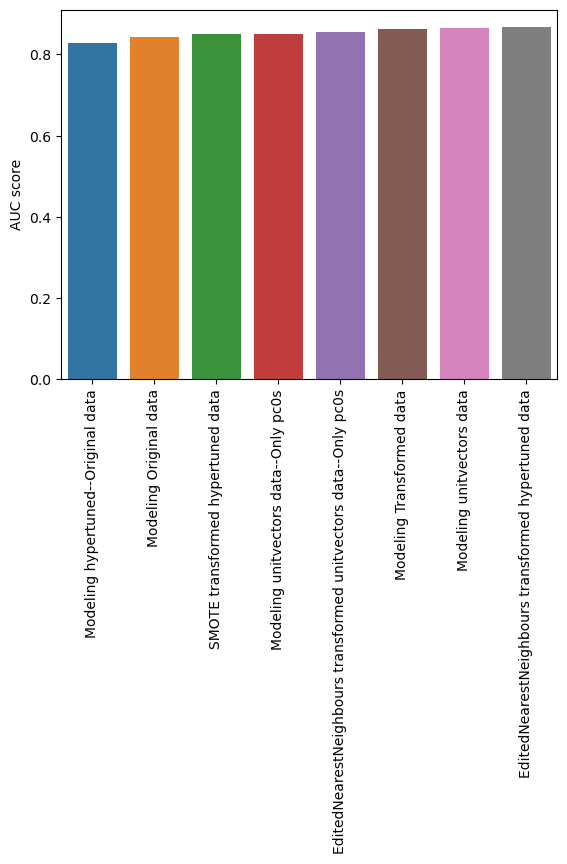

In [ ]:
# 28.0.2 And here is a quick comparison of AUC scores
#        Differences here are not much:

out = out.sort_values('AUC score')
_=sns.barplot(x = out.index, y="AUC score", data=out)
_=plt.xticks(rotation=90)

## Analysing Graphs
>Graph files get collected in folder <i>amazongraphs</i> (allmodels/models/). All graph files have _.gml_ format. There are two kinds of graph files--one for bipartite graph and another for unipartite graph. Bipartite graphs are created by taking two categorical columns, U and V, and treating levels of each as two independent sets of verticies. A vertex in U may have a connecting edge to a vertex in V if in a dataset row both occur together. A pair $U_{i}$ and $V_{i}$ may occur multiple times in different rows but we do not assign any weights to edges. A bigraph file between nodes of feature U and feature V is saved as <i>U\_bigraph\_V.gml</i>. In bipartite graphs we can project one sets of nodes and when we do so, we get two graph files--One from the projection of U and the other from the projection of V. A unipartite graph file when U is projected has a name <i>U\_projected\_V.gml</i> and when V is projected is saved as <i>V\_projected\_U.gml</i>  

### Read graph files

In [ ]:
# 29.0 Mount gdrive:

#from google.colab import drive
#drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# 29.1 Path where .gml files are placed:

amazongraphs = Path(amazongraphs)
filelist = sorted(list(amazongraphs.iterdir()))
filelist[5:10]   # mgrid_bigraph_*

[WindowsPath('c:/amazon/allmodels/models/mgrid_bigraph_rolerollupOne.gml'),
 WindowsPath('c:/amazon/allmodels/models/mgrid_bigraph_rolerolluptwo.gml'),
 WindowsPath('c:/amazon/allmodels/models/mgrid_bigraph_roletitle.gml'),
 WindowsPath('c:/amazon/allmodels/models/mgrid_projected_resource.gml'),
 WindowsPath('c:/amazon/allmodels/models/mgrid_projected_rolecode.gml')]

### Read data files:

In [ ]:
# 29.2 Read original and transformed data:

# Oriinal data:
X_train = pd.read_pickle(amazondata / "X_train.pkl")
X_test = pd.read_pickle(amazondata / "X_test.pkl")
y_train = pd.read_pickle(amazondata / "y_train.pkl")
y_test = pd.read_pickle(amazondata / "y_test.pkl")

# 29.2.1 Transformed data:
train_trans = pd.read_pickle(amazondata / "train_trans.pkl")
test_trans = pd.read_pickle(amazondata / "test_trans.pkl")

# 29.2.2 Read CatEncodersFamily class instance object:
ct = utils.restorePythonObject( "transformer.pkl", amazondata )

# 29.2.3
cat_cols = ['resource', 'mgrid', 'rolerollupOne', 'rolerolluptwo', 'roledeptname',
           'roletitle', 'rolefamilydesc', 'rolefamily', 'rolecode']


In [ ]:
# 29.3 check data files:
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)
y_train.head(2)
y_test.head(2)

resource  mgrid  rolerollupOne  rolerolluptwo  roledeptname  roletitle  \
0      4675  18044         117961         118386        118522     118321   
1     73495  51345         117961         118052        120417     118702   

   rolefamilydesc  rolefamily  rolecode  deg_resource_ck_mgrid  ...  \
0          117906      290919    118322               0.450665  ...   
1          125047      118704    118705               0.001856  ...   

   pr_rolecode_ck_roledeptname  bet_rolecode_ck_roledeptname  \
0                     0.012837                      0.051980   
1                     0.005207                      0.008156   

   eig_rolecode_ck_roletitle  deg_rolecode_ck_rolefamilydesc  \
0                  -0.059339                        0.083832   
1                  -0.028780                        0.023952   

   eig_rolecode_ck_rolefamilydesc  pr_rolecode_ck_rolefamilydesc  \
0                        0.212401                       0.009444   
1                        0.010817                       0.004082   

   bet_rolecode_ck_rolefamilydesc  deg_rolecode_ck_rolefamily  \
0                        0.005744                    0.029940   
1                        0.003770                    0.005988   

   eig_rolecode_ck_rolefamily  pr_rolecode_ck_rolefamily  
0               -5.643497e-17                   0.003087  
1                1.027726e-17                   0.003087  

[2 rows x 283 columns]

resource  mgrid  rolerollupOne  rolerolluptwo  roledeptname  roletitle  \
0    110357  52687         117961         117962        117904     128230   
1     41269   3889         117961         118386        121668     118321   

   rolefamilydesc  rolefamily  rolecode  deg_resource_ck_mgrid  ...  \
0          302830        4673    128231                    NaN  ...   
1          117906      290919    118322               0.004176  ...   

   pr_rolecode_ck_roledeptname  bet_rolecode_ck_roledeptname  \
0                     0.005049                      0.003084   
1                     0.012837                      0.051980   

   eig_rolecode_ck_roletitle  deg_rolecode_ck_rolefamilydesc  \
0                  -0.067275                        0.005988   
1                  -0.059339                        0.083832   

   eig_rolecode_ck_rolefamilydesc  pr_rolecode_ck_rolefamilydesc  \
0                    2.124556e-18                       0.003894   
1                    2.124007e-01                       0.009444   

   bet_rolecode_ck_rolefamilydesc  deg_rolecode_ck_rolefamily  \
0                        0.000000                    0.008982   
1                        0.005744                    0.029940   

   eig_rolecode_ck_rolefamily  pr_rolecode_ck_rolefamily  
0               -6.196957e-18                   0.003087  
1               -5.643497e-17                   0.003087  

[2 rows x 283 columns]

resource  mgrid  rolerollupOne  rolerolluptwo  roledeptname  roletitle  \
17277      4675  18044         117961         118386        118522     118321   
9292      73495  51345         117961         118052        120417     118702   

       rolefamilydesc  rolefamily  rolecode  
17277          117906      290919    118322  
9292           125047      118704    118705

resource  mgrid  rolerollupOne  rolerolluptwo  roledeptname  roletitle  \
12953    110357  52687         117961         117962        117904     128230   
17348     41269   3889         117961         118386        121668     118321   

       rolefamilydesc  rolefamily  rolecode  
12953          302830        4673    128231  
17348          117906      290919    118322

17277    0
9292     1
Name: action, dtype: int64

12953    0
17348    0
Name: action, dtype: int64

### Display graphs--Bigraphs and Projected

In [ ]:
# 29.4 Get sample list of projected and bigraphs:

projected = [str(i).split("/")[-1] for i in filelist if 'rolerollupOne_projected' in str(i)]

bigraphs = [str(i).split("/")[-1] for i in filelist if 'rolerollupOne_bigraph' in str(i)]
bigraphs = sorted(bigraphs, key=len)
bigraphs[:8]   # bigraph files
print("\n\n====\n")
projected = sorted(projected, key=len)
projected[:8]    # projected graph files

['c:\\amazon\\allmodels\\models\\rolerollupOne_bigraph_mgrid.gml',
 'c:\\amazon\\allmodels\\models\\rolerollupOne_bigraph_resource.gml',
 'c:\\amazon\\allmodels\\models\\rolerollupOne_bigraph_rolecode.gml',
 'c:\\amazon\\allmodels\\models\\rolerollupOne_bigraph_roletitle.gml',
 'c:\\amazon\\allmodels\\models\\rolerollupOne_bigraph_rolefamily.gml',
 'c:\\amazon\\allmodels\\models\\rolerollupOne_bigraph_roledeptname.gml',
 'c:\\amazon\\allmodels\\models\\rolerollupOne_bigraph_rolerolluptwo.gml',
 'c:\\amazon\\allmodels\\models\\rolerollupOne_bigraph_rolefamilydesc.gml']



====



['c:\\amazon\\allmodels\\models\\rolerollupOne_projected_mgrid.gml',
 'c:\\amazon\\allmodels\\models\\rolerollupOne_projected_resource.gml',
 'c:\\amazon\\allmodels\\models\\rolerollupOne_projected_rolecode.gml',
 'c:\\amazon\\allmodels\\models\\rolerollupOne_projected_roletitle.gml',
 'c:\\amazon\\allmodels\\models\\rolerollupOne_projected_rolefamily.gml',
 'c:\\amazon\\allmodels\\models\\rolerollupOne_projected_roledeptname.gml',
 'c:\\amazon\\allmodels\\models\\rolerollupOne_projected_rolerolluptwo.gml',
 'c:\\amazon\\allmodels\\models\\rolerollupOne_projected_rolefamilydesc.gml']

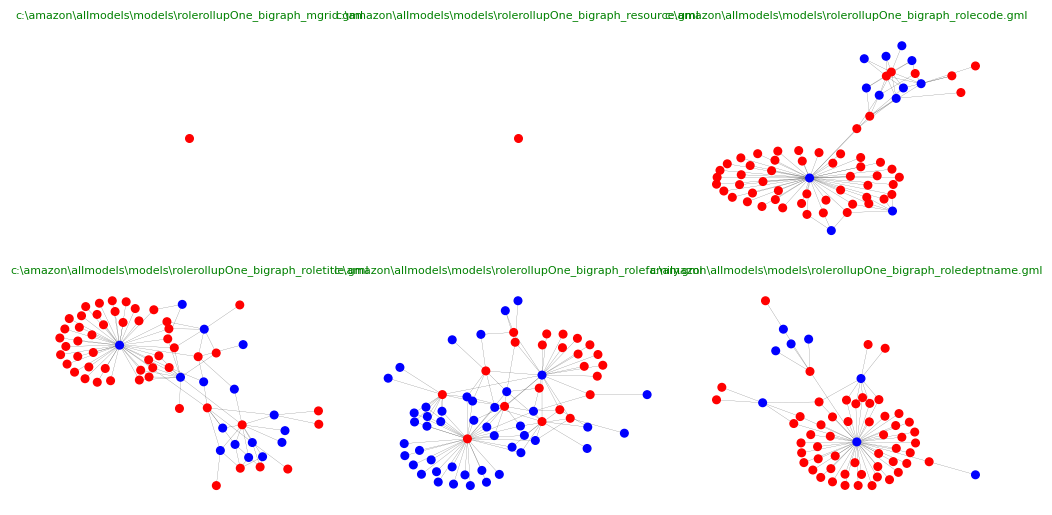

In [ ]:
# 29.5 Plot of sample bigraphs:
plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for bi in bigraphs[:6]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    # Only show connedted nodes
    _= utils.plotBipartiteGraph( bi,
                                amazongraphs,
                                 ax = ax,
                                 title = bi,
                                 connected=True,  # Show only connected nodes
                                 takeGraphSample=True # Do not show full graph but a sample of it
                                 )
    plt.tight_layout();

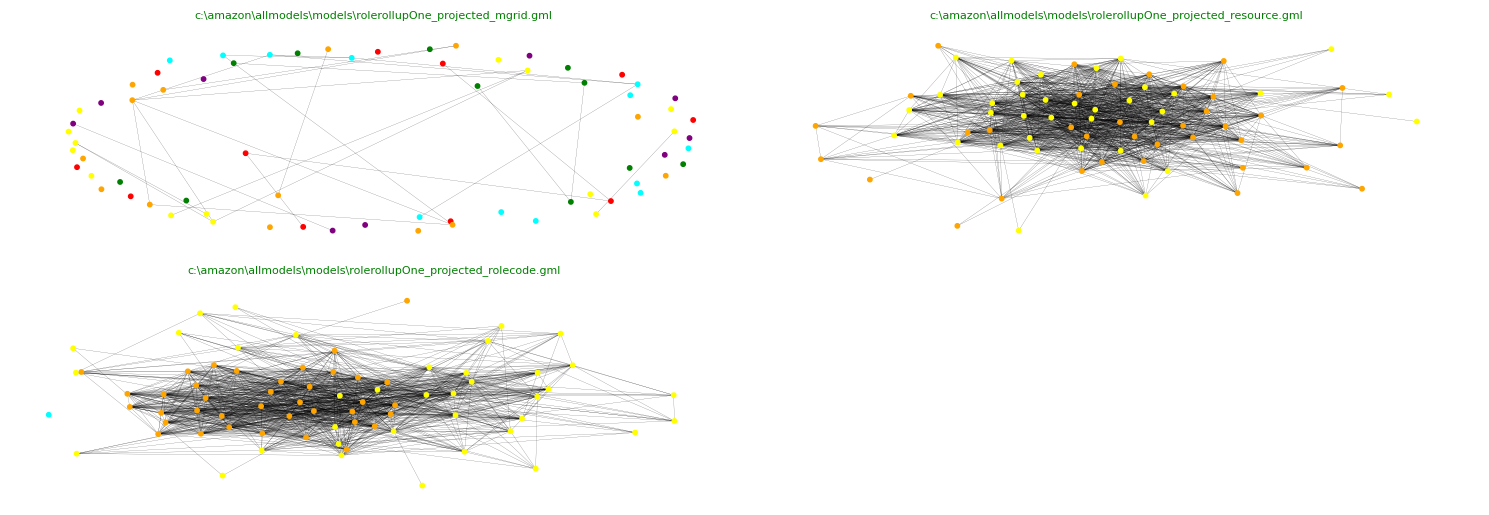

In [ ]:
# 29.6 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:3]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   amazongraphs,
                                   ax = ax,
                                   k = 1.5,   # For spring_layout, to avoid
                                              #  crowding of nodes
                                   withLabels = False,
                                   node_size = 10,
                                   title = prj,
                                   takeGraphSample = True # Do not show full graph
                                                          # but a sample of it
                                   );
    plt.tight_layout();

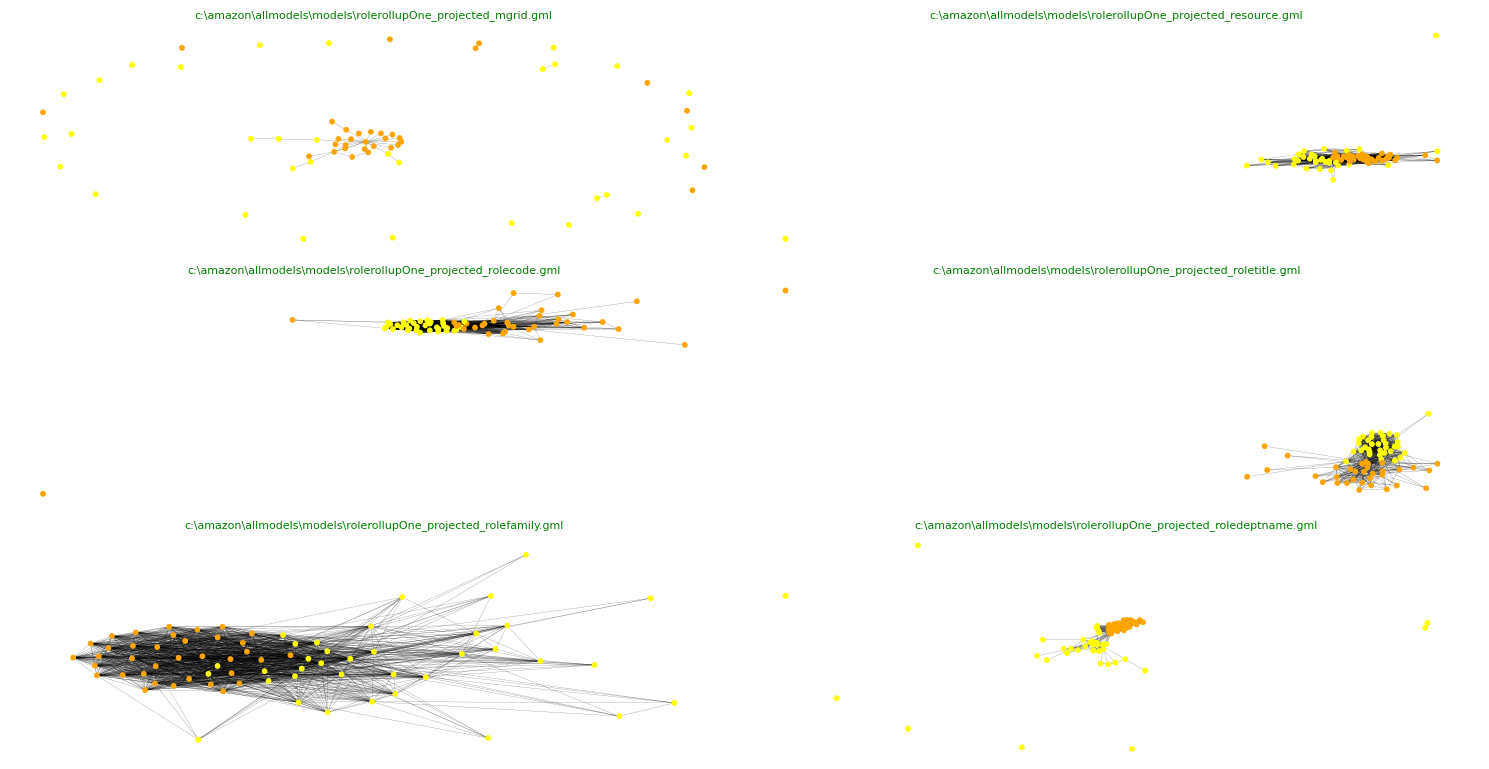

In [ ]:
# 29.7.1 Community visualization using
#        kernighan_lin_bisection algo:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:6]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   amazongraphs,
                                   algo = nx.community.kernighan_lin_bisection,
                                   node_size = 10,
                                   ax = ax,
                                   withLabels = False,
                                   title = prj,
                                   takeGraphSample = True
                                   );
    plt.tight_layout();

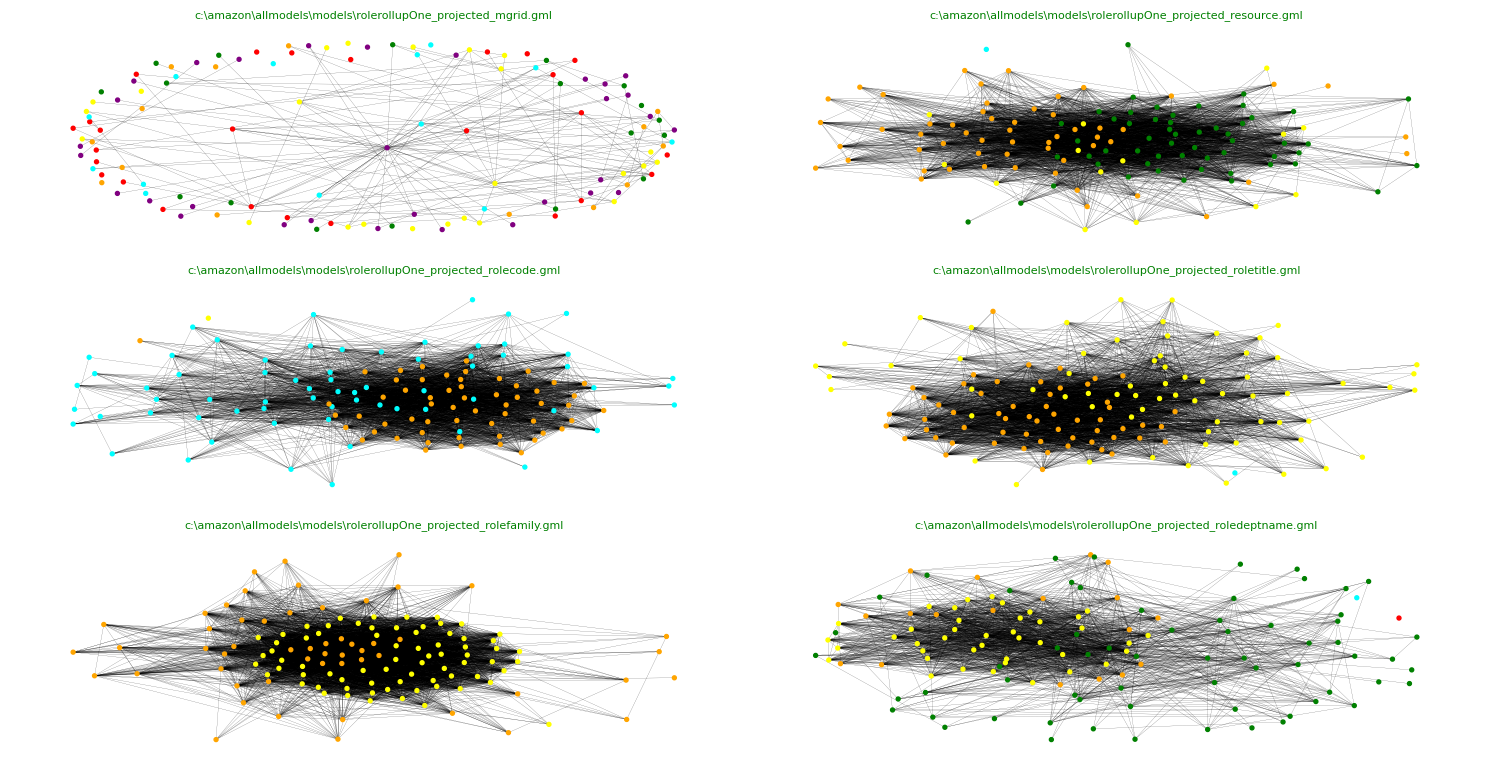

In [ ]:
# 29.7.2 Community visualization using
#        louvain_communities algo:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:6]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   amazongraphs,
                                   algo = nx.community.louvain_communities,
                                   node_size = 8,
                                   k =1.5,  # For spring_layout, to avoid crowding of nodes
                                   ax = ax,
                                   withLabels = False,
                                   title = prj
                                   );
    plt.tight_layout();

## Transform original data to communities data:
Takes time....

In [ ]:
# 30.0 Transform each column bin as per the community
#       to which it belongs:

# 30.1 Our transformed discrete cols are:
columnNames = cat_cols

# 30.2 Communities will be created as per this algo:
algolist =   [nx.community.greedy_modularity_communities] # [nx.community.kernighan_lin_bisection]=> Very poor results

# 30.3 Graph files are within:
#pathToGraphFolder= "/gdrive/MyDrive/Colab_data_files/amazonemp/models"

# 30.4 Perform transformation of both X_train and X_test:
# 30.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []
map_tr = []
map_te = []

# 30.4.2 PErform transformation to community structure
for algo in algolist:
  print("\n..Transforming train data....")
  print("==========================\n")
  map1,df_tr = utils.transformBinnedDF2Communities(columnNames,amazongraphs,X_train[cat_cols], algo = algo)
  print("\n==========================")
  print("..Transforming test data....")
  print("==========================\n")
  map2,df_te = utils.transformBinnedDF2Communities(columnNames,amazongraphs,X_test[cat_cols], algo = algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)
  map_tr.append(map1)
  map_te.append(map2)


..Transforming train data....

Reading file:  resource_projected_mgrid.gml
Reading file:  resource_projected_rolerollupOne.gml
Reading file:  resource_projected_rolerolluptwo.gml
Reading file:  resource_projected_roledeptname.gml
Reading file:  resource_projected_roletitle.gml
Reading file:  resource_projected_rolefamilydesc.gml
Reading file:  resource_projected_rolefamily.gml
Reading file:  resource_projected_rolecode.gml
Reading file:  mgrid_projected_resource.gml
Reading file:  mgrid_projected_rolerollupOne.gml
Reading file:  mgrid_projected_rolerolluptwo.gml
Reading file:  mgrid_projected_roledeptname.gml
Reading file:  mgrid_projected_roletitle.gml
Reading file:  mgrid_projected_rolefamilydesc.gml
Reading file:  mgrid_projected_rolefamily.gml
Reading file:  mgrid_projected_rolecode.gml
Reading file:  rolerollupOne_projected_resource.gml
Reading file:  rolerollupOne_projected_mgrid.gml
Reading file:  rolerollupOne_projected_rolerolluptwo.gml
Reading file:  rolerollupOne_projected_

In [ ]:
# 31.0 Observe few rows of data transformed community wise:
fg_tr[0].shape   # (24576, 68)
print("\n--\n")
fg_te[0].shape   # (8193, 68)
print("\n--\n")
fg_tr[0].head(2)
fg_te[0].head(2)

(24576, 68)


--



(8193, 68)


--



resource_projected_mgrid.gml  resource_projected_rolerollupOne.gml  \
17277                             1                                     1   
9292                              0                                     0   

       resource_projected_rolerolluptwo.gml  \
17277                                     0   
9292                                      1   

       resource_projected_roledeptname.gml  resource_projected_roletitle.gml  \
17277                                    2                                 0   
9292                                     0                                 0   

       resource_projected_rolefamilydesc.gml  \
17277                                      0   
9292                                       0   

       resource_projected_rolefamily.gml  resource_projected_rolecode.gml  \
17277                                  0                                0   
9292                                   0                                0   

       mgrid_projected_resource.gml  mgrid_projected_rolerollupOne.gml  ...  \
17277                             1                                  0  ...   
9292                              0                                  0  ...   

       rolefamily_projected_rolerolluptwo.gml  \
17277                                       2   
9292                                        1   

       rolefamily_projected_roledeptname.gml  \
17277                                      2   
9292                                       0   

       rolefamily_projected_rolefamilydesc.gml  \
17277                                        0   
9292                                         2   

       rolecode_projected_resource.gml  rolecode_projected_mgrid.gml  \
17277                                1                             0   
9292                                 0                             2   

       rolecode_projected_rolerollupOne.gml  \
17277                                     1   
9292                                      0   

       rolecode_projected_rolerolluptwo.gml  \
17277                                     0   
9292                                      1   

       rolecode_projected_roledeptname.gml  \
17277                                    0   
9292                                     1   

       rolecode_projected_rolefamilydesc.gml  \
17277                                      4   
9292                                       0   

       rolecode_projected_rolefamily.gml  
17277                                  6  
9292                                  41  

[2 rows x 68 columns]

resource_projected_mgrid.gml  resource_projected_rolerollupOne.gml  \
12953                           NaN                                   NaN   
17348                           1.0                                   0.0   

       resource_projected_rolerolluptwo.gml  \
12953                                   NaN   
17348                                   1.0   

       resource_projected_roledeptname.gml  resource_projected_roletitle.gml  \
12953                                  NaN                               NaN   
17348                                  0.0                               2.0   

       resource_projected_rolefamilydesc.gml  \
12953                                    NaN   
17348                                    1.0   

       resource_projected_rolefamily.gml  resource_projected_rolecode.gml  \
12953                                NaN                              NaN   
17348                                1.0                              2.0   

       mgrid_projected_resource.gml  mgrid_projected_rolerollupOne.gml  ...  \
12953                           1.0                                0.0  ...   
17348                           1.0                                0.0  ...   

       rolefamily_projected_rolerolluptwo.gml  \
12953                                       1   
17348                                       2   

       rolefamily_projected_roledeptname.gml  \
12953                                      0   
17348                                      2   

       rolefamily_projected_rolefamilydesc.gml  \
12953                                       13   
17348                                        0   

       rolecode_projected_resource.gml  rolecode_projected_mgrid.gml  \
12953                              1.0                           1.0   
17348                              1.0                           0.0   

       rolecode_projected_rolerollupOne.gml  \
12953                                   0.0   
17348                                   1.0   

       rolecode_projected_rolerolluptwo.gml  \
12953                                   1.0   
17348                                   0.0   

       rolecode_projected_roledeptname.gml  \
12953                                  0.0   
17348                                  0.0   

       rolecode_projected_rolefamilydesc.gml  \
12953                                   10.0   
17348                                    4.0   

       rolecode_projected_rolefamily.gml  
12953                               31.0  
17348                                6.0  

[2 rows x 68 columns]

In [ ]:
# 31.1 Remove constant columns from train data:
fg_tr[0] = utils.remConstColumns(fg_tr[0])

# 31.1.1 Keep same columns as above in test data:
fg_te[0] = fg_te[0][fg_tr[0].columns]

Datashape before processing: (24576, 68)
Datashape after processing: (24576, 68)


## Save community transformed data:
We can analyse it at peace

In [ ]:
# 32. Save the list to gdrive:
utils.savePythonObject(fg_tr, "fg_tr.pkl", amazondata)
utils.savePythonObject(fg_te, "fg_te.pkl", amazondata)

Object saved to: c:\amazon\allmodels\datafiles\fg_tr.pkl
Object saved to: c:\amazon\allmodels\datafiles\fg_te.pkl


## Read back community transformed data:

In [ ]:
# 32.1
fg_tr = utils.restorePythonObject( "fg_tr.pkl", amazondata )
fg_te = utils.restorePythonObject( "fg_te.pkl", amazondata )

In [ ]:
# 32.2 Check restoration:
fg_tr[0].head(2)
fg_te[0].head(2)

resource_projected_mgrid.gml  resource_projected_rolerollupOne.gml  \
17277                             1                                     1   
9292                              0                                     0   

       resource_projected_rolerolluptwo.gml  \
17277                                     0   
9292                                      1   

       resource_projected_roledeptname.gml  resource_projected_roletitle.gml  \
17277                                    2                                 0   
9292                                     0                                 0   

       resource_projected_rolefamilydesc.gml  \
17277                                      0   
9292                                       0   

       resource_projected_rolefamily.gml  resource_projected_rolecode.gml  \
17277                                  0                                0   
9292                                   0                                0   

       mgrid_projected_resource.gml  mgrid_projected_rolerollupOne.gml  ...  \
17277                             1                                  0  ...   
9292                              0                                  0  ...   

       rolefamily_projected_rolerolluptwo.gml  \
17277                                       2   
9292                                        1   

       rolefamily_projected_roledeptname.gml  \
17277                                      2   
9292                                       0   

       rolefamily_projected_rolefamilydesc.gml  \
17277                                        0   
9292                                         2   

       rolecode_projected_resource.gml  rolecode_projected_mgrid.gml  \
17277                                1                             0   
9292                                 0                             2   

       rolecode_projected_rolerollupOne.gml  \
17277                                     1   
9292                                      0   

       rolecode_projected_rolerolluptwo.gml  \
17277                                     0   
9292                                      1   

       rolecode_projected_roledeptname.gml  \
17277                                    0   
9292                                     1   

       rolecode_projected_rolefamilydesc.gml  \
17277                                      4   
9292                                       0   

       rolecode_projected_rolefamily.gml  
17277                                  6  
9292                                  41  

[2 rows x 68 columns]

resource_projected_mgrid.gml  resource_projected_rolerollupOne.gml  \
12953                           NaN                                   NaN   
17348                           1.0                                   0.0   

       resource_projected_rolerolluptwo.gml  \
12953                                   NaN   
17348                                   1.0   

       resource_projected_roledeptname.gml  resource_projected_roletitle.gml  \
12953                                  NaN                               NaN   
17348                                  0.0                               2.0   

       resource_projected_rolefamilydesc.gml  \
12953                                    NaN   
17348                                    1.0   

       resource_projected_rolefamily.gml  resource_projected_rolecode.gml  \
12953                                NaN                              NaN   
17348                                1.0                              2.0   

       mgrid_projected_resource.gml  mgrid_projected_rolerollupOne.gml  ...  \
12953                           1.0                                0.0  ...   
17348                           1.0                                0.0  ...   

       rolefamily_projected_rolerolluptwo.gml  \
12953                                       1   
17348                                       2   

       rolefamily_projected_roledeptname.gml  \
12953                                      0   
17348                                      2   

       rolefamily_projected_rolefamilydesc.gml  \
12953                                       13   
17348                                        0   

       rolecode_projected_resource.gml  rolecode_projected_mgrid.gml  \
12953                              1.0                           1.0   
17348                              1.0                           0.0   

       rolecode_projected_rolerollupOne.gml  \
12953                                   0.0   
17348                                   1.0   

       rolecode_projected_rolerolluptwo.gml  \
12953                                   1.0   
17348                                   0.0   

       rolecode_projected_roledeptname.gml  \
12953                                  0.0   
17348                                  0.0   

       rolecode_projected_rolefamilydesc.gml  \
12953                                   10.0   
17348                                    4.0   

       rolecode_projected_rolefamily.gml  
12953                               31.0  
17348                                6.0  

[2 rows x 68 columns]

## Check data columns
Our predictors should not have target columns

In [ ]:
# 32.3 Check again if target is in predictors!

'target' in list(fg_tr[0].columns)
'target' in list(fg_te[0].columns)
'action' in list(fg_tr[0].columns)
'action' in list(fg_te[0].columns)

False

False

False

False

## xgboost modeling from community indicators:

In [ ]:
# 33.0 Modeling with transformed train/test data with community indicators:

# As we repeat the process many times:
# Del the earlier result, if exists:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 250,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 14,
                                        subsample = 0.8,
                                        random_state = rng,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = y_train
yte = y_test


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 100,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[14:47:44] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[14:47:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=14
[0]	validation_0-auc:0.70743	validation_1-auc:0.64451
[14:47:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=14
[1]	validation_0-auc:0.75937	validation_1-auc:0.69735
[14:47:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=14
[2]	validation_0-auc:0.77147	validation_1-auc:0.69448
[14:47:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=14
[3]	validation_0-auc:0.80294	validati

[14:47:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 814 extra nodes, 0 pruned nodes, max_depth=14
[36]	validation_0-auc:0.94485	validation_1-auc:0.82685
[14:47:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 796 extra nodes, 0 pruned nodes, max_depth=14
[37]	validation_0-auc:0.94647	validation_1-auc:0.82673
[14:47:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 808 extra nodes, 0 pruned nodes, max_depth=14
[38]	validation_0-auc:0.94751	validation_1-auc:0.82696
[14:47:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 760 extra nodes, 0 pruned nodes, max_depth=14
[39]	validation_0-auc:0.94839	validation_1-auc:0.82685
[14:47:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.97103	validation_1-auc:0.83575
[14:47:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 536 extra nodes, 0 pruned nodes, max_depth=14
[73]	validation_0-auc:0.97131	validation_1-auc:0.83570
[14:47:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 456 extra nodes, 0 pruned nodes, max_depth=14
[74]	validation_0-auc:0.97160	validation_1-auc:0.83588
[14:47:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 586 extra nodes, 0 pruned nodes, max_depth=14
[75]	validation_0-auc:0.97203	validation_1-auc:0.83543
[14:47:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 530 extra nodes, 0 pruned nodes, max_depth=14
[76]	validation_0-auc:0.97231	validation_1-auc:0.83557
[14:47:46] INFO: C:\Users\dev-admin\croot2\xg

[14:47:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 538 extra nodes, 0 pruned nodes, max_depth=14
[110]	validation_0-auc:0.97909	validation_1-auc:0.83590
[14:47:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 596 extra nodes, 0 pruned nodes, max_depth=14
[111]	validation_0-auc:0.97929	validation_1-auc:0.83595
[14:47:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 538 extra nodes, 0 pruned nodes, max_depth=14
[112]	validation_0-auc:0.97944	validation_1-auc:0.83587
[14:47:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 546 extra nodes, 0 pruned nodes, max_depth=14
[113]	validation_0-auc:0.97964	validation_1-auc:0.83576
[14:47:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[14:47:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=14
[147]	validation_0-auc:0.98291	validation_1-auc:0.83256
[14:47:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=14
[148]	validation_0-auc:0.98293	validation_1-auc:0.83251
[14:47:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=14
[149]	validation_0-auc:0.98304	validation_1-auc:0.83255
[14:47:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 522 extra nodes, 0 pruned nodes, max_depth=14
[150]	validation_0-auc:0.98315	validation_1-auc:0.83256
[14:47:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[14:47:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 544 extra nodes, 0 pruned nodes, max_depth=14
[184]	validation_0-auc:0.98532	validation_1-auc:0.83171
[14:47:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 584 extra nodes, 0 pruned nodes, max_depth=14
[185]	validation_0-auc:0.98540	validation_1-auc:0.83194
[14:47:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 466 extra nodes, 0 pruned nodes, max_depth=14
[186]	validation_0-auc:0.98548	validation_1-auc:0.83188
[14:47:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 462 extra nodes, 0 pruned nodes, max_depth=14
[187]	validation_0-auc:0.98552	validation_1-auc:0.83165
[14:47:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 33.0.1 Save estimator: model_trans_commu
utils.savePythonObject(model_trans_commu, "model_trans_commu.pkl", amazonestimators )

Object saved to: c:\amazon\allmodels\estimators\model_trans_commu.pkl


In [ ]:
# 33.0.2 Read back saved estimator:
model_trans_commu = utils.restorePythonObject("model_trans_commu.pkl", amazonestimators )

In [ ]:
# 33.0.3 Classification reports:

f"Best AUC: {model_trans_commu.best_score}"
pred_orig = model_orig.predict(X_test)
pred_comm = model_trans_commu.predict(test_X)

print(f"Classification report from original data: \n {classification_report(y_test,pred_orig)}")
print("\n==================\n")
print(f"Classification report from community data: \n {classification_report(y_test,pred_comm)}")


'Best AUC: 0.8368654965581668'

Classification report from original data: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      7719
           1       0.66      0.27      0.38       474

    accuracy                           0.95      8193
   macro avg       0.81      0.63      0.68      8193
weighted avg       0.94      0.95      0.94      8193



Classification report from community data: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      7719
           1       0.57      0.15      0.23       474

    accuracy                           0.94      8193
   macro avg       0.76      0.57      0.60      8193
weighted avg       0.93      0.94      0.93      8193



### Learning curve

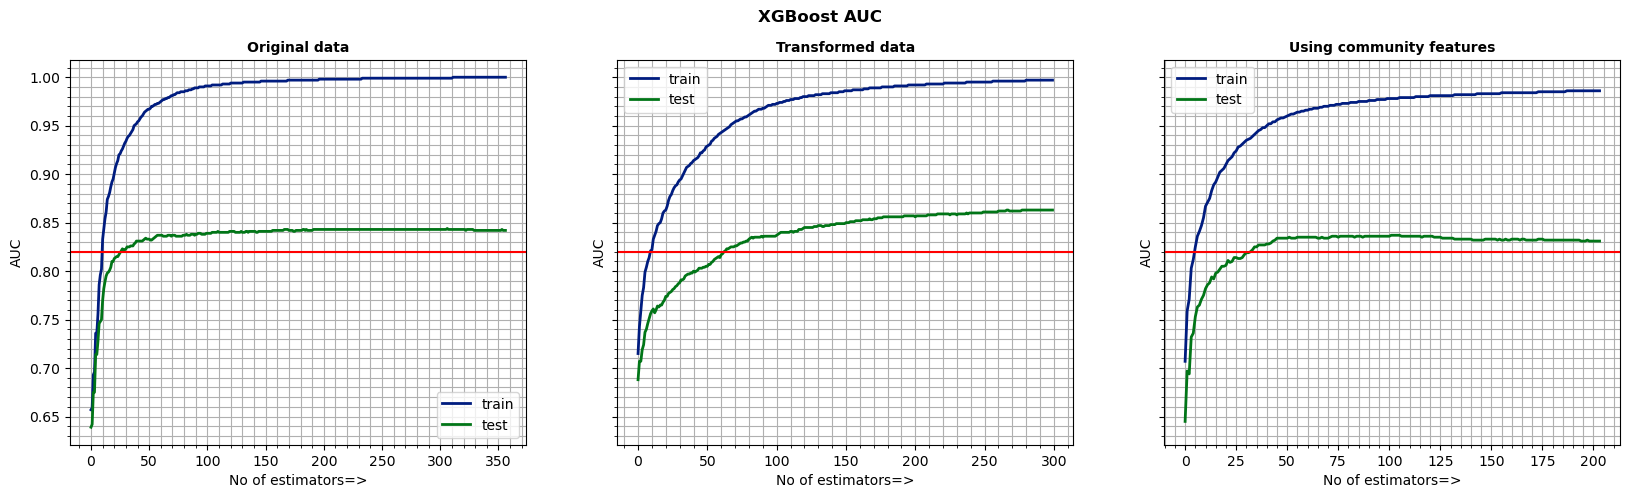

In [ ]:
# 33.0.4

plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515

fig, ax = plt.subplots(1,3, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(),model_trans.evals_result(),  model_trans_commu.evals_result() ]
title = ["Original data", 'Transformed data', 'Using community features']
fig.suptitle("XGBoost AUC", fontweight = "bold")
for i in range(3):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 10, fontweight = "bold");
    ax[i].axhline(y = 0.82, color = 'r', linestyle = '-')

plt.show();

## ROUGH WORK BELOW

In [ ]:
# 34.0
Xfg_train = pd.concat([fg_tr[0].reset_index(drop = True),X_train.head().reset_index(drop = True)], axis =1)
Xfg_test =  pd.concat([fg_te[0].reset_index(drop = True),X_test.head().reset_index(drop = True)], axis =1)

In [ ]:
# 34.1 Modeling concatenated data

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 250,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 14,
                                        subsample = 0.8,
                                        random_state = rng,
                                      )


tr_X =   Xfg_train
test_X = Xfg_test
ytr = y_train
yte = y_test


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 100,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[14:48:09] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[14:48:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 298 extra nodes, 0 pruned nodes, max_depth=14
[0]	validation_0-auc:0.71160	validation_1-auc:0.64377
[14:48:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=14
[1]	validation_0-auc:0.71819	validation_1-auc:0.65763
[14:48:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=14
[2]	validation_0-auc:0.74638	validation_1-auc:0.68222
[14:48:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=14
[3]	validation_0-auc:0.78447	validati

[14:48:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 836 extra nodes, 0 pruned nodes, max_depth=14
[36]	validation_0-auc:0.94157	validation_1-auc:0.82303
[14:48:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 814 extra nodes, 0 pruned nodes, max_depth=14
[37]	validation_0-auc:0.94315	validation_1-auc:0.82504
[14:48:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 830 extra nodes, 0 pruned nodes, max_depth=14
[38]	validation_0-auc:0.94446	validation_1-auc:0.82508
[14:48:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 770 extra nodes, 0 pruned nodes, max_depth=14
[39]	validation_0-auc:0.94613	validation_1-auc:0.82589
[14:48:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.97061	validation_1-auc:0.83816
[14:48:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 488 extra nodes, 0 pruned nodes, max_depth=14
[73]	validation_0-auc:0.97096	validation_1-auc:0.83818
[14:48:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 492 extra nodes, 0 pruned nodes, max_depth=14
[74]	validation_0-auc:0.97117	validation_1-auc:0.83901
[14:48:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 492 extra nodes, 0 pruned nodes, max_depth=14
[75]	validation_0-auc:0.97146	validation_1-auc:0.83918
[14:48:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 534 extra nodes, 0 pruned nodes, max_depth=14
[76]	validation_0-auc:0.97182	validation_1-auc:0.83899
[14:48:11] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.97823	validation_1-auc:0.83756
[14:48:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=14
[110]	validation_0-auc:0.97833	validation_1-auc:0.83717
[14:48:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=14
[111]	validation_0-auc:0.97841	validation_1-auc:0.83685
[14:48:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=14
[112]	validation_0-auc:0.97857	validation_1-auc:0.83668
[14:48:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=14
[113]	validation_0-auc:0.97864	validation_1-auc:0.83651
[14:48:12] INFO: C:\Users\dev-admin\croo

[14:48:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=14
[147]	validation_0-auc:0.98235	validation_1-auc:0.83656
[14:48:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 580 extra nodes, 0 pruned nodes, max_depth=14
[148]	validation_0-auc:0.98245	validation_1-auc:0.83633
[14:48:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=14
[149]	validation_0-auc:0.98255	validation_1-auc:0.83596
[14:48:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=14
[150]	validation_0-auc:0.98259	validation_1-auc:0.83599
[14:48:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

## Mean unit vectors for embedding
These may help to find relationships among levels of a feature

In [ ]:
# 29.0
train_trans['target'] = y_train

vec_trx,_ = ct.vectorsToTSV(train_trans,
                           take_mean = True,
                           filepath = amazonunitvecs,   # Folder where csv files will be saved
                           saveVectorsToDisk = True,
                           fnamesuffix = "_avg"
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for resource
Checked for mgrid
Checked for rolerollupOne
Checked for rolerolluptwo
Checked for roledeptname
Checked for roletitle
Checked for rolefamilydesc
Checked for rolefamily
Checked for rolecode
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: 'c:\amazon\allmodels\unitvec'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature


## Feature Engineering with clustering

In [ ]:
# 30.0 Create clustering features from unitvector dataframes:

n_components = 4 # No of components while performing PCA of every feature
fe_tr,fe_te = utils.featureEngKmeans(cctr,
                                     ccte,
                                     n_clusters = 25,  # No of clusters per feature
                                     step_size = n_components,
                                     km=True,  # Only perform KMeans
                                     gmm=False  # No Gaussian Mixture modeling
                                     )

Current index:  0
Current index:  4
Current index:  8
Current index:  12
Current index:  16
Current index:  20
Current index:  24
Current index:  28
Current index:  32


In [ ]:
# 30.1 Output is orig dataframe + clusters
fe_tr.head(3)
fe_te.head(3)

pcresource0  pcresource1  pcresource2  pcresource3  pcmgrid0  pcmgrid1  \
0    10.325288    -4.737968     2.768218    -2.646162 -1.685623  1.450604   
1    -4.533136    -0.053835     4.653866    -1.492393 -0.934379 -3.146101   
2    -2.391692    -0.383405    -2.068087    -0.861286 -0.508784 -0.670439   

   pcmgrid2  pcmgrid3  pcrolerollupOne0  pcrolerollupOne1  ...  pcrolecode3  \
0  1.660824 -0.185054         -3.073716          0.049806  ...    -0.597823   
1 -0.228803 -0.453164         -3.073717          0.049726  ...    -0.768127   
2 -1.503745 -0.887663         -3.073718          0.049746  ...    -0.644822   

   clu0  clu1  clu2  clu3  clu4  clu5  clu6  clu7  clu8  
0     1     0     0     7    17     0     0     1     3  
1     5    10     0    23     0    11    13     2     8  
2     7    23     0     0     7     2     7     2    13  

[3 rows x 45 columns]

pcresource0  pcresource1  pcresource2  pcresource3  pcmgrid0  pcmgrid1  \
0    -2.055919    -0.853011    -1.806662     0.266409 -1.679345 -2.753263   
1    -2.827375    -0.963895    -2.232217    -0.871762 -1.388409  1.341824   
2    -2.055919    -0.853011    -1.806662     0.266409 -1.655700  0.971638   

   pcmgrid2  pcmgrid3  pcrolerollupOne0  pcrolerollupOne1  ...  pcrolecode3  \
0 -1.210756  1.673969         -3.073718          0.049751  ...    -0.931946   
1  1.706687 -0.908531         -3.073718          0.049751  ...    -0.597857   
2  2.107128 -0.338757         -3.073718          0.049751  ...     0.080010   

   clu0  clu1  clu2  clu3  clu4  clu5  clu6  clu7  clu8  
0    14    14     0     0     1    14    20    14    24  
1     7     0     0     7    16     0     0     1     3  
2    14    21     0     3    16     0    13     1    19  

[3 rows x 45 columns]

In [ ]:
# 30.2 Have a look at clusters created:

colNames = [i for i in fe_tr.columns if "clu" in i]
fe_tr[colNames].head(3)
fe_te[colNames].head(3)


clu0  clu1  clu2  clu3  clu4  clu5  clu6  clu7  clu8
0     1     0     0     7    17     0     0     1     3
1     5    10     0    23     0    11    13     2     8
2     7    23     0     0     7     2     7     2    13

clu0  clu1  clu2  clu3  clu4  clu5  clu6  clu7  clu8
0    14    14     0     0     1    14    20    14    24
1     7     0     0     7    16     0     0     1     3
2    14    21     0     3    16     0    13     1    19

In [ ]:
# 30.3 Perform xgboost modeling using only the above clustered data:

model_fe = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = None,
                              reg_lambda = 1.5,
                           )

tr_X =   fe_tr[colNames]
test_X =  fe_te[colNames]
ytrain =  y_train
ytest = y_test


model_fe.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[18:06:28] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[18:06:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.64057	validation_1-auc:0.61539
[18:06:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=12
[1]	validation_0-auc:0.67256	validation_1-auc:0.64665
[18:06:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=12
[2]	validation_0-auc:0.69235	validation_1-auc:0.66216
[18:06:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.71198	validati

[18:06:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 602 extra nodes, 0 pruned nodes, max_depth=13
[36]	validation_0-auc:0.90993	validation_1-auc:0.80956
[18:06:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 696 extra nodes, 0 pruned nodes, max_depth=13
[37]	validation_0-auc:0.91259	validation_1-auc:0.81014
[18:06:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 492 extra nodes, 0 pruned nodes, max_depth=13
[38]	validation_0-auc:0.91305	validation_1-auc:0.81072
[18:06:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 786 extra nodes, 0 pruned nodes, max_depth=13
[39]	validation_0-auc:0.91530	validation_1-auc:0.81151
[18:06:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.94855	validation_1-auc:0.82213
[18:06:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 484 extra nodes, 0 pruned nodes, max_depth=13
[73]	validation_0-auc:0.94925	validation_1-auc:0.82162
[18:06:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 676 extra nodes, 0 pruned nodes, max_depth=13
[74]	validation_0-auc:0.94997	validation_1-auc:0.82182
[18:06:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 522 extra nodes, 0 pruned nodes, max_depth=13
[75]	validation_0-auc:0.95046	validation_1-auc:0.82221
[18:06:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 746 extra nodes, 0 pruned nodes, max_depth=13
[76]	validation_0-auc:0.95128	validation_1-auc:0.82178
[18:06:29] INFO: C:\Users\dev-admin\croot2\xg

[18:06:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 610 extra nodes, 0 pruned nodes, max_depth=13
[110]	validation_0-auc:0.96511	validation_1-auc:0.82016
[18:06:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 632 extra nodes, 0 pruned nodes, max_depth=13
[111]	validation_0-auc:0.96542	validation_1-auc:0.82020
[18:06:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 680 extra nodes, 0 pruned nodes, max_depth=13
[112]	validation_0-auc:0.96576	validation_1-auc:0.81969
[18:06:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 508 extra nodes, 0 pruned nodes, max_depth=13
[113]	validation_0-auc:0.96599	validation_1-auc:0.81969
[18:06:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 28.4.1 Save estimator: model_vec
utils.savePythonObject(model_fe, "model_fe.pkl", amazonestimators )

Object saved to: c:\amazon\allmodels\estimators\model_fe.pkl


In [ ]:
# 28.4.2 Read back saved estimator:
model_fe = utils.restorePythonObject("model_fe.pkl", amazonestimators )

In [ ]:
# 30.4 Best score
model_fe.best_score  # 0.82913688235


0.8223673242035789

In [ ]:
# 30.5 Classification report:

pred_fe = model_fe.predict(test_X)
print(classification_report(y_test,pred_fe))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7719
           1       0.59      0.15      0.24       474

    accuracy                           0.94      8193
   macro avg       0.77      0.57      0.61      8193
weighted avg       0.93      0.94      0.93      8193



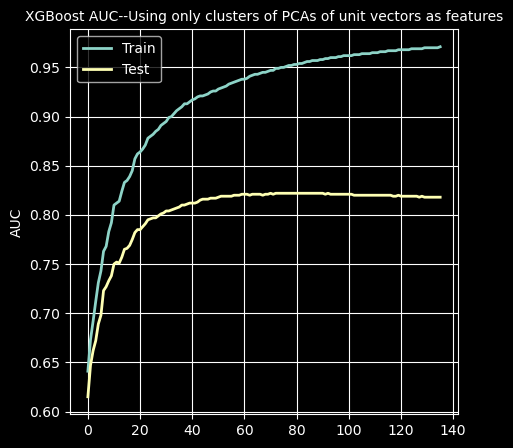

In [ ]:
# 30.6 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_fe.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.title("XGBoost AUC--Using only clusters of PCAs of unit vectors as features", fontsize = 10);


In [ ]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours, EditedNearestNeighbours, NeighbourhoodCleaningRule,OneSidedSelection,InstanceHardnessThreshold
from imblearn.combine import SMOTEENN

In [ ]:
#ncr = NeighbourhoodCleaningRule(n_neighbors = 3)
#oss = OneSidedSelection()
#inst = InstanceHardnessThreshold()
enn = EditedNearestNeighbours()
#renn = RepeatedEditedNearestNeighbours()
#smt  = SMOTEENN()
#X_res, y_res = ncr.fit_resample(tr_mod, y_train)
X_res, y_res = enn.fit_resample(cctr_rem, y_train)

NameError: name 'cctr_rem' is not defined

In [ ]:
X_res.shape  # (22295, 36)

(22295, 36)

In [ ]:


tr_X = X_res
test_X = ccte
ytrain = y_res
ytest = y_test


In [ ]:
# 19.4 Optuna, define objective function:

def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 1, 14),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 500),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
              'eval_metric': 'auc',
              'use_label_encoder': False
    }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(tr_X, ytrain)
    # Make predictions
    y_pred = optuna_model.predict(test_X)

    # Evaluate predictions
    f1 = f1_score(ytest, y_pred, pos_label = 1)
    # Maximise f1-score
    return f1



# 19.4.1 Create optuna study
study = optuna.create_study(direction='maximize')

# 19.4.2 Begin optimization
#      We use less trials for quick results:

study.optimize(objective, n_trials=300)


[I 2023-08-10 18:16:13,804] A new study created in memory with name: no-name-9ef44008-570e-4024-b305-aac62d624f90
[I 2023-08-10 18:16:14,380] Trial 0 finished with value: 0.04606525911708253 and parameters: {'max_depth': 3, 'learning_rate': 0.29847937555473164, 'n_estimators': 189, 'min_child_weight': 10, 'gamma': 1.1789397171043885e-05, 'subsample': 0.043360069603133496, 'colsample_bytree': 0.01608583789905653, 'reg_alpha': 0.10586922758555607, 'reg_lambda': 0.10394018099778811}. Best is trial 0 with value: 0.04606525911708253.
[I 2023-08-10 18:16:15,172] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 12, 'learning_rate': 0.029087883037424832, 'n_estimators': 243, 'min_child_weight': 2, 'gamma': 4.024705966091604e-06, 'subsample': 0.013701917793236698, 'colsample_bytree': 0.05678872541797345, 'reg_alpha': 0.13627486757162705, 'reg_lambda': 0.00023550961049223452}. Best is trial 0 with value: 0.04606525911708253.
[I 2023-08-10 18:16:15,846] Trial 2 finished with value: 

[I 2023-08-10 18:16:57,554] Trial 20 finished with value: 0.44632086851628466 and parameters: {'max_depth': 6, 'learning_rate': 0.13808927438800278, 'n_estimators': 388, 'min_child_weight': 9, 'gamma': 1.2389254664372447e-06, 'subsample': 0.9617740221551325, 'colsample_bytree': 0.8817532938436254, 'reg_alpha': 0.003704412264262829, 'reg_lambda': 5.273881979423877e-06}. Best is trial 16 with value: 0.46522234891676173.
[I 2023-08-10 18:17:01,649] Trial 21 finished with value: 0.43764705882352944 and parameters: {'max_depth': 6, 'learning_rate': 0.12493142149740694, 'n_estimators': 499, 'min_child_weight': 9, 'gamma': 7.0656750342983e-08, 'subsample': 0.9620469186436686, 'colsample_bytree': 0.9862710768655123, 'reg_alpha': 0.00514235640907107, 'reg_lambda': 7.641321640706128e-06}. Best is trial 16 with value: 0.46522234891676173.
[I 2023-08-10 18:17:04,697] Trial 22 finished with value: 0.448512585812357 and parameters: {'max_depth': 8, 'learning_rate': 0.2005962301120962, 'n_estimators'

[I 2023-08-10 18:17:41,092] Trial 40 finished with value: 0.4325637910085055 and parameters: {'max_depth': 8, 'learning_rate': 0.11305774426991617, 'n_estimators': 182, 'min_child_weight': 1, 'gamma': 2.0093847417076485e-07, 'subsample': 0.21288635198943978, 'colsample_bytree': 0.4402908542425744, 'reg_alpha': 0.0002278403486308189, 'reg_lambda': 7.169632730955434e-06}. Best is trial 16 with value: 0.46522234891676173.
[I 2023-08-10 18:17:42,889] Trial 41 finished with value: 0.44617092119866814 and parameters: {'max_depth': 8, 'learning_rate': 0.19762355838869894, 'n_estimators': 221, 'min_child_weight': 4, 'gamma': 1.1868893666034987e-07, 'subsample': 0.4494645055760519, 'colsample_bytree': 0.5550901330600262, 'reg_alpha': 0.00014824045107535294, 'reg_lambda': 1.8546028442945912e-06}. Best is trial 16 with value: 0.46522234891676173.
[I 2023-08-10 18:17:44,490] Trial 42 finished with value: 0.46171428571428574 and parameters: {'max_depth': 9, 'learning_rate': 0.15241588876387036, 'n_

[I 2023-08-10 18:18:20,702] Trial 60 finished with value: 0.43609022556390975 and parameters: {'max_depth': 13, 'learning_rate': 0.15941639115767067, 'n_estimators': 299, 'min_child_weight': 1, 'gamma': 2.6382705525803303e-07, 'subsample': 0.24759888944763384, 'colsample_bytree': 0.2611028882234796, 'reg_alpha': 6.154095273423635e-07, 'reg_lambda': 1.7657309991500426e-05}. Best is trial 53 with value: 0.47071352502662406.
[I 2023-08-10 18:18:25,617] Trial 61 finished with value: 0.4684491978609626 and parameters: {'max_depth': 13, 'learning_rate': 0.15083082719313795, 'n_estimators': 480, 'min_child_weight': 2, 'gamma': 1.0948774630010196e-06, 'subsample': 0.5001417051987738, 'colsample_bytree': 0.5179420445648503, 'reg_alpha': 2.719201696276639e-07, 'reg_lambda': 1.1586795778968306e-05}. Best is trial 53 with value: 0.47071352502662406.
[I 2023-08-10 18:18:29,927] Trial 62 finished with value: 0.4406779661016949 and parameters: {'max_depth': 13, 'learning_rate': 0.21519348108658662, '

[I 2023-08-10 18:19:43,007] Trial 80 finished with value: 0.46868250539956813 and parameters: {'max_depth': 14, 'learning_rate': 0.1421109954873346, 'n_estimators': 443, 'min_child_weight': 3, 'gamma': 6.094293183791529e-07, 'subsample': 0.6981502059412507, 'colsample_bytree': 0.2926018988250247, 'reg_alpha': 2.073967414703115e-08, 'reg_lambda': 0.000818823539704133}. Best is trial 74 with value: 0.48562300319488816.
[I 2023-08-10 18:19:47,437] Trial 81 finished with value: 0.46547884187082406 and parameters: {'max_depth': 14, 'learning_rate': 0.1394975403121511, 'n_estimators': 443, 'min_child_weight': 3, 'gamma': 5.121702951305443e-07, 'subsample': 0.6801154977555283, 'colsample_bytree': 0.2904278195415461, 'reg_alpha': 2.0025720657445533e-08, 'reg_lambda': 0.0009894025888724312}. Best is trial 74 with value: 0.48562300319488816.
[I 2023-08-10 18:19:51,981] Trial 82 finished with value: 0.46071044133476863 and parameters: {'max_depth': 13, 'learning_rate': 0.12604609490261234, 'n_est

[I 2023-08-10 18:21:15,785] Trial 100 finished with value: 0.4646017699115044 and parameters: {'max_depth': 14, 'learning_rate': 0.08539271704419625, 'n_estimators': 399, 'min_child_weight': 1, 'gamma': 2.5064685505601403e-05, 'subsample': 0.98296270925583, 'colsample_bytree': 0.8795243570891995, 'reg_alpha': 2.5596590773103438e-08, 'reg_lambda': 2.603082967681785e-05}. Best is trial 74 with value: 0.48562300319488816.
[I 2023-08-10 18:21:20,376] Trial 101 finished with value: 0.47874720357941825 and parameters: {'max_depth': 13, 'learning_rate': 0.09479158366067972, 'n_estimators': 364, 'min_child_weight': 1, 'gamma': 7.220220015835731e-06, 'subsample': 0.8969754869092046, 'colsample_bytree': 0.5905307603225073, 'reg_alpha': 1.0103099524591e-08, 'reg_lambda': 4.669570478843035e-05}. Best is trial 74 with value: 0.48562300319488816.
[I 2023-08-10 18:21:25,477] Trial 102 finished with value: 0.46464646464646464 and parameters: {'max_depth': 13, 'learning_rate': 0.07272190187229789, 'n_e

[I 2023-08-10 18:22:48,188] Trial 120 finished with value: 0.471395881006865 and parameters: {'max_depth': 12, 'learning_rate': 0.0601307268489263, 'n_estimators': 323, 'min_child_weight': 1, 'gamma': 2.3760465936391198e-05, 'subsample': 0.595286004128686, 'colsample_bytree': 0.8221930936517581, 'reg_alpha': 2.7361985021708305e-08, 'reg_lambda': 0.0001313066643284131}. Best is trial 74 with value: 0.48562300319488816.
[I 2023-08-10 18:22:52,835] Trial 121 finished with value: 0.4629213483146068 and parameters: {'max_depth': 14, 'learning_rate': 0.08267500120102034, 'n_estimators': 342, 'min_child_weight': 1, 'gamma': 2.0100823892193236e-05, 'subsample': 0.9807376451492186, 'colsample_bytree': 0.6331611309696086, 'reg_alpha': 3.2854519021686195e-08, 'reg_lambda': 5.581792593648876e-05}. Best is trial 74 with value: 0.48562300319488816.
[I 2023-08-10 18:22:57,928] Trial 122 finished with value: 0.4766146993318485 and parameters: {'max_depth': 13, 'learning_rate': 0.09217044041400886, 'n_

[I 2023-08-10 18:24:25,084] Trial 140 finished with value: 0.4806201550387597 and parameters: {'max_depth': 11, 'learning_rate': 0.1087173003542146, 'n_estimators': 453, 'min_child_weight': 1, 'gamma': 2.6414293823311533e-06, 'subsample': 0.671221648371878, 'colsample_bytree': 0.46488225311640674, 'reg_alpha': 1.803046376265351e-08, 'reg_lambda': 3.4237954505584064e-06}. Best is trial 130 with value: 0.49165739710789774.
[I 2023-08-10 18:24:29,890] Trial 141 finished with value: 0.4691358024691358 and parameters: {'max_depth': 11, 'learning_rate': 0.10335651245630649, 'n_estimators': 450, 'min_child_weight': 1, 'gamma': 2.1589967877587237e-06, 'subsample': 0.6344238045469612, 'colsample_bytree': 0.45866761558107044, 'reg_alpha': 2.1203123387108725e-08, 'reg_lambda': 8.002216355117995e-06}. Best is trial 130 with value: 0.49165739710789774.
[I 2023-08-10 18:24:34,574] Trial 142 finished with value: 0.4819277108433735 and parameters: {'max_depth': 12, 'learning_rate': 0.10677548446182829

[I 2023-08-10 18:25:54,737] Trial 160 finished with value: 0.4515418502202643 and parameters: {'max_depth': 11, 'learning_rate': 0.13961043284631658, 'n_estimators': 448, 'min_child_weight': 1, 'gamma': 4.379441308919796e-06, 'subsample': 0.6597614147987041, 'colsample_bytree': 0.4134632057115423, 'reg_alpha': 4.001017523804074e-08, 'reg_lambda': 7.1482756371881305e-06}. Best is trial 130 with value: 0.49165739710789774.
[I 2023-08-10 18:25:59,626] Trial 161 finished with value: 0.47374301675977654 and parameters: {'max_depth': 13, 'learning_rate': 0.10062121930854832, 'n_estimators': 397, 'min_child_weight': 1, 'gamma': 7.0048401441569935e-06, 'subsample': 0.6985718421919039, 'colsample_bytree': 0.5822670316379814, 'reg_alpha': 1.4448286956133767e-08, 'reg_lambda': 1.5920774858305625e-05}. Best is trial 130 with value: 0.49165739710789774.
[I 2023-08-10 18:26:04,857] Trial 162 finished with value: 0.48008849557522126 and parameters: {'max_depth': 13, 'learning_rate': 0.084077742210657

[I 2023-08-10 18:27:23,488] Trial 180 finished with value: 0.47085714285714286 and parameters: {'max_depth': 13, 'learning_rate': 0.08486284333912375, 'n_estimators': 415, 'min_child_weight': 1, 'gamma': 1.2005050290077733e-06, 'subsample': 0.7557204589383244, 'colsample_bytree': 0.3259079694760086, 'reg_alpha': 1.82940897803271e-08, 'reg_lambda': 8.867571721683394e-06}. Best is trial 130 with value: 0.49165739710789774.
[I 2023-08-10 18:27:28,235] Trial 181 finished with value: 0.4762954796030871 and parameters: {'max_depth': 13, 'learning_rate': 0.10933309228782478, 'n_estimators': 380, 'min_child_weight': 1, 'gamma': 1.0627517947313015e-05, 'subsample': 0.8405889908513465, 'colsample_bytree': 0.680749328288816, 'reg_alpha': 4.5252715989493255e-08, 'reg_lambda': 3.7761733090234045e-05}. Best is trial 130 with value: 0.49165739710789774.
[I 2023-08-10 18:27:32,703] Trial 182 finished with value: 0.4731653888280395 and parameters: {'max_depth': 13, 'learning_rate': 0.1336484567331885, 

[I 2023-08-10 18:28:51,459] Trial 200 finished with value: 0.45107398568019097 and parameters: {'max_depth': 12, 'learning_rate': 0.11400756608685884, 'n_estimators': 468, 'min_child_weight': 1, 'gamma': 1.4303006062956172e-06, 'subsample': 0.30880369346308506, 'colsample_bytree': 0.056006370647465394, 'reg_alpha': 1.926511849757694e-08, 'reg_lambda': 9.775821674559606e-07}. Best is trial 130 with value: 0.49165739710789774.
[I 2023-08-10 18:28:56,390] Trial 201 finished with value: 0.4720357941834452 and parameters: {'max_depth': 12, 'learning_rate': 0.08987684401372235, 'n_estimators': 420, 'min_child_weight': 1, 'gamma': 6.094607292691657e-06, 'subsample': 0.9303798645520869, 'colsample_bytree': 0.5017237220910005, 'reg_alpha': 1.4719962311124201e-08, 'reg_lambda': 2.8025410458394507e-06}. Best is trial 130 with value: 0.49165739710789774.
[I 2023-08-10 18:29:01,271] Trial 202 finished with value: 0.4690265486725664 and parameters: {'max_depth': 12, 'learning_rate': 0.09789843028772

[I 2023-08-10 18:30:23,962] Trial 220 finished with value: 0.45879732739420936 and parameters: {'max_depth': 13, 'learning_rate': 0.12109304602915819, 'n_estimators': 429, 'min_child_weight': 1, 'gamma': 1.894275520080916e-06, 'subsample': 0.4946027493239237, 'colsample_bytree': 0.40723461921251414, 'reg_alpha': 3.2809990149112334e-06, 'reg_lambda': 2.0976128145997144e-05}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:30:28,742] Trial 221 finished with value: 0.4673311184939092 and parameters: {'max_depth': 13, 'learning_rate': 0.1436920717240243, 'n_estimators': 423, 'min_child_weight': 1, 'gamma': 3.824399771214443e-06, 'subsample': 0.7063267215118152, 'colsample_bytree': 0.4391190678993475, 'reg_alpha': 4.482000580640607e-06, 'reg_lambda': 4.0219323647066665e-06}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:30:33,048] Trial 222 finished with value: 0.49173098125689085 and parameters: {'max_depth': 12, 'learning_rate': 0.18117057288730593,

[I 2023-08-10 18:31:49,120] Trial 240 finished with value: 0.45951859956236324 and parameters: {'max_depth': 12, 'learning_rate': 0.16160268254590374, 'n_estimators': 443, 'min_child_weight': 1, 'gamma': 1.0361546126471292e-06, 'subsample': 0.38060165578214267, 'colsample_bytree': 0.31907011299949184, 'reg_alpha': 4.531823184493077e-06, 'reg_lambda': 7.682090564201473e-06}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:31:50,156] Trial 241 finished with value: 0.44772447724477243 and parameters: {'max_depth': 12, 'learning_rate': 0.14978915020637812, 'n_estimators': 75, 'min_child_weight': 1, 'gamma': 6.03653493725095e-07, 'subsample': 0.56244843159019, 'colsample_bytree': 0.26183391207430445, 'reg_alpha': 1.138771710214801e-06, 'reg_lambda': 2.4871863364828046e-06}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:31:54,632] Trial 242 finished with value: 0.4749455337690631 and parameters: {'max_depth': 12, 'learning_rate': 0.15170951875064304, '

[I 2023-08-10 18:33:05,632] Trial 260 finished with value: 0.4720087815587267 and parameters: {'max_depth': 12, 'learning_rate': 0.1825415904674044, 'n_estimators': 411, 'min_child_weight': 1, 'gamma': 1.2039050366232024e-07, 'subsample': 0.6592722858296814, 'colsample_bytree': 0.4200656336790976, 'reg_alpha': 6.947463798385258e-06, 'reg_lambda': 0.003080450620146907}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:33:10,059] Trial 261 finished with value: 0.47149122807017546 and parameters: {'max_depth': 13, 'learning_rate': 0.14123540775638238, 'n_estimators': 423, 'min_child_weight': 2, 'gamma': 1.7688589580482014e-08, 'subsample': 0.7491029662262467, 'colsample_bytree': 0.3615243620187049, 'reg_alpha': 1.479502935061421e-05, 'reg_lambda': 0.000488360337305572}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:33:14,132] Trial 262 finished with value: 0.48087431693989074 and parameters: {'max_depth': 12, 'learning_rate': 0.12684059240992485, 'n_

[I 2023-08-10 18:34:15,095] Trial 280 finished with value: 0.40376569037656906 and parameters: {'max_depth': 12, 'learning_rate': 0.15097662111321797, 'n_estimators': 435, 'min_child_weight': 1, 'gamma': 1.3182989252469187e-05, 'subsample': 0.13050684559835737, 'colsample_bytree': 0.33274779093732065, 'reg_alpha': 1.1784961226094384e-05, 'reg_lambda': 0.2367034206513585}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:34:18,734] Trial 281 finished with value: 0.44941427050053245 and parameters: {'max_depth': 13, 'learning_rate': 0.46106746544726424, 'n_estimators': 417, 'min_child_weight': 1, 'gamma': 6.236804472181557e-06, 'subsample': 0.5999920869486265, 'colsample_bytree': 0.38168728411743, 'reg_alpha': 2.590374090813656e-06, 'reg_lambda': 0.18909743741264845}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:34:22,559] Trial 282 finished with value: 0.4779735682819383 and parameters: {'max_depth': 12, 'learning_rate': 0.1705612163793732, 'n_est

In [ ]:
# Try another 300
study.optimize(objective, n_trials=300)

[I 2023-08-10 18:36:31,484] Trial 300 finished with value: 0.3547400611620795 and parameters: {'max_depth': 12, 'learning_rate': 0.010932270929431633, 'n_estimators': 386, 'min_child_weight': 1, 'gamma': 1.0193505175077031e-08, 'subsample': 0.38289832045403366, 'colsample_bytree': 0.24495522086741042, 'reg_alpha': 3.097160563737842e-08, 'reg_lambda': 0.046897276698845705}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:36:34,711] Trial 301 finished with value: 0.4754634678298801 and parameters: {'max_depth': 12, 'learning_rate': 0.31748044001692427, 'n_estimators': 430, 'min_child_weight': 1, 'gamma': 1.0423100320798862e-05, 'subsample': 0.5652100836839279, 'colsample_bytree': 0.1426874317807011, 'reg_alpha': 7.62649426415735e-07, 'reg_lambda': 0.8755590966135999}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:36:37,405] Trial 302 finished with value: 0.4794520547945205 and parameters: {'max_depth': 9, 'learning_rate': 0.14639788991770178, 'n_es

[I 2023-08-10 18:37:53,255] Trial 320 finished with value: 0.45560747663551404 and parameters: {'max_depth': 14, 'learning_rate': 0.05014425132197918, 'n_estimators': 414, 'min_child_weight': 1, 'gamma': 4.827381638947033e-05, 'subsample': 0.5351933482736987, 'colsample_bytree': 0.2932652175692945, 'reg_alpha': 1.2580544507443493e-07, 'reg_lambda': 1.6740752310558049e-06}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:37:57,350] Trial 321 finished with value: 0.34756097560975613 and parameters: {'max_depth': 13, 'learning_rate': 0.013832380019858186, 'n_estimators': 400, 'min_child_weight': 1, 'gamma': 1.8141125644387646e-07, 'subsample': 0.2090522760493109, 'colsample_bytree': 0.33219921033393995, 'reg_alpha': 1.0116644273121143e-08, 'reg_lambda': 3.519550148251866e-07}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:38:00,928] Trial 322 finished with value: 0.3517060367454068 and parameters: {'max_depth': 12, 'learning_rate': 0.225876512876760

[I 2023-08-10 18:39:10,638] Trial 340 finished with value: 0.48148148148148145 and parameters: {'max_depth': 12, 'learning_rate': 0.1485201702797847, 'n_estimators': 454, 'min_child_weight': 1, 'gamma': 2.7805783527384407e-06, 'subsample': 0.7702605284094652, 'colsample_bytree': 0.4192743447533723, 'reg_alpha': 4.410767675094025e-06, 'reg_lambda': 0.08866670963682582}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:39:15,406] Trial 341 finished with value: 0.4683684794672586 and parameters: {'max_depth': 11, 'learning_rate': 0.1476941516848052, 'n_estimators': 467, 'min_child_weight': 1, 'gamma': 2.853929711703092e-07, 'subsample': 0.7201968751113808, 'colsample_bytree': 0.42449566917637205, 'reg_alpha': 5.193306321805844e-06, 'reg_lambda': 0.9573226909692958}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:39:20,050] Trial 342 finished with value: 0.47149122807017546 and parameters: {'max_depth': 12, 'learning_rate': 0.15760374046057915, 'n_esti

[I 2023-08-10 18:40:26,670] Trial 360 finished with value: 0.4821428571428571 and parameters: {'max_depth': 13, 'learning_rate': 0.12588766250492567, 'n_estimators': 411, 'min_child_weight': 1, 'gamma': 3.765211012440943e-05, 'subsample': 0.5840168290914999, 'colsample_bytree': 0.3683245209491085, 'reg_alpha': 2.106543438635768e-08, 'reg_lambda': 0.29742796343294914}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:40:29,435] Trial 361 finished with value: 0.41916167664670656 and parameters: {'max_depth': 14, 'learning_rate': 0.1199023737508956, 'n_estimators': 411, 'min_child_weight': 2, 'gamma': 1.42850024357775e-05, 'subsample': 0.16150844876011436, 'colsample_bytree': 0.11776181548929529, 'reg_alpha': 2.1122832182578904e-08, 'reg_lambda': 0.4353562843267264}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:40:33,962] Trial 362 finished with value: 0.46153846153846156 and parameters: {'max_depth': 13, 'learning_rate': 0.0629528467562545, 'n_esti

[I 2023-08-10 18:41:43,757] Trial 380 finished with value: 0.47801578354002255 and parameters: {'max_depth': 14, 'learning_rate': 0.11181443887107251, 'n_estimators': 421, 'min_child_weight': 2, 'gamma': 1.5550521250666438e-08, 'subsample': 0.9217257052089156, 'colsample_bytree': 0.15269382108742224, 'reg_alpha': 0.0014902096935037485, 'reg_lambda': 0.5761870212194202}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:41:48,446] Trial 381 finished with value: 0.4762979683972912 and parameters: {'max_depth': 14, 'learning_rate': 0.11794329535033904, 'n_estimators': 429, 'min_child_weight': 1, 'gamma': 2.1067718393880998e-08, 'subsample': 0.9072732388898848, 'colsample_bytree': 0.15077267435214506, 'reg_alpha': 0.0006800091662094143, 'reg_lambda': 0.38029641427730576}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:41:52,991] Trial 382 finished with value: 0.47520184544405997 and parameters: {'max_depth': 14, 'learning_rate': 0.10179329328951506, 'n_

[I 2023-08-10 18:43:04,120] Trial 400 finished with value: 0.3237095363079615 and parameters: {'max_depth': 14, 'learning_rate': 0.24537586857848767, 'n_estimators': 413, 'min_child_weight': 1, 'gamma': 3.886399487425642e-08, 'subsample': 0.07988848520152636, 'colsample_bytree': 0.15096067105244554, 'reg_alpha': 0.0018903285231838104, 'reg_lambda': 2.6078146982098188e-08}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:43:07,949] Trial 401 finished with value: 0.4673539518900343 and parameters: {'max_depth': 13, 'learning_rate': 0.28643531700393665, 'n_estimators': 438, 'min_child_weight': 1, 'gamma': 7.52325092638224e-08, 'subsample': 0.681142100506424, 'colsample_bytree': 0.10679955413831517, 'reg_alpha': 0.9723042708017003, 'reg_lambda': 2.448143582333595e-08}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:43:12,271] Trial 402 finished with value: 0.47085714285714286 and parameters: {'max_depth': 14, 'learning_rate': 0.1623842329249287, 'n_es

[I 2023-08-10 18:44:11,149] Trial 420 finished with value: 0.45140388768898493 and parameters: {'max_depth': 13, 'learning_rate': 0.4228428554906563, 'n_estimators': 453, 'min_child_weight': 1, 'gamma': 4.983436061241759e-07, 'subsample': 0.6409679105297637, 'colsample_bytree': 0.1533779181898547, 'reg_alpha': 5.934016764421484e-07, 'reg_lambda': 0.4196483626897218}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:44:14,971] Trial 421 finished with value: 0.4707287933094385 and parameters: {'max_depth': 12, 'learning_rate': 0.09967387134524264, 'n_estimators': 434, 'min_child_weight': 1, 'gamma': 1.0480901955738747e-08, 'subsample': 0.7108589870687478, 'colsample_bytree': 0.0595373014741945, 'reg_alpha': 8.701589977352038e-08, 'reg_lambda': 3.523354501159488e-08}. Best is trial 211 with value: 0.4934782608695652.
[I 2023-08-10 18:44:18,384] Trial 422 finished with value: 0.4533898305084746 and parameters: {'max_depth': 13, 'learning_rate': 0.17306972217625033, 'n_est

KeyboardInterrupt: 

In [ ]:
# 28.4 Perform xgboost modeling using the above train/test data:

model_km = xgb.XGBClassifier( n_estimators= 450,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.8,
                              random_state = 890,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    X_res
test_X =  ccte
ytrain =  y_res
ytest = y_test


model_km.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[18:08:26] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[18:08:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.75662	validation_1-auc:0.70721
[18:08:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.80988	validation_1-auc:0.74750
[18:08:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.86148	validation_1-auc:0.78281
[18:08:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.87300	validati

[18:08:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 768 extra nodes, 0 pruned nodes, max_depth=13
[36]	validation_0-auc:0.98749	validation_1-auc:0.85573
[18:08:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 776 extra nodes, 0 pruned nodes, max_depth=13
[37]	validation_0-auc:0.98884	validation_1-auc:0.85617
[18:08:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 738 extra nodes, 0 pruned nodes, max_depth=13
[38]	validation_0-auc:0.98939	validation_1-auc:0.85531
[18:08:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 594 extra nodes, 0 pruned nodes, max_depth=13
[39]	validation_0-auc:0.99049	validation_1-auc:0.85619
[18:08:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.99852	validation_1-auc:0.86343
[18:08:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=13
[73]	validation_0-auc:0.99859	validation_1-auc:0.86331
[18:08:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 492 extra nodes, 0 pruned nodes, max_depth=13
[74]	validation_0-auc:0.99872	validation_1-auc:0.86265
[18:08:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=13
[75]	validation_0-auc:0.99880	validation_1-auc:0.86308
[18:08:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=13
[76]	validation_0-auc:0.99886	validation_1-auc:0.86248
[18:08:28] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.99967	validation_1-auc:0.86386
[18:08:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 276 extra nodes, 0 pruned nodes, max_depth=13
[110]	validation_0-auc:0.99967	validation_1-auc:0.86398
[18:08:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=13
[111]	validation_0-auc:0.99969	validation_1-auc:0.86363
[18:08:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=13
[112]	validation_0-auc:0.99970	validation_1-auc:0.86368
[18:08:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=13
[113]	validation_0-auc:0.99970	validation_1-auc:0.86337
[18:08:29] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=450, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
model_km.best_score

0.8647877203656056

In [ ]:
# 28.6 Classification report:

pred_km = model_km.predict(test_X)
print(classification_report(y_test,pred_km))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7719
           1       0.59      0.36      0.45       474

    accuracy                           0.95      8193
   macro avg       0.78      0.67      0.71      8193
weighted avg       0.94      0.95      0.94      8193



In [ ]:
# Read back the above saved data:
#datafolder = "/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/"

pca_train_full = pd.read_pickle(amazondata + "pca_train_full.pkl")
pca_test_full = pd.read_pickle(amazondata + "pca_test_full.pkl")

# Check
pca_train_full.shape  # (24576, 39)
pca_test_full.shape   # (8193, 39)
pca_train_full.head(2)

(24576, 39)

(8193, 39)

pc0       pc1       pc2       pc3       pc4       pc5       pc6  \
0 -1.177204  0.985659  0.844031  1.546484 -1.287232  0.647936  0.645013   
1  0.411428 -1.434911 -0.506739 -1.608989 -0.095674  1.012032 -0.302223   

        pc7       pc8       pc9  ...      pc29      pc30      pc31      pc32  \
0 -1.601013 -1.056423 -2.041391  ...  0.606227  2.357795  0.654308  0.685968   
1 -0.386375  0.404760 -0.906226  ...  0.812353 -1.283172 -0.201607 -0.304102   

       pc33      pc34      pc35      pc36      pc37      pc38  
0 -1.510676  0.854635 -0.616610  1.107696  1.578789 -1.012790  
1 -0.937721  0.591023 -0.238826 -0.146825 -1.452722  0.867205  

[2 rows x 39 columns]

In [ ]:
from imblearn.under_sampling import OneSidedSelection, TomekLinks
#from imblearn.under_sampling import NeighbourhoodCleaningRule,OneSidedSelection,InstanceHardnessThreshold
#from imblearn.combine import SMOTEENN

In [ ]:
rng = 654

In [ ]:
#ihd = InstanceHardnessThreshold()
ihd = OneSidedSelection(random_state = rng, n_neighbors = 3)   # BEST AUC SO FAR
#tc = TomekLinks()
#inst = InstanceHardnessThreshold()
#enn = EditedNearestNeighbours()
#renn = RepeatedEditedNearestNeighbours()
#smt  = SMOTEENN()
X_res, y_res = ihd.fit_resample(pca_train_full, y_train)  # BEST RESULTS
#X_res, y_res = tc.fit_resample(pca_train_full, y_train)
#X_res, y_res = inst.fit_resample(tr_mod, y_train)

In [ ]:
# 28.4 Perform xgboost modeling using the above train/test data:

model_ncr = xgb.XGBClassifier( n_estimators= 450,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.8,
                              random_state = rng,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    X_res
test_X =  pca_test_full
ytrain =  y_res
ytest = y_test


model_ncr.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[09:42:12] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[09:42:14] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.75834	validation_1-auc:0.69100
[09:42:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 296 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.80265	validation_1-auc:0.72722
[09:42:16] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 370 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.83207	validation_1-auc:0.75396
[09:42:16] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.85296	validation_1-auc:0.76157
[09:42:16] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=13
[4]	validation_0-auc:0.86153	validation_1-auc:0.75832
[09:42:16] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 404 extra nodes, 0 pruned n

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=450, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
model_ncr.best_score

0.8535602871537873

In [ ]:
# 28.6 Classification report:

pred_ncr = model_ncr.predict(test_X)
print(classification_report(y_test,pred_ncr))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7719
           1       0.63      0.35      0.45       474

    accuracy                           0.95      8193
   macro avg       0.80      0.67      0.71      8193
weighted avg       0.94      0.95      0.94      8193



In [ ]:
for i in X_train.columns:
  print(i,X_train[i].nunique())

resource 6467
mgrid 3995
rolerollupOne 126
rolerolluptwo 172
roledeptname 442
roletitle 335
rolefamilydesc 2171
rolefamily 67
rolecode 335
